In [115]:
random_state = 2

# Data Preprocessing

## Load Data

In [116]:
import os
import torch
import pickle
from pathlib import Path

# Define the base path based on the random state
base_path = Path(f'data/generated-data/cube_samples/random_seed_{random_state}')

# Load the encoded data
all_encoded_cubes = torch.load(os.path.join(base_path, 'vqgan_encoded_96.pt'))

# Load the sampled data from the directory specified by the random state
sampled_points_multi_organ_labels = torch.load(base_path / 'sample_point_ground_truths.pt')
sampled_points_coordinates = torch.load(base_path / 'sample_coordinates.pt')

# Load the list of patient IDs
with open(base_path / 'filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)

# Print and check the shapes and lengths
print(all_encoded_cubes.shape)
print(len(all_filtered_ids))
assert len(all_encoded_cubes) == len(all_filtered_ids)
assert len(sampled_points_multi_organ_labels) == len(all_filtered_ids)

torch.Size([43, 55, 8, 24, 24, 24])
43


In [117]:
len(all_filtered_ids)

43

In [118]:
pancreas_vs_background_labels = sampled_points_multi_organ_labels == 8

print(pancreas_vs_background_labels.shape)

torch.Size([43, 55])


## Flattening & Extracting Middle Vector

In [119]:
import torch
from typing import Optional, Tuple

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact.

    Parameters:
        features (torch.Tensor): Original features of shape (n_samples, 55, 8, 24, 24, 24).

    Returns:
        torch.Tensor: Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    # Get the shape of the input tensor
    n_samples, _, dim_8, *rest = features.shape

    # Ensure the dimension of 8 is in the correct position
    assert dim_8 == 8, "The third dimension must be 8."

    # Flatten the tensor while keeping the dimension of 8 intact
    flattened = features.permute(0, 2, 1, 3, 4, 5).contiguous().view(n_samples * 55 * 24 * 24 * 24, 8)
    
    return flattened


def unflatten_features(flattened: torch.Tensor, n_samples: int) -> torch.Tensor:
    """
    Un-flatten the input features back to their original shape.

    Parameters:
        flattened (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.

    Returns:
        torch.Tensor: Original features of shape (n_samples, 55, 8, 24, 24, 24).
    """
    if not isinstance(flattened, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")
    
    # Define the expected dimensions
    num_items = 55
    num_channels = 8
    dim_size = 24
    
    # Calculate the expected size of the first dimension
    expected_first_dim = n_samples * num_items * dim_size * dim_size * dim_size
    
    if flattened.shape[0] != expected_first_dim:
        raise ValueError(
            f"First dimension of flattened tensor should be {expected_first_dim} "
            f"(n_samples * 55 * 24 * 24 * 24), but got {flattened.shape[0]}."
        )
    
    if flattened.shape[1] != num_channels:
        raise ValueError(
            f"The last dimension of flattened tensor should be {num_channels}, "
            f"but got {flattened.shape[1]}."
        )
    
    # Reshape to (n_samples, 55, 24, 24, 24, 8)
    reshaped = flattened.view(n_samples, num_items, dim_size, dim_size, dim_size, num_channels)
    
    # Permute to (n_samples, 55, 8, 24, 24, 24)
    original = reshaped.permute(0, 1, 5, 2, 3, 4).contiguous()
    
    return original


def extract_middle_vectors(flattened_features: torch.Tensor,
                           n_samples: int = all_encoded_cubes.shape[0],
                           n_j: int = 55,
                           n_x: int = 24,
                           n_y: int = 24,
                           n_z: int = 24,
                           middle_x: int = 12,
                           middle_y: int = 12,
                           middle_z: int = 12) -> (torch.Tensor, torch.Tensor):
    """
    Extract the middle vectors at position (i, j, 12, 12, 12, :) from the flattened tensor
    and return their corresponding indices.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples (e.g., 50).
        n_j (int): Size of the second dimension (e.g., 55).
        n_x (int): Size of the third dimension (e.g., 24).
        n_y (int): Size of the fourth dimension (e.g., 24).
        n_z (int): Size of the fifth dimension (e.g., 24).
        middle_x (int): Middle index along the x-axis (e.g., 12).
        middle_y (int): Middle index along the y-axis (e.g., 12).
        middle_z (int): Middle index along the z-axis (e.g., 12).

    Returns:
        middle_vectors (torch.Tensor): Middle vectors of shape (n_samples * n_j, 8).
        indices (torch.Tensor): Indices of the middle vectors in the flattened tensor, shape (n_samples * n_j,).
    """
    def compute_middle_indices(n_samples: int, n_j: int, n_x: int, n_y: int, n_z: int,
                              middle_x: int, middle_y: int, middle_z: int) -> torch.Tensor:
        # Create tensors for i and j indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides based on the permutation and flattening
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Compute the flattened indices using the formula:
        # index = i * (55 * 24 * 24 * 24) + j * (24 * 24 * 24) + 12 * (24 * 24) + 12 * 24 + 12
        indices = (i_indices * (n_j * stride_j) +
                   j_indices * stride_j +
                   middle_x * stride_x +
                   middle_y * stride_y +
                   middle_z * stride_z).view(-1)  # Shape: (n_samples * n_j,)

        return indices

    # Compute the indices for the middle vectors
    indices = compute_middle_indices(n_samples, n_j, n_x, n_y, n_z, middle_x, middle_y, middle_z)

    # Ensure that the indices are within the bounds of the flattened tensor
    if torch.any(indices >= flattened_features.shape[0]):
        raise IndexError("Computed indices are out of bounds.")

    # Extract the middle vectors using the computed indices
    middle_vectors = flattened_features[indices]  # Shape: (n_samples * n_j, 8)

    return middle_vectors, indices

In [120]:
all_encoded_cubes.shape

torch.Size([43, 55, 8, 24, 24, 24])

In [121]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([32693760, 8])


In [122]:
50*55*24*24*24

38016000

In [123]:
# import pandas as pd

# pd.DataFrame(flattened_features).describe()

Data is pretty much mean 0, but variance is slightly too high. Let's normalize

In [124]:
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# scaled_data_df = pd.DataFrame(StandardScaler().fit_transform(flattened_features))

# # scaled_data_df.describe()

# (Optional) Apply PCA w/o Reducing # Components

In [131]:
from sklearn.decomposition import PCA

In [132]:
# Damn, before I forgot to Scale data before PCA

full_data_df = scaled_data_df

In [133]:
full_pca = PCA().fit(full_data_df)

full_pca.explained_variance_

array([4.64519913, 1.2181456 , 0.65612521, 0.43537812, 0.33119798,
       0.27083076, 0.23415268, 0.20897076])

In [134]:
full_pca_data = full_pca.transform(full_data_df)

In [135]:
df_pca = pd.DataFrame(full_pca_data, columns=[f'PC{i+1}' for i in range(8)])
df_pca

PC1       PC2       PC3       PC4       PC5       PC6  \
0        -0.267547 -0.308790  0.019580 -0.617890 -0.344070  0.086075   
1         0.982799  1.469655 -1.193258  0.864773 -0.300773  0.517403   
2        -0.029032 -0.572382  0.085609 -0.549441  0.885513  0.462545   
3        -1.727269  0.324963 -0.035515  0.349522 -0.832652 -0.560454   
4         2.061812  0.696570 -0.522672  0.491265 -0.032892 -0.348057   
...            ...       ...       ...       ...       ...       ...   
34214395  2.988548  0.134074  0.140053  0.041616 -0.063025 -0.054615   
34214396  2.901108  0.060911  0.228756 -0.036654  0.105145 -0.033055   
34214397  2.166107 -0.734769 -0.317151 -0.334578 -0.046035  0.083639   
34214398  3.024576  0.085439  0.178833  0.057468 -0.088700 -0.054769   
34214399  2.962562  0.083146  0.335114  0.102501  0.000135 -0.008290   

               PC7       PC8  
0        -0.159989 -0.062842  
1         1.017684  0.330861  
2        -0.680497  0.184213  
3         0.195242 -0.129524  
4         0.404487 -0.403938  
...            ...       ...  
34214395 -0.006783  0.006507  
34214396  0.042436 -0.021297  
34214397 -0.011395 -0.024780  
34214398 -0.020796  0.021347  
34214399  0.055459  0.010592  

[34214400 rows x 8 columns]

In [136]:
# df_pca = df_pca.reset_index(drop=True)

# df_pca.reset_index(drop=True)['Labels'] = labels

### Explained Variance Plot

Text(0.5, 1.0, 'Explained Variance Ratio by Components')

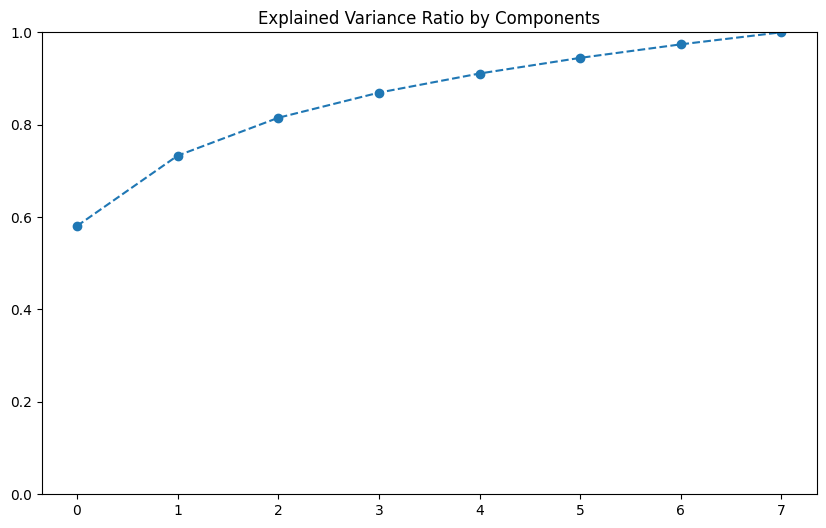

In [137]:
# plot that as scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(full_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.ylim(0, 1)

plt.title('Explained Variance Ratio by Components')

In [138]:
full_pca_data.shape

(34214400, 8)

In [139]:
middle_vectors_full_pca, _ = extract_middle_vectors(torch.Tensor(full_pca_data))

middle_vectors_full_pca.shape

torch.Size([2365, 8])

# Cluster

### Function Definitions 📚

In [152]:
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the organs dictionary
organs_dict = {
    'background/unlabeled': 0,  # For multi-class use case
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

# Define a fixed label order
label_order = [
    'background/unlabeled',
    'aorta',
    'gall_bladder',
    'spleen',
    'stomach',
    'kidney_right',
    'kidney_left',
    'liver',
    'pancreas',
    'postcava'
]

# Create a reverse mapping from label numbers to organ names
reverse_organs_dict = {v: k for k, v in organs_dict.items()}

def calculate_purities(data, labels, algorithms, plot=True):
    # Define binary label mapping
    binary_label_mapping = {0: 'background/unlabeled', 1: 'pancreas'}

    # Determine the label mapping
    unique_labels = sorted(pd.unique(labels))
    if unique_labels == [0, 1]:
        label_mapping = binary_label_mapping
    else:
        label_mapping = reverse_organs_dict



    results = []

    # Clustering and purity calculation
    for name, estimator in tqdm(algorithms, desc="Clustering Algorithms", unit="alg"):
        estimator.fit(data)
        if hasattr(estimator, 'labels_'):
            cluster_labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            cluster_labels = estimator.predict(data)
        else:
            raise AttributeError(f"The estimator {name} does not have 'labels_' or 'predict' method.")

        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[1])])
        df = df.reset_index(drop=True)
        df['Cluster'] = cluster_labels
        df['Labels'] = labels

        df_dd = dd.from_pandas(df, npartitions=4)
        df_dd['Cluster'] = df_dd['Cluster'].astype('category')
        df_dd['Labels'] = df_dd['Labels'].astype('category')
        df_dd = df_dd.persist()

        counts = df_dd.groupby(['Cluster', 'Labels']).size()
        counts_pd = counts.compute()
        cluster_label_counts = counts_pd.unstack(fill_value=0)
        cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)

        # Rename columns using organ names
        cluster_label_counts.columns = [f'Count_{label_mapping.get(col, col)}' for col in cluster_label_counts.columns]
        cluster_label_ratio.columns = [f'Ratio_{label_mapping.get(col, col)}' for col in cluster_label_ratio.columns]

        purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()
        purity_df['Algorithm'] = name

        if hasattr(estimator, 'n_clusters'):
            purity_df['n_clusters'] = estimator.n_clusters
        else:
            purity_df['n_clusters'] = None

        results.append(purity_df)

    final_df = pd.concat(results, ignore_index=True)

    # Plotting
    if plot:
        # Plotting the stacked bar chart
        for algo in final_df['Algorithm'].unique():
            algo_df = final_df[final_df['Algorithm'] == algo].copy()
            algo_df.set_index('Cluster', inplace=True)
            
            # Ensure the 'Cluster' index is of integer type and sorted
            algo_df.index = algo_df.index.astype(int)
            algo_df.sort_index(inplace=True)
            
            ratio_cols = [col for col in algo_df.columns if col.startswith('Ratio_')]

            # Remove the "Ratio_" prefix
            ratio_cols_renamed = [col.replace('Ratio_', '') for col in ratio_cols]
            algo_df.rename(columns=dict(zip(ratio_cols, ratio_cols_renamed)), inplace=True)

            # Ensure labels are in consistent order
            labels_in_data = [label for label in label_order if label in ratio_cols_renamed]
            algo_df = algo_df[labels_in_data]

            # Generate colors based on the fixed label order
            n_labels_total = len(label_order)
            colors_palette = sns.color_palette("tab10", n_labels_total)
            label_to_color = dict(zip(label_order, colors_palette))
            colors = [label_to_color[label] for label in labels_in_data]

            # Plotting the stacked bar chart
            ax = algo_df[labels_in_data].plot(
                kind='bar',
                stacked=True,
                figsize=(12, 8),
                edgecolor='black',
                title=f'Purity Ratios per Cluster for {algo}',
                color=colors
            )

            # Adding labels and title
            ax.set_xlabel('Cluster', fontsize=14)
            ax.set_ylabel('Purity Ratio', fontsize=14)
            ax.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

            algo_df.reset_index(inplace=True)

    return final_df

def cluster_and_plot_purities(data, labels, cluster_range=range(2, 51, 2), plot=True, random_state=42):
    import warnings

    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
    )

    algorithms = []

    for n_clusters in cluster_range:
        mbk_name = f'MiniBatchKMeans_n{n_clusters}'
        mbk = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            batch_size=10000,
            init='k-means++',
            n_init='auto'
        )
        algorithms.append((mbk_name, mbk))

    purity_results = calculate_purities(
        data=data,
        labels=labels,
        algorithms=algorithms,
        plot=plot
    )

    return purity_results, algorithms

import matplotlib.pyplot as plt
import pandas as pd

def plot_prior_distribution(labels, label_mapping=reverse_organs_dict):
    """
    Plot the prior distribution of the original labels as a bar chart.

    Parameters:
    - labels: array-like, shape (n_samples,)
        The true labels.
    - label_mapping: dict, optional
        Dictionary mapping label numbers to organ names.
    """
    # Calculate the label distribution (counts and proportions)
    label_counts = pd.Series(labels).value_counts().sort_index()
    label_proportions = label_counts / label_counts.sum()

    # If a label mapping is provided, replace label numbers with organ names
    if label_mapping:
        label_names = [label_mapping.get(lbl, lbl) for lbl in label_counts.index]
    else:
        label_names = [k for k, v in sorted(organs_dict.items(), key=lambda item: item[1])]

    # Create a DataFrame for plotting
    label_df = pd.DataFrame({
        'Label': label_names,
        'Count': label_counts.values,
        'Proportion': label_proportions.values
    })

    # Plotting the bar chart for the prior distribution
    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate colors based on the fixed label order
    n_labels_total = len(label_order)
    colors_palette = sns.color_palette("tab10", n_labels_total)
    label_to_color = dict(zip(label_order, colors_palette))
    colors = [label_to_color.get(label, 'grey') for label in label_df['Label']]

    ax.bar(label_df['Label'], label_df['Proportion'], color=colors, edgecolor='black')

    # Adding labels and title
    ax.set_xlabel('Organ', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_title('Prior Distribution of Organ Labels', fontsize=16)

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [22]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

## Full Raw Data, Tissue Density Labels

In [14]:
flat_cts = flatten_features(all_encoded_cubes)

In [15]:
tissue_density_labels = torch.load('data/generated-data/tissue_density_labels.pt')

### TODO issue with tissue_density_labels - it was not encoded so now it's too big. Fix this later

In [16]:
tissue_density_labels.shape

torch.Size([44, 55, 96, 96, 96])

In [17]:
sampled_points_coordinates.shape

torch.Size([44, 55, 3])

In [18]:
data = flat_cts.numpy()
labels = tissue_density_labels.flatten().numpy()

In [19]:
minibatchkmeans_10.fit(data)

/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=10, random_state=42)

In [21]:
data.shape

(33454080, 8)

In [22]:
labels.shape

(2141061120,)

In [20]:
cluster_and_plot_purities(data, labels)

Clustering Algorithms:   0%|          | 0/49 [00:03<?, ?alg/s]


ValueError: Length of values (2141061120) does not match length of index (33454080)

## Middle Vectors of $24^3$, Multi-Organ Labels Purities

Raw data, no scaling, no PCA. Just Flattened

In [153]:
flat_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_cts)#.unsqueeze(0))#(0))[0]

In [154]:
raw_cubes_middle_vecs.shape

torch.Size([2365, 8])

In [155]:
data = raw_cubes_middle_vecs.numpy()

In [156]:
labels = sampled_points_multi_organ_labels.flatten().numpy()

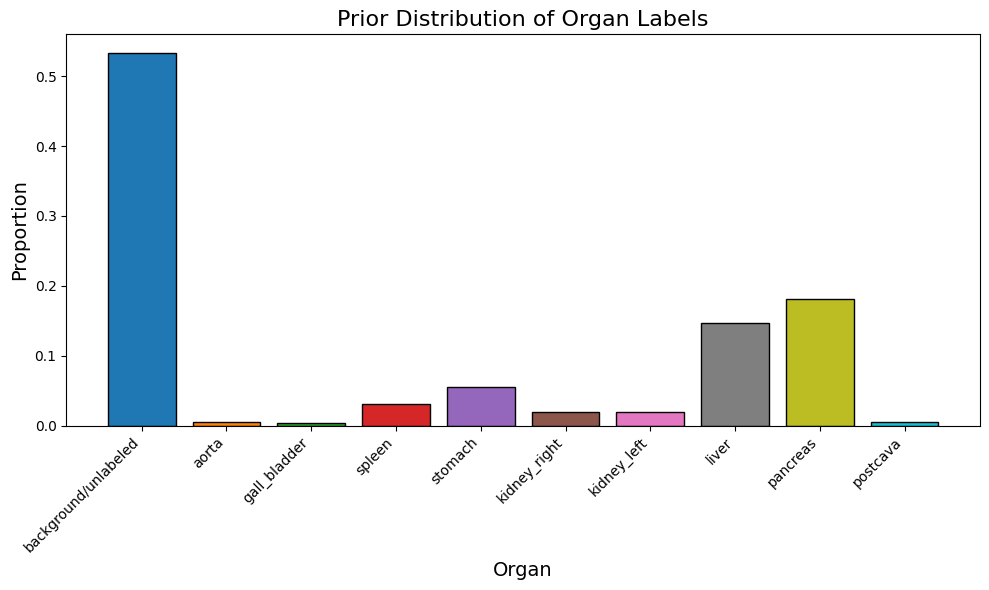

In [157]:
plot_prior_distribution(sampled_points_multi_organ_labels.flatten().numpy())#, label_mapping=reverse_organs_dict)

Clustering Algorithms: 100%|██████████| 25/25 [00:18<00:00,  1.38alg/s]


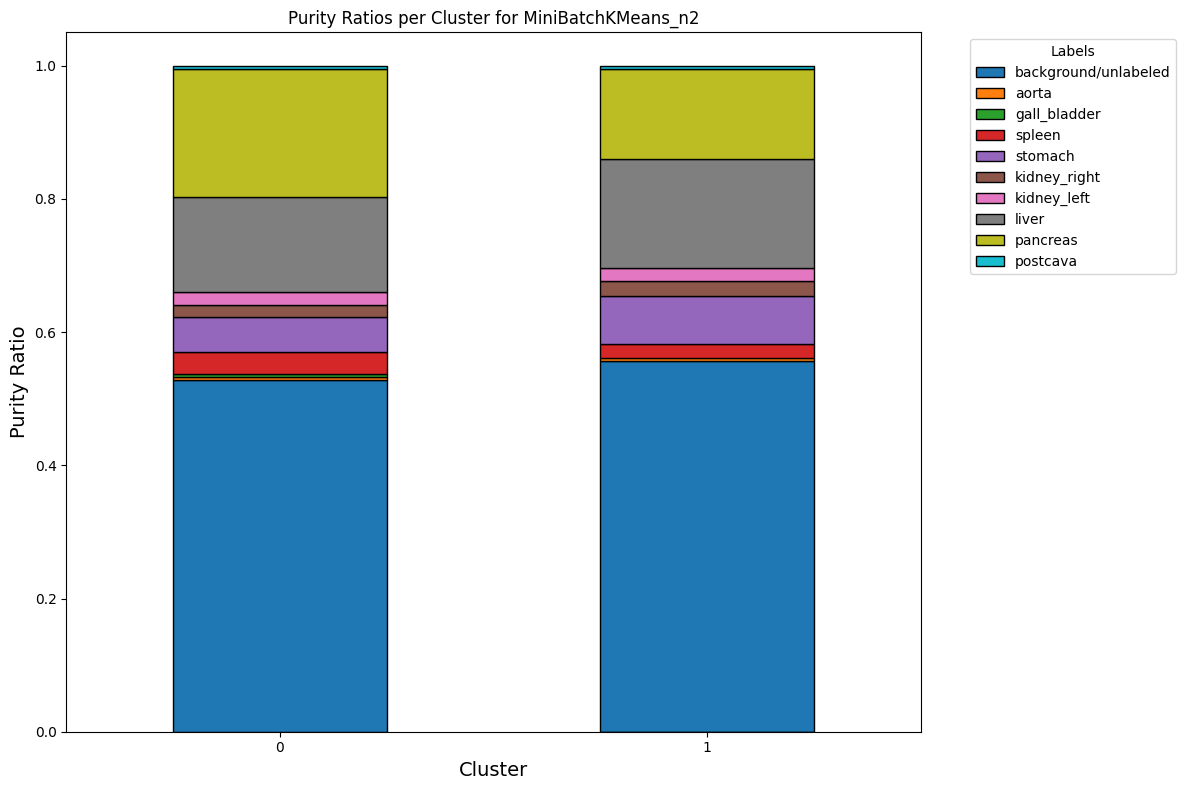

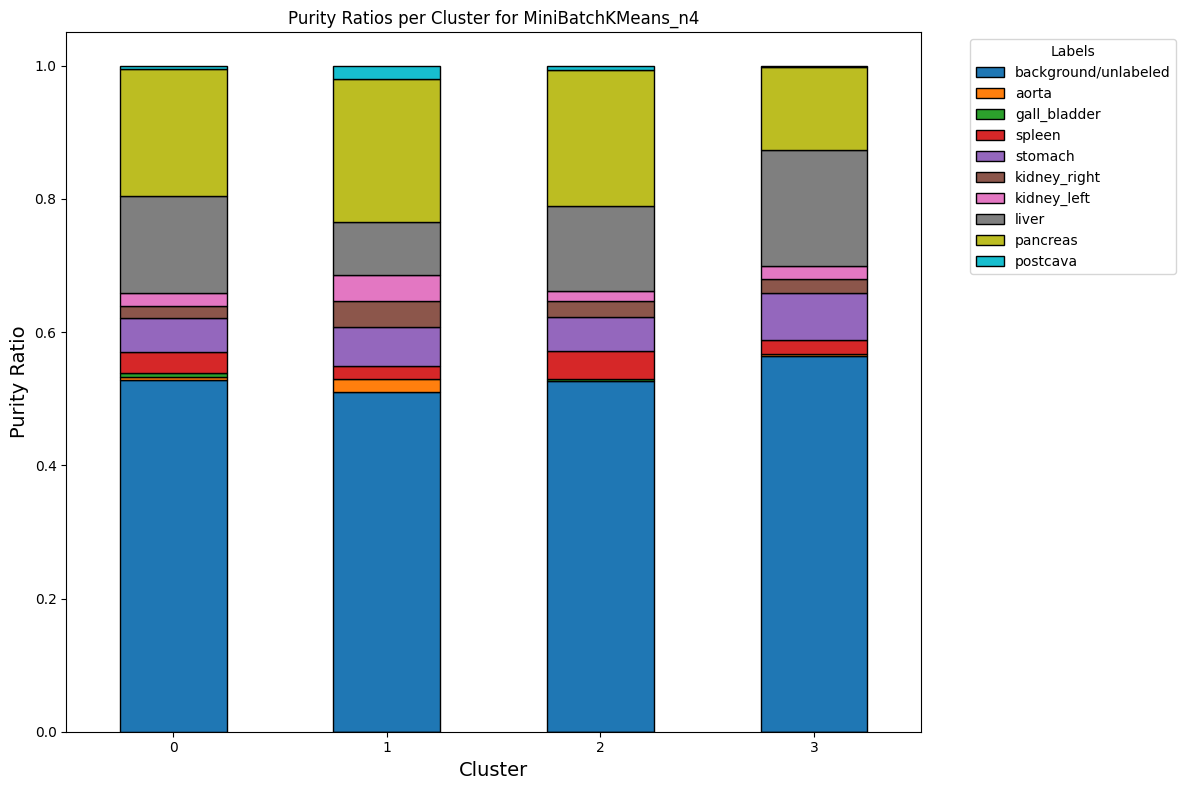

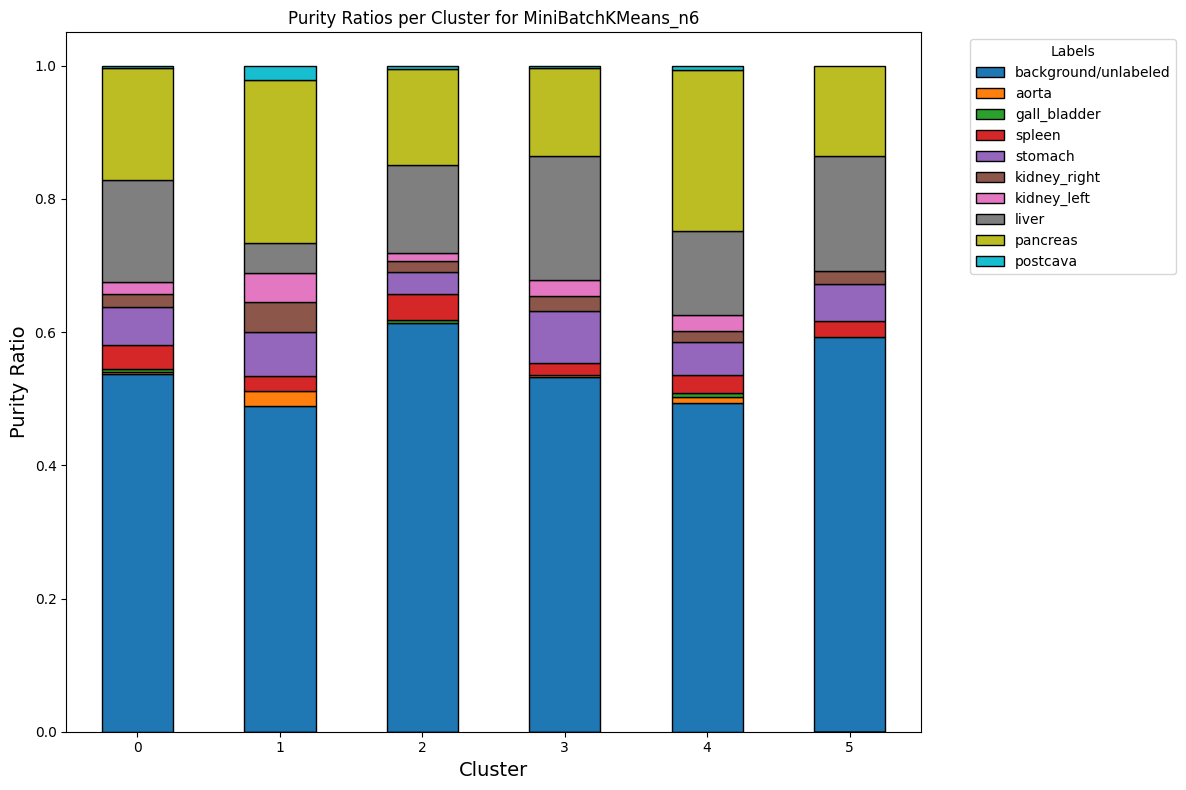

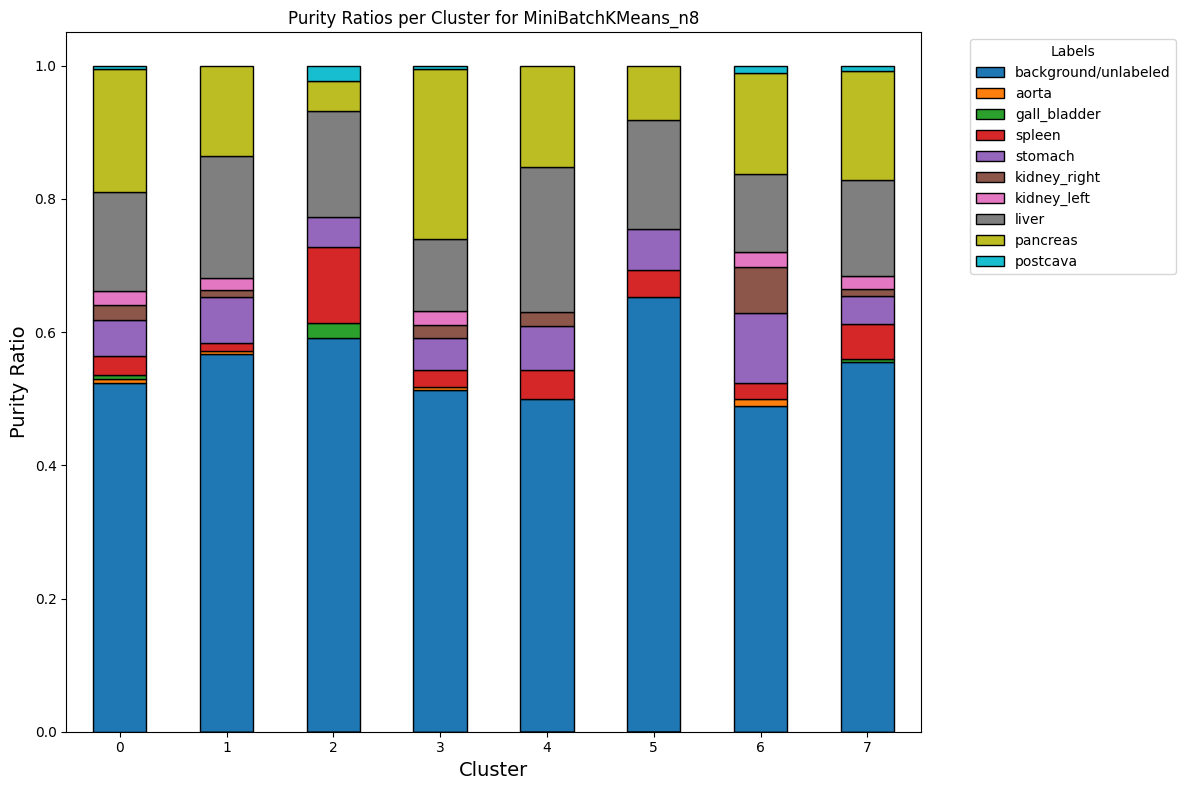

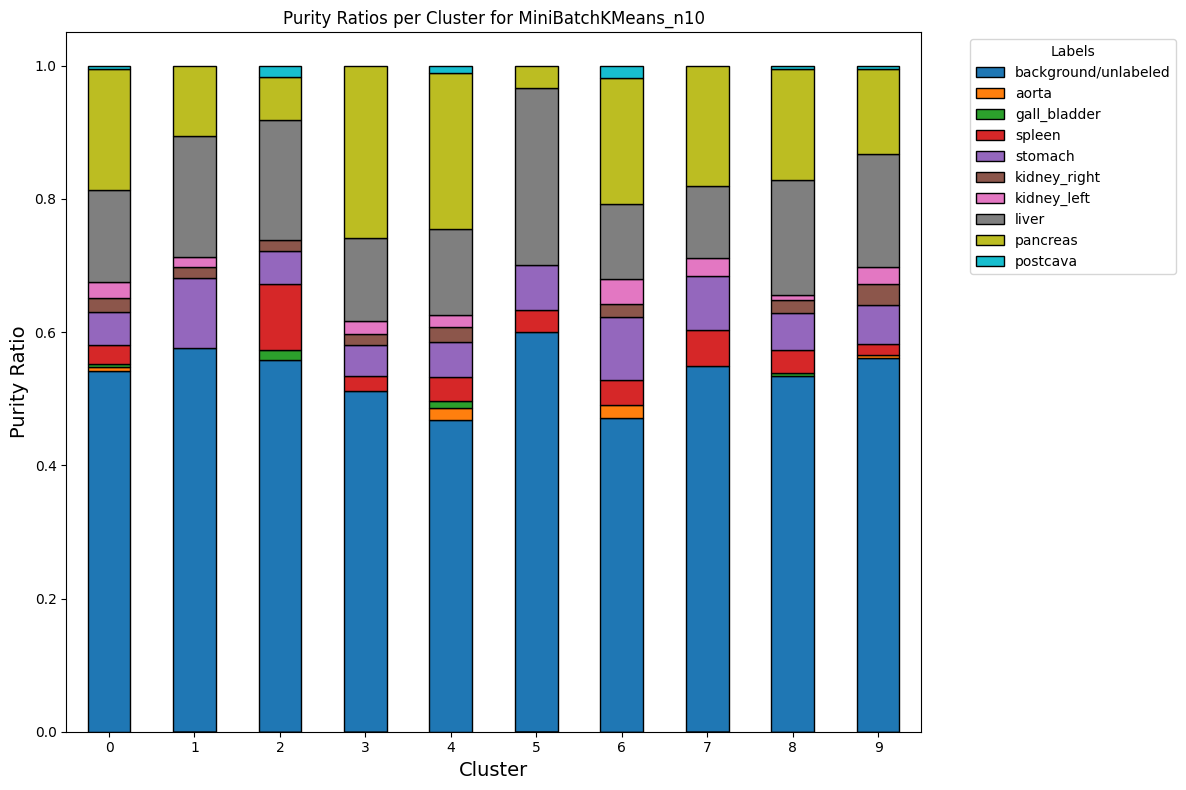

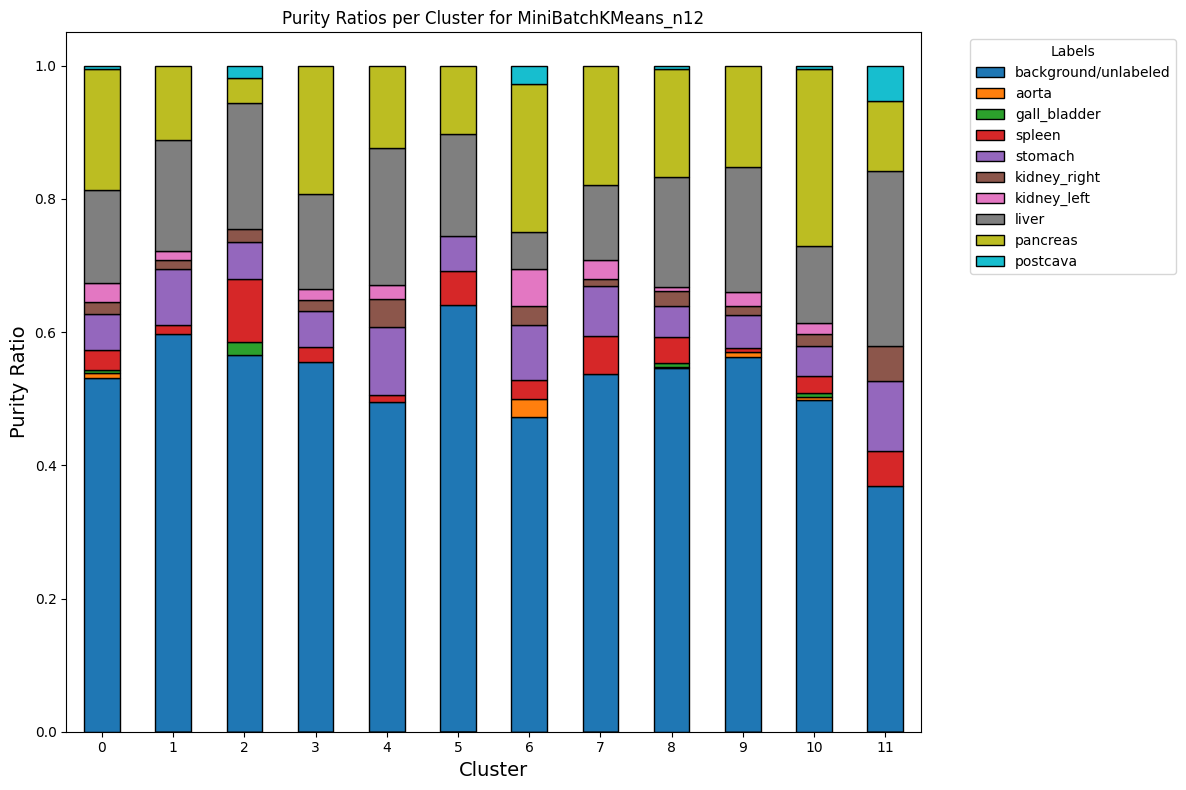

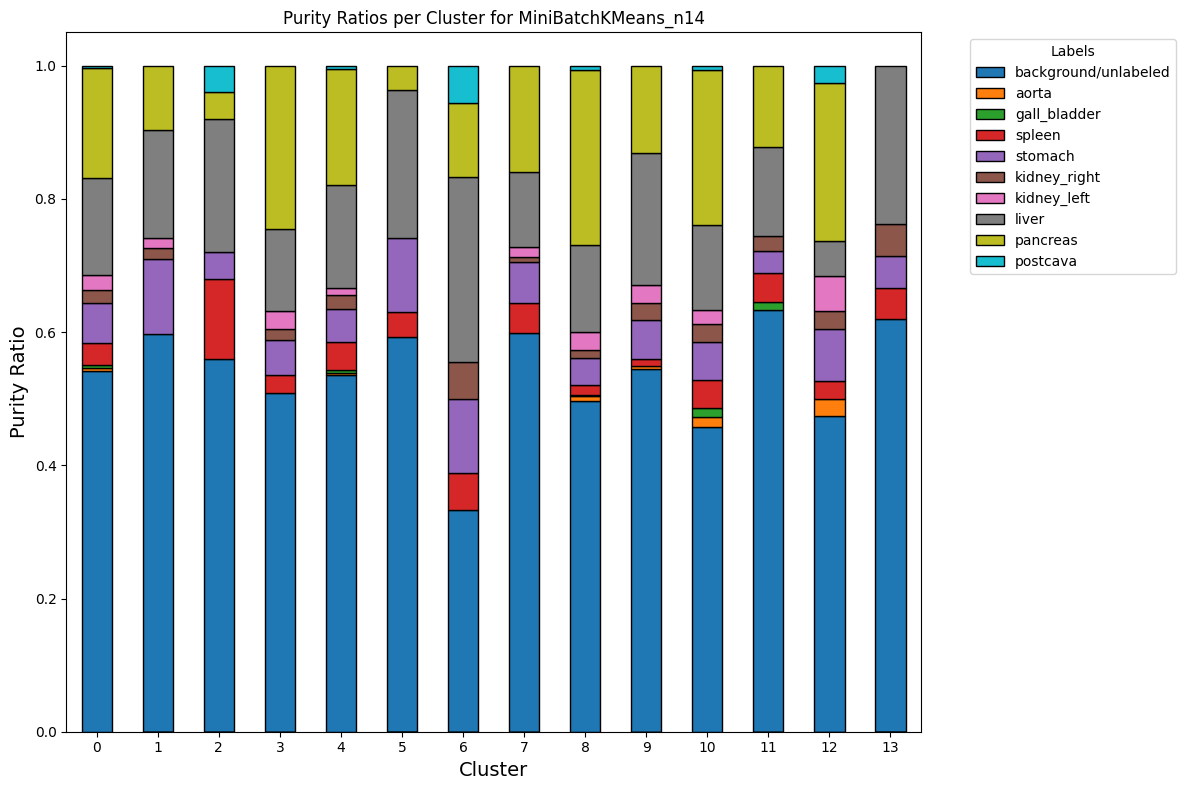

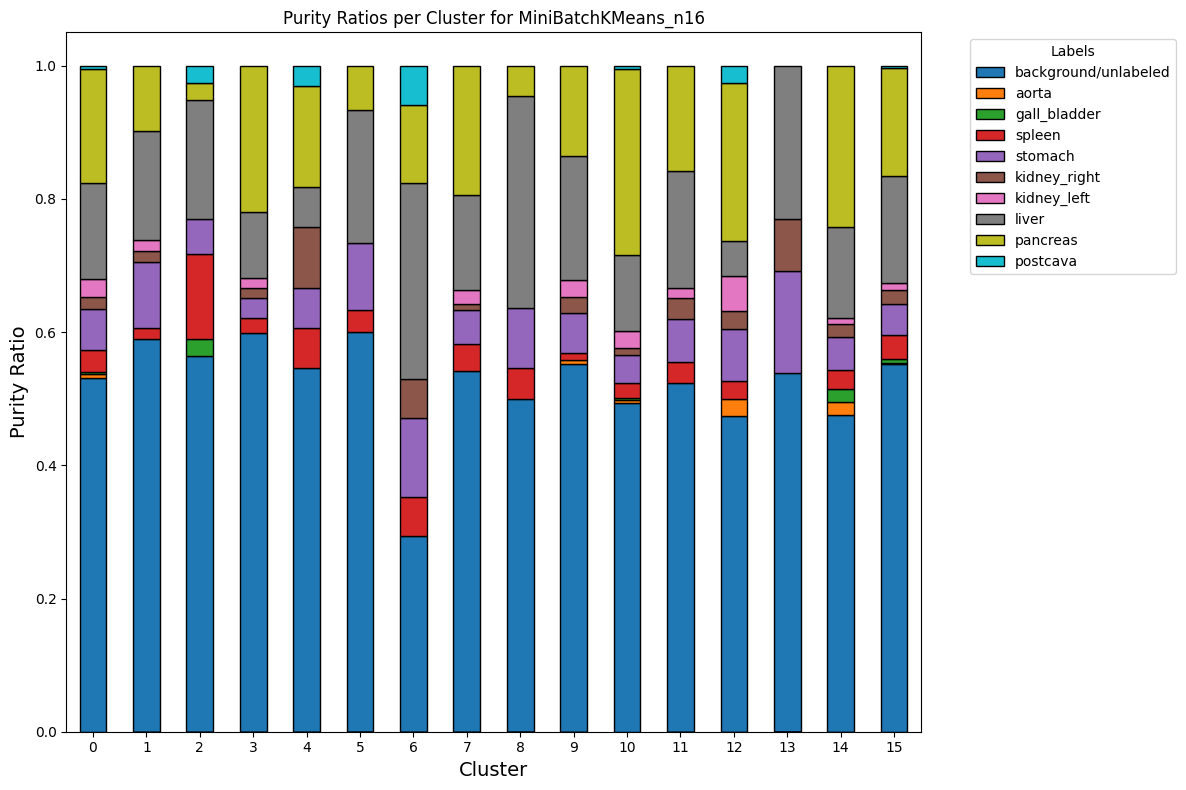

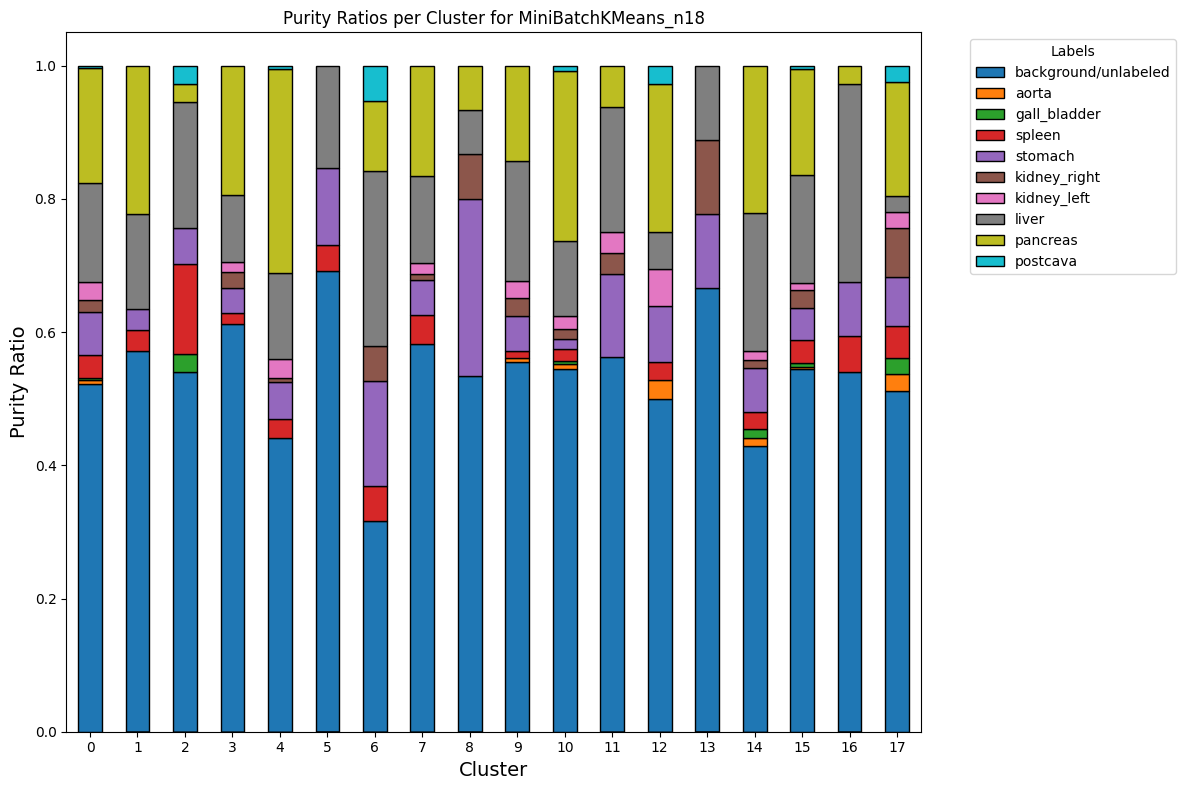

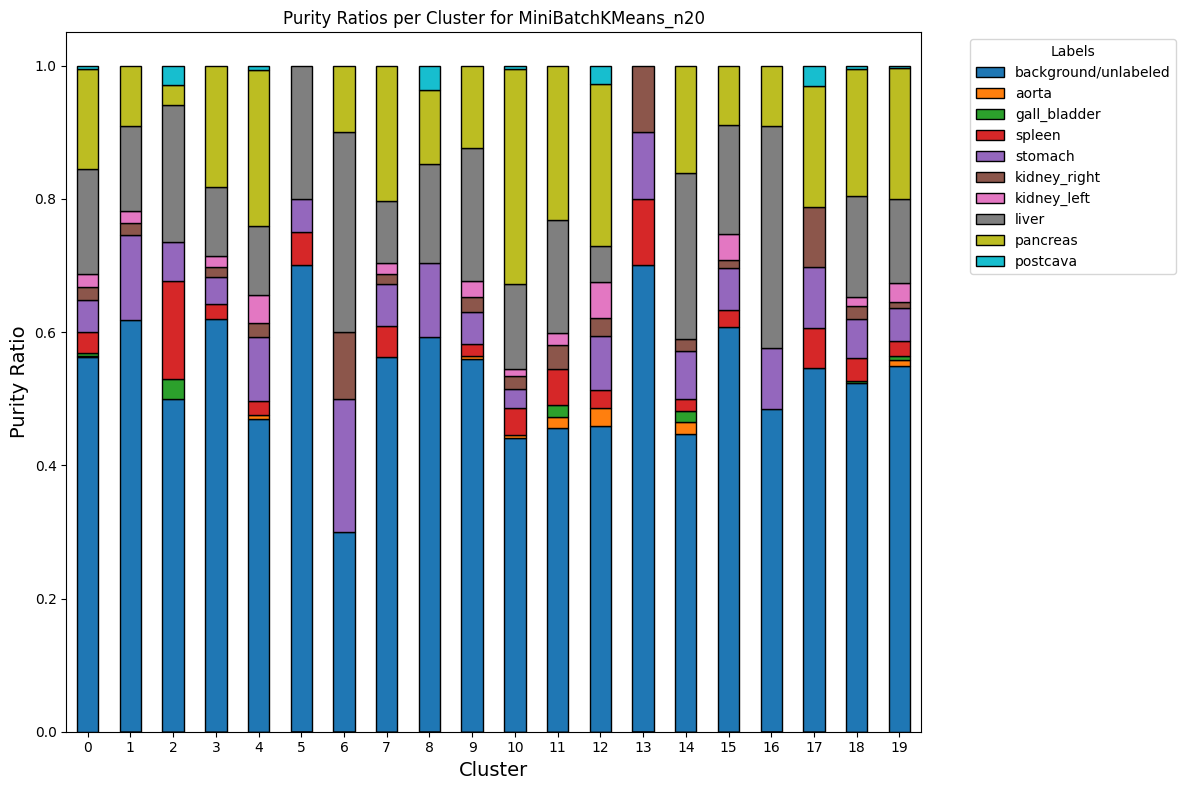

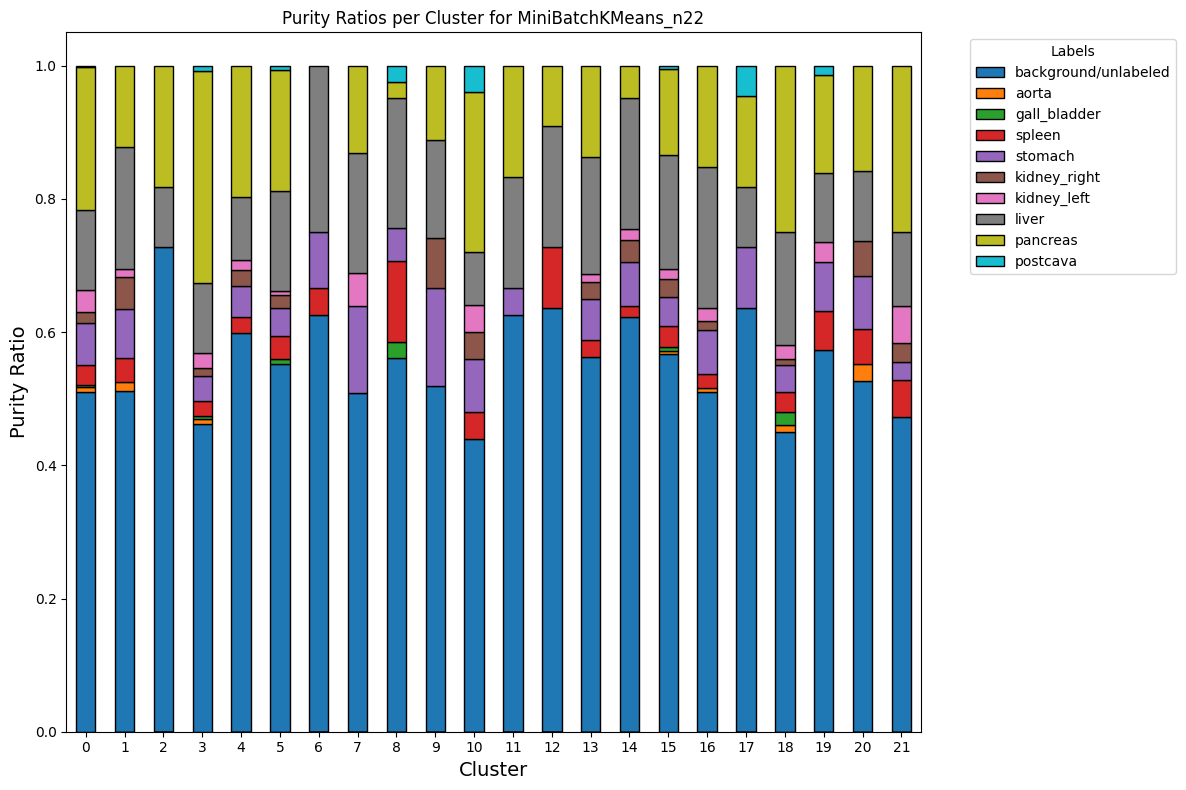

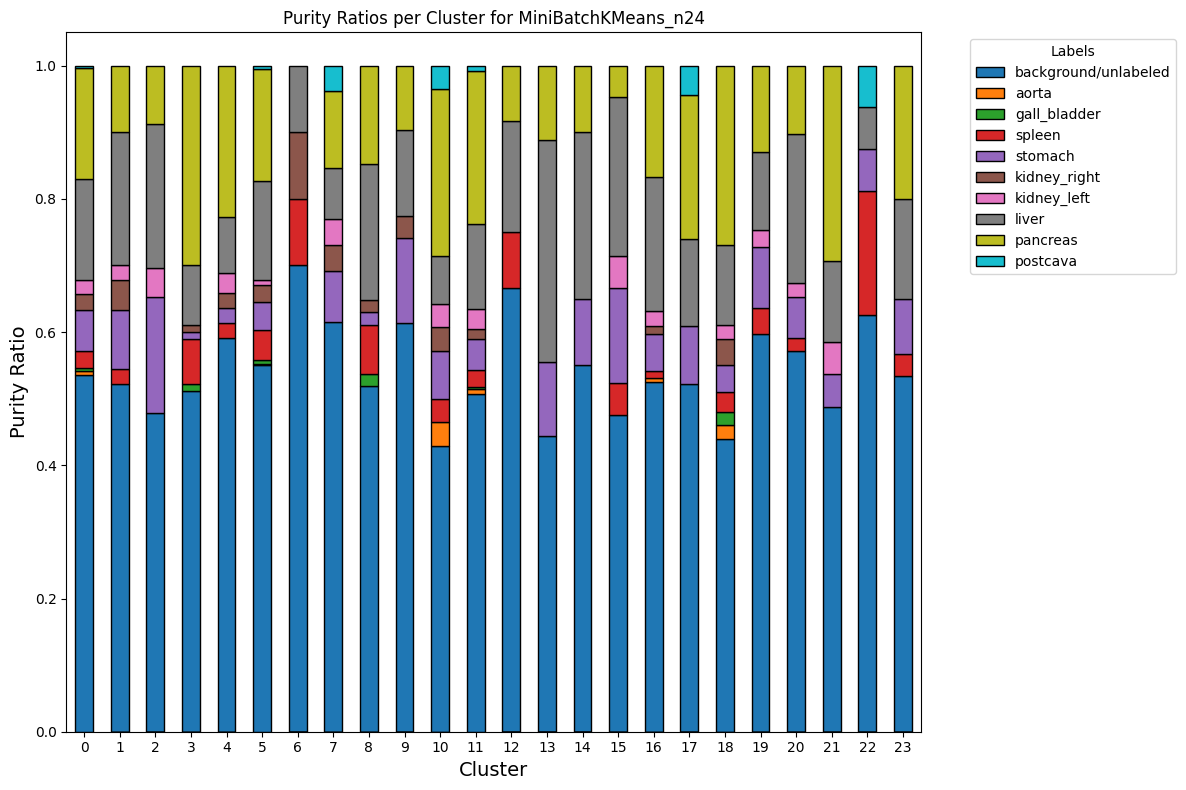

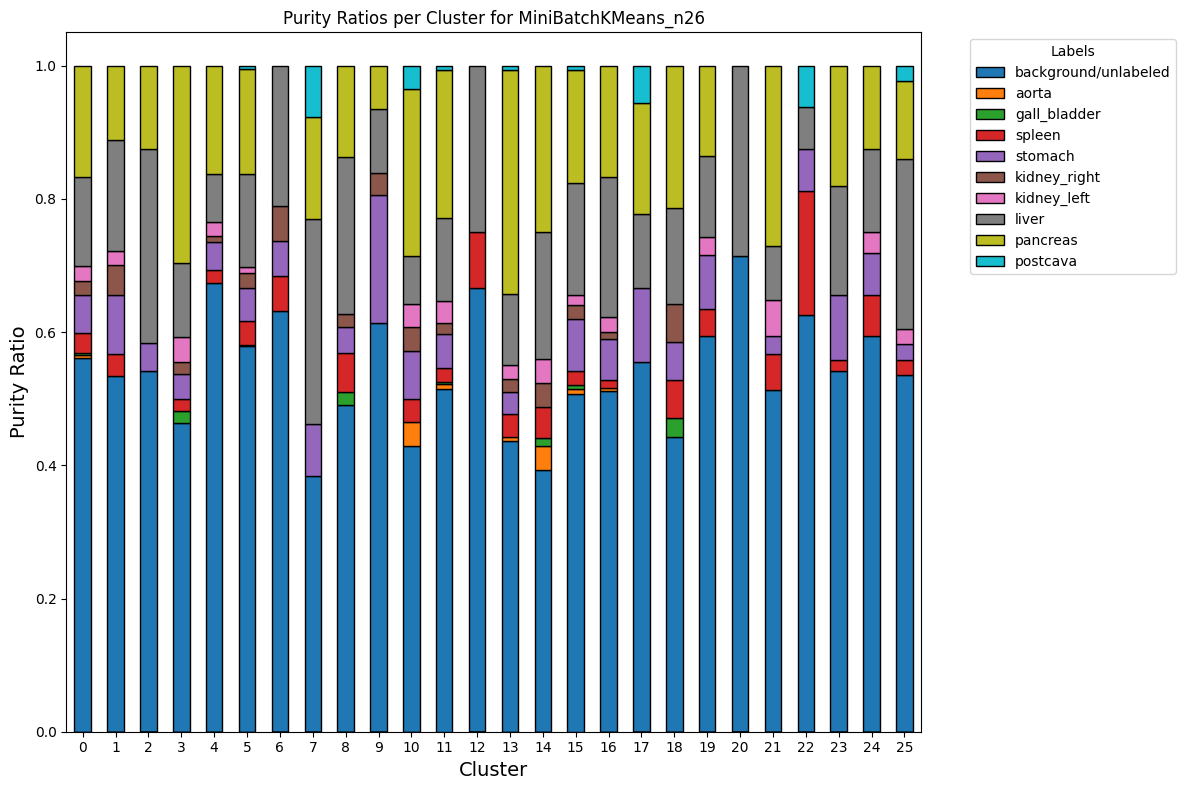

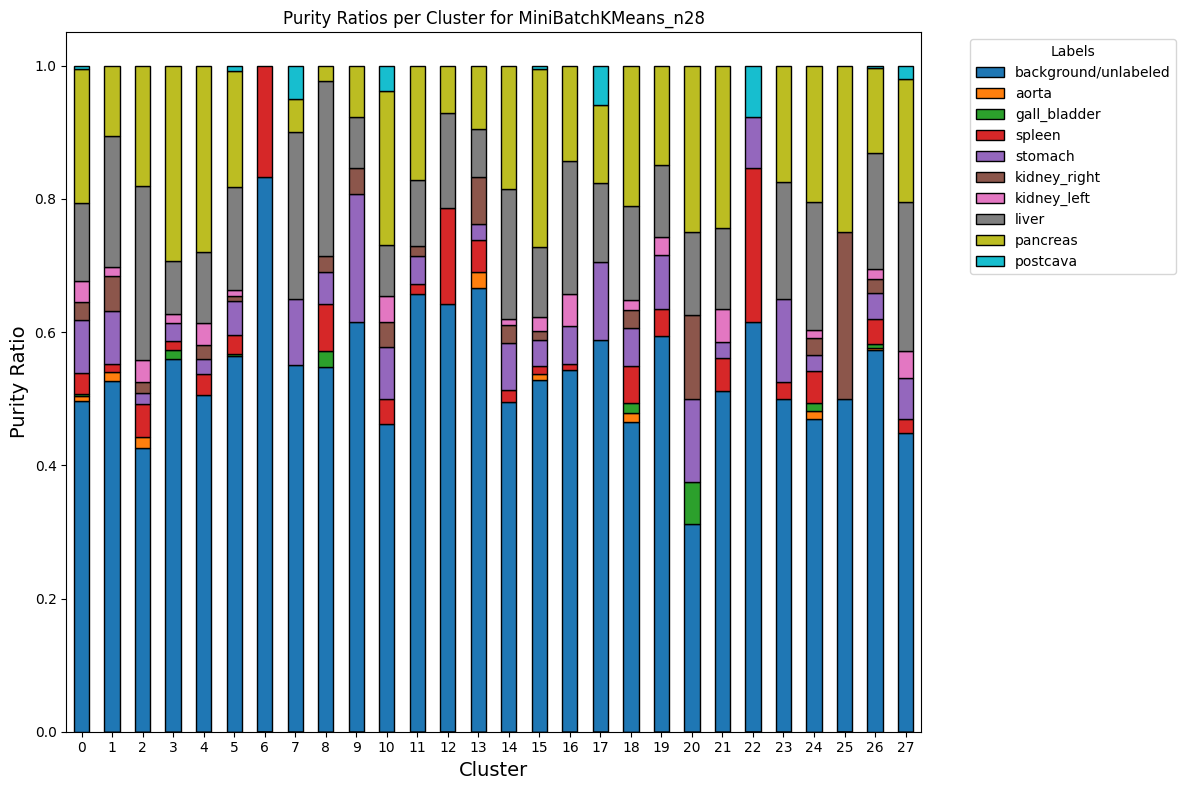

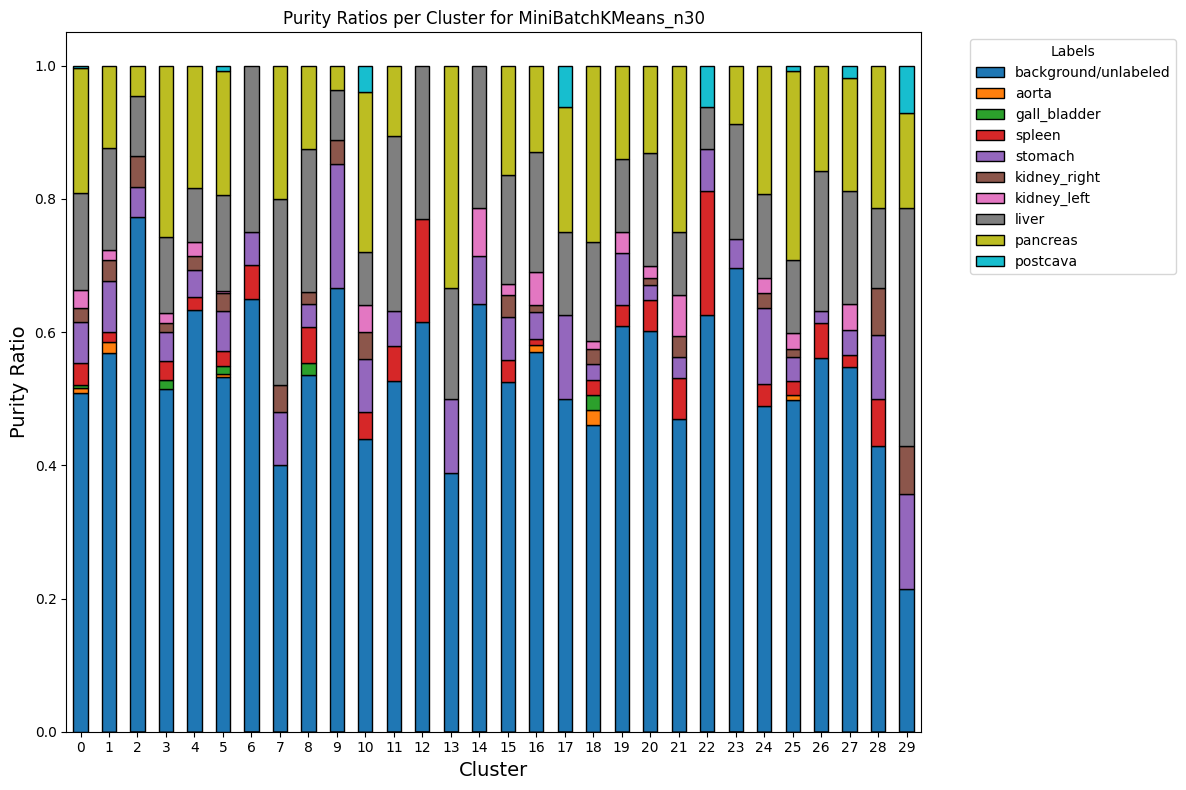

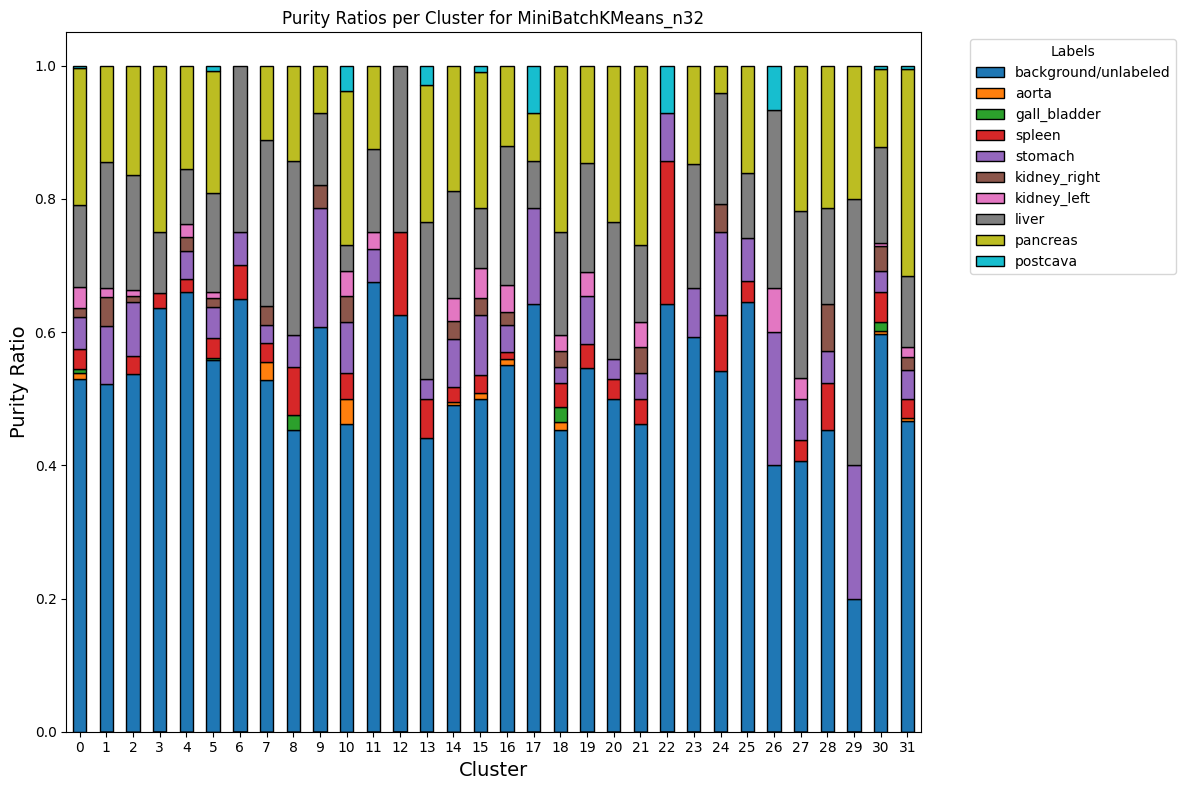

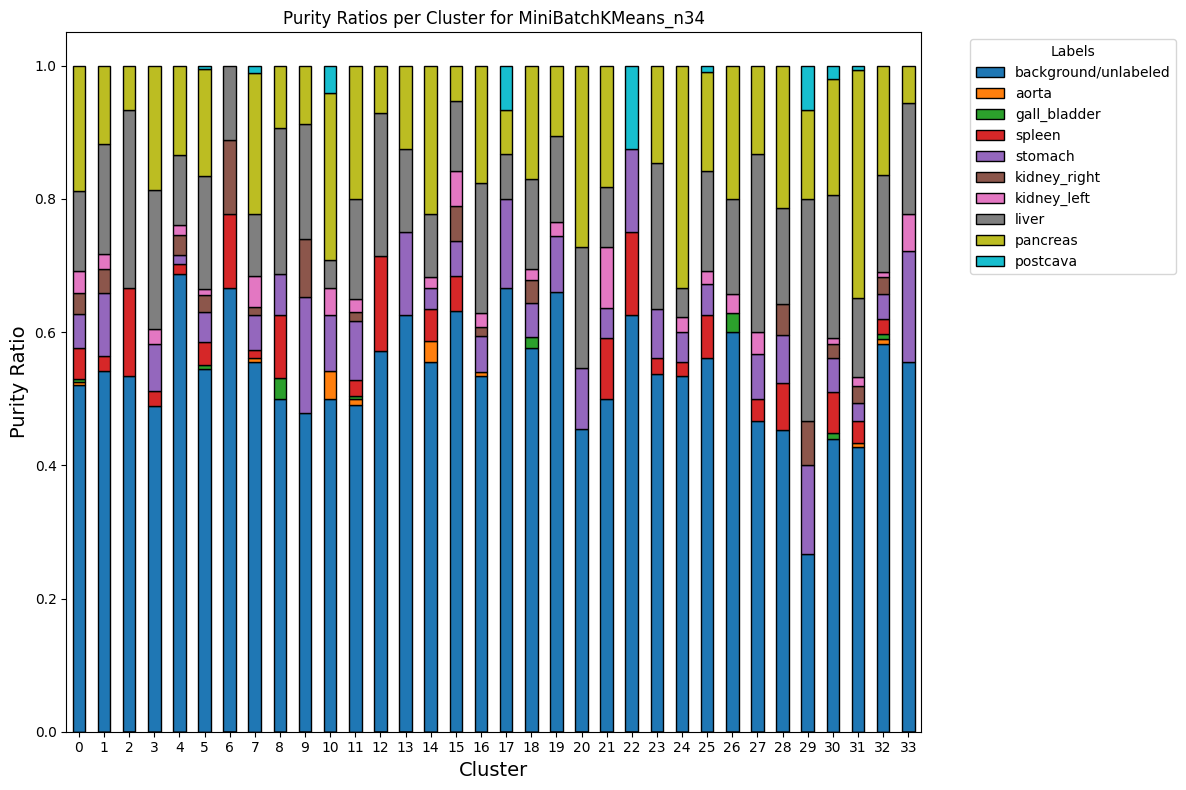

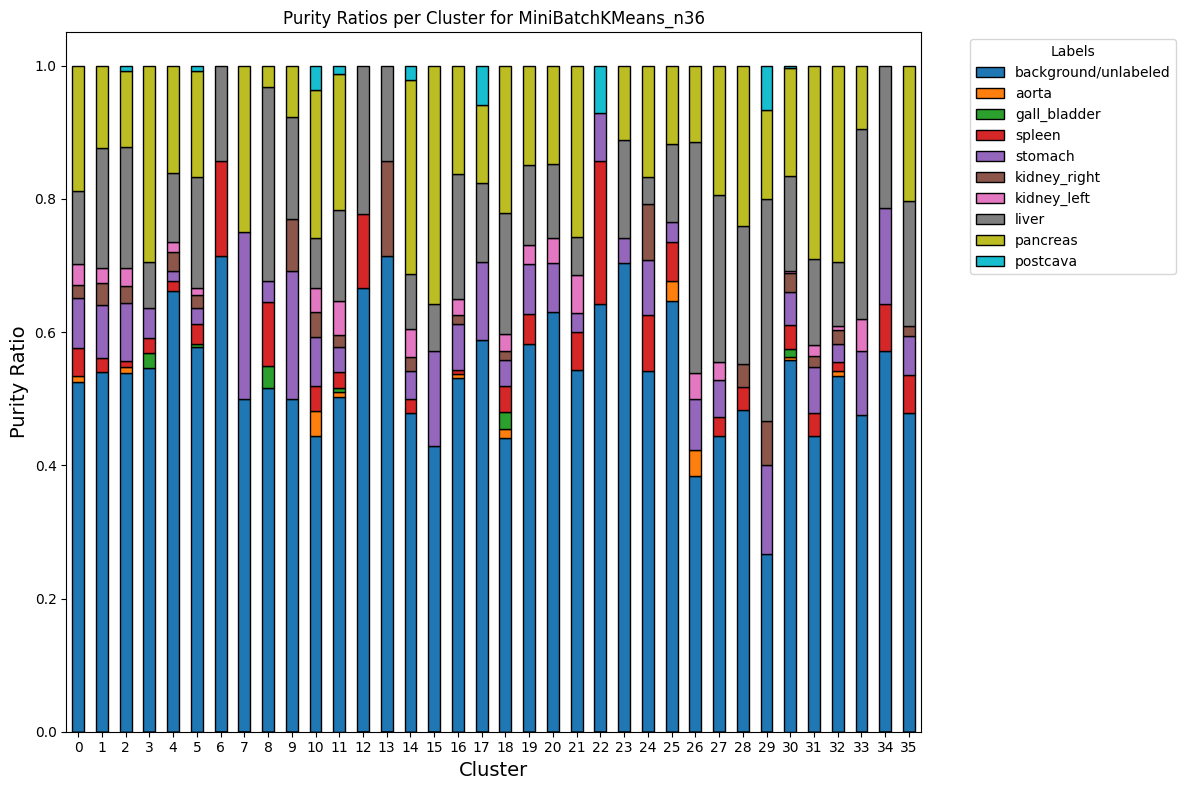

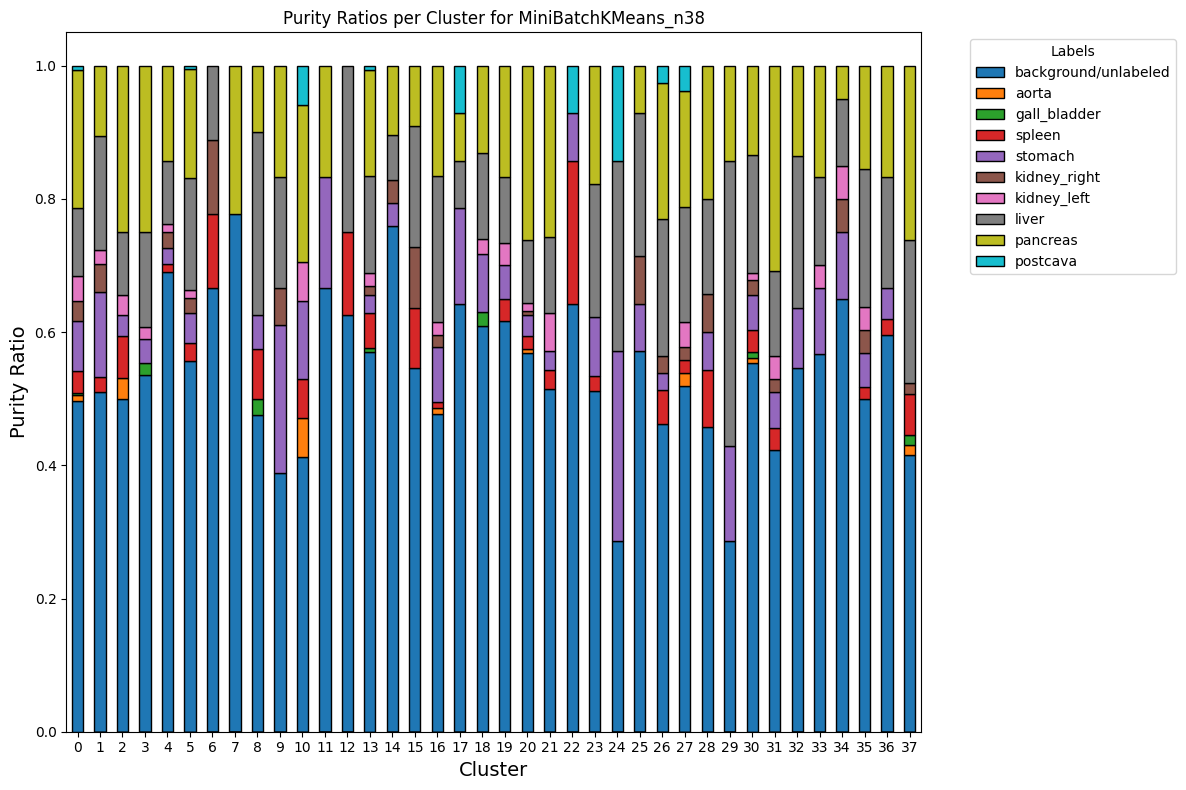

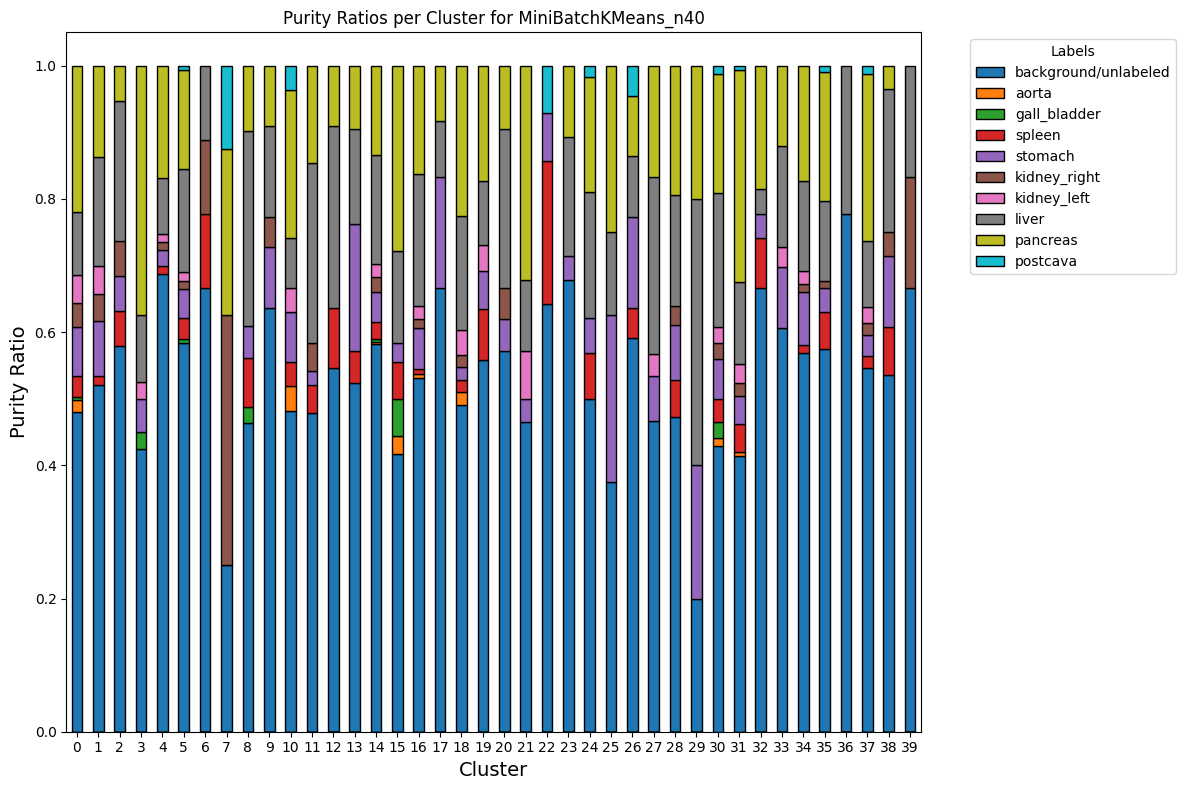

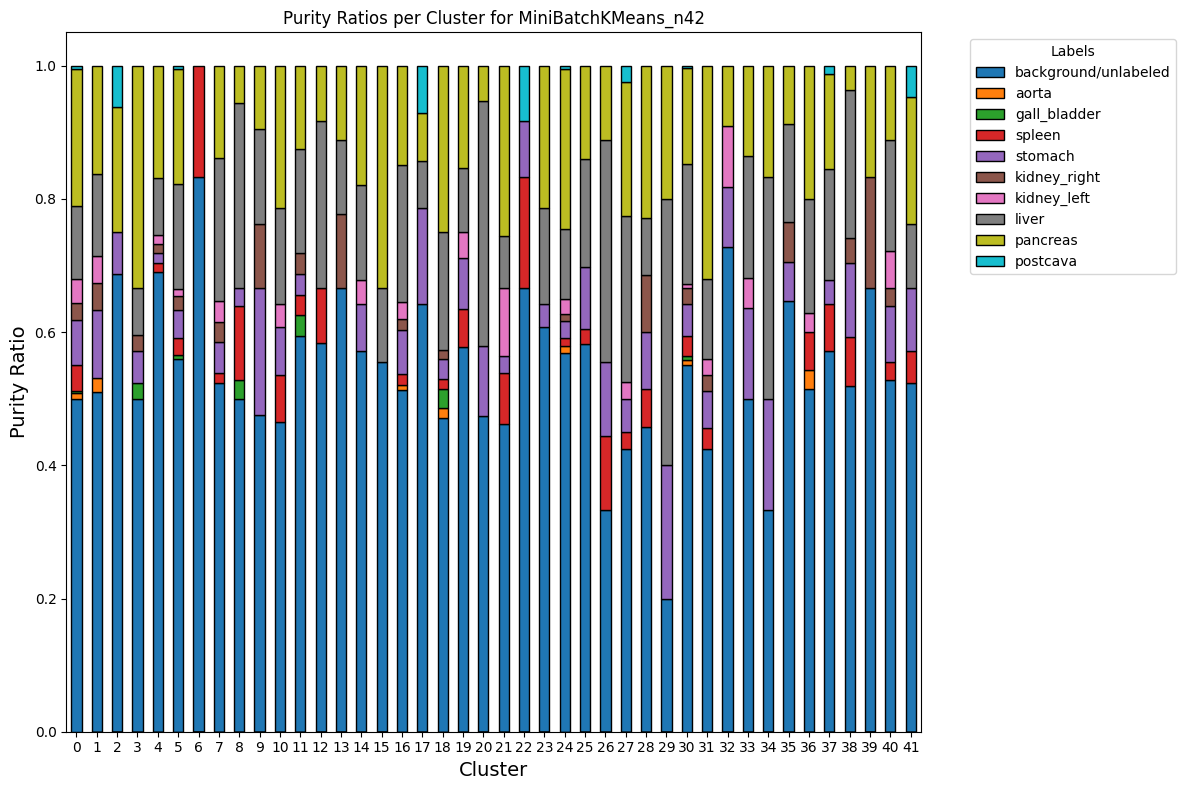

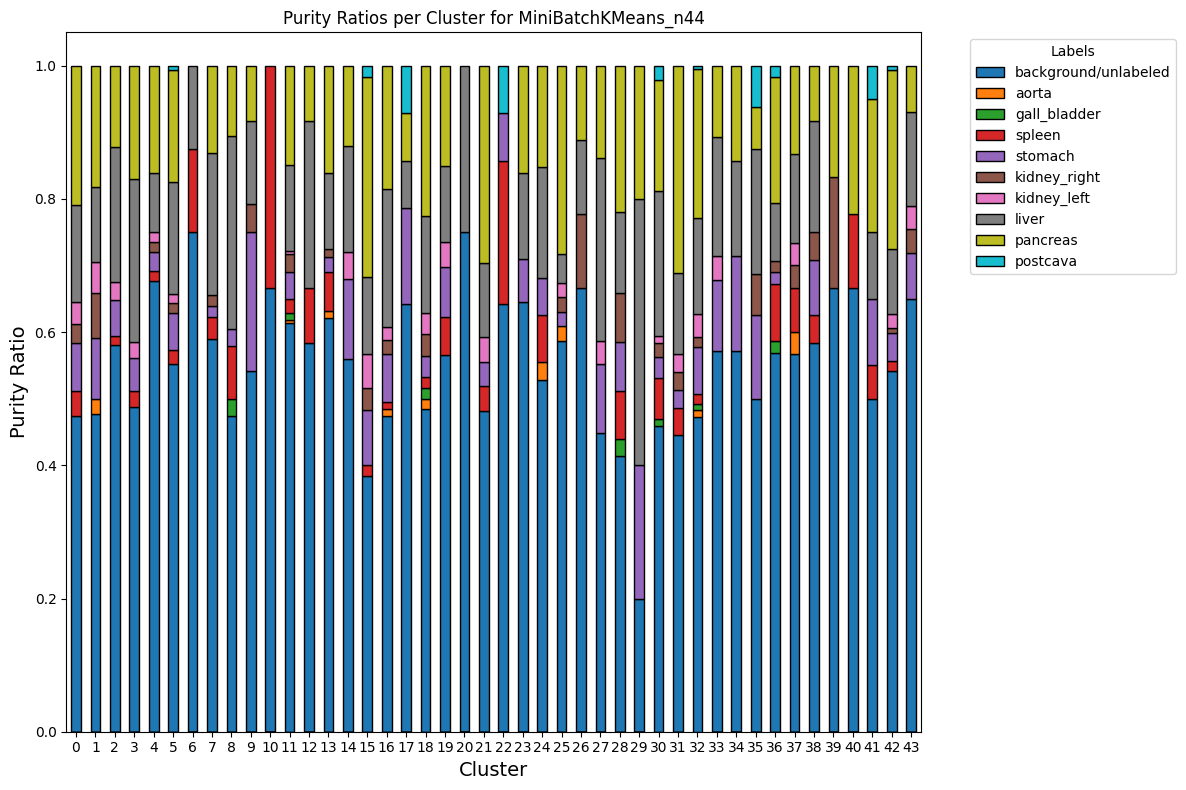

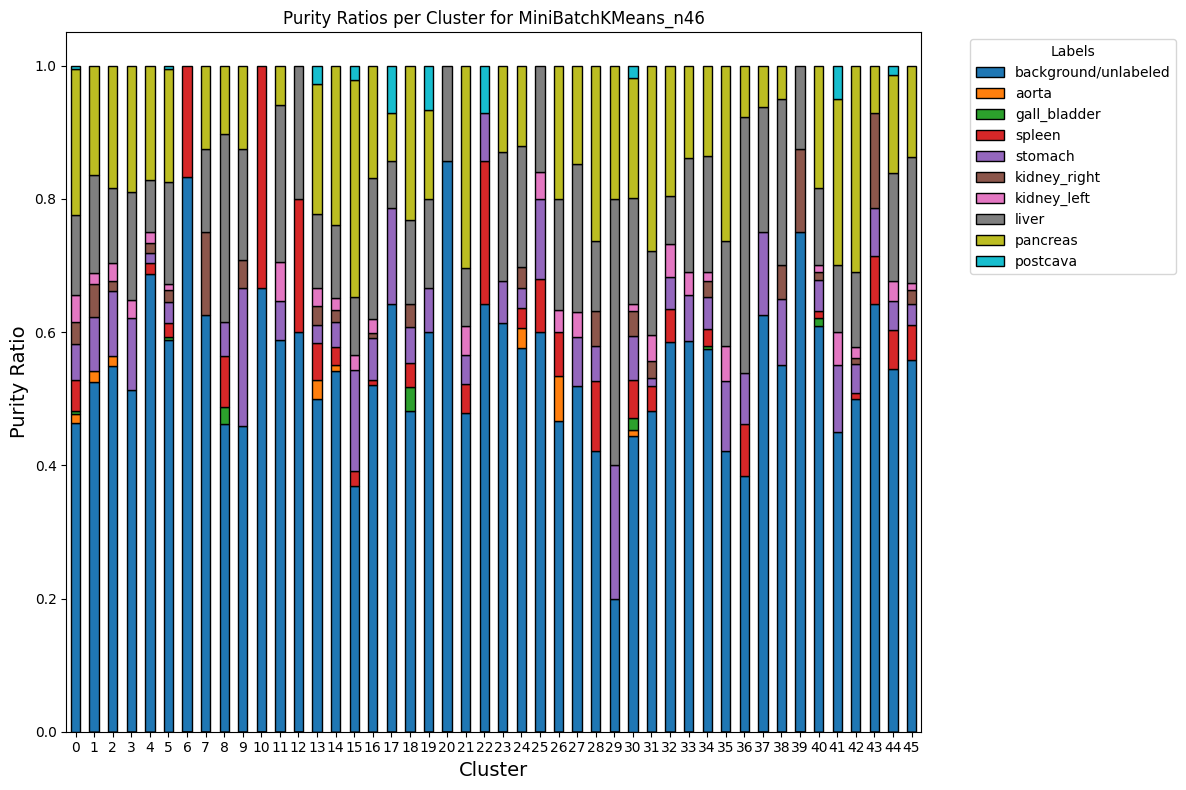

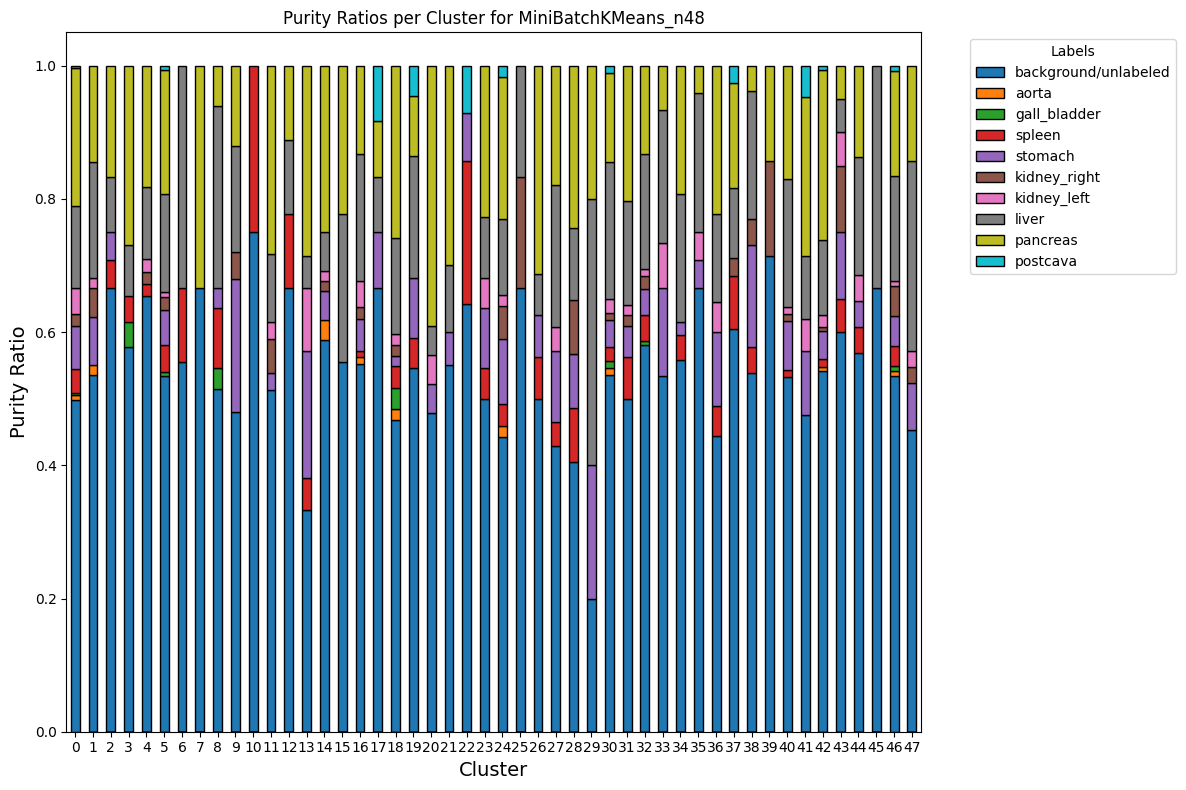

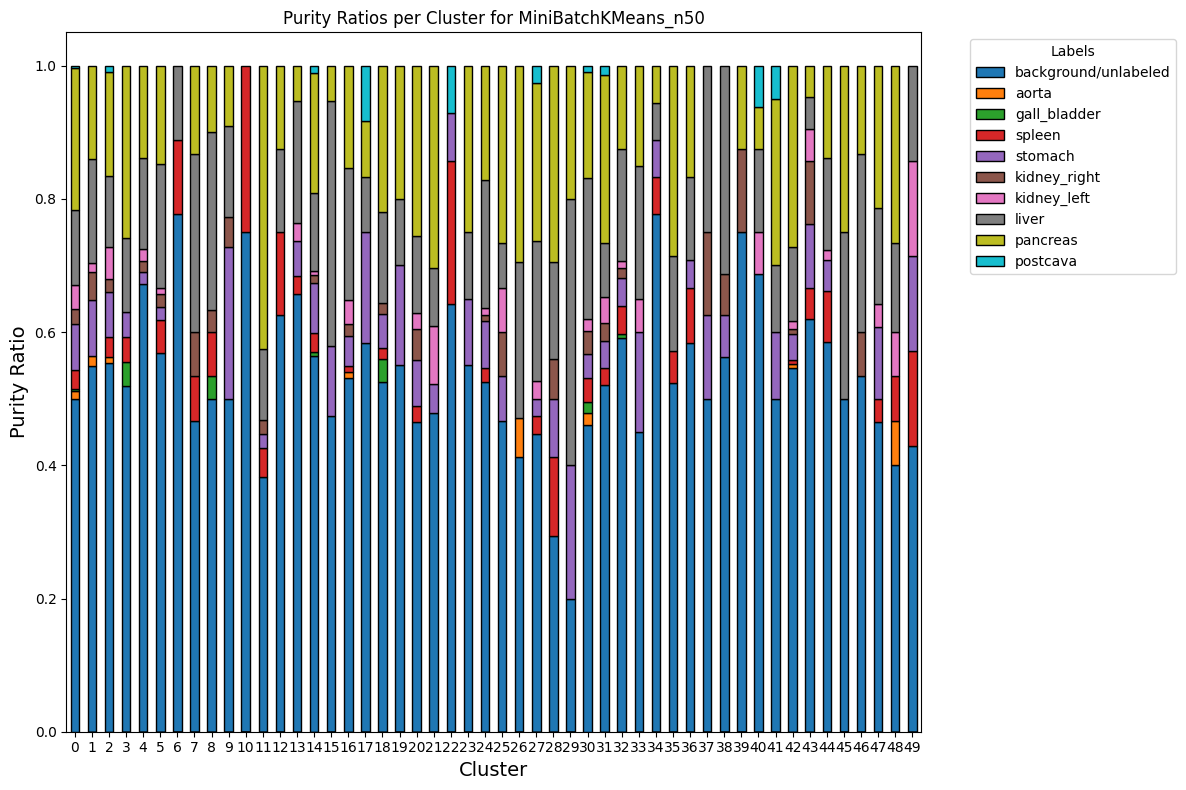

In [158]:
cluster_results, algorithms = cluster_and_plot_purities(data, labels)#, use_case='multi-class')

## Random State Sampled Points interesting clustering results

Random state 1
2 also (Last column in clustering - clusters 29,49)
3
4
5


# Analyzing Clusters

`random_state=50`, cluster #49

In [159]:
from sklearn.cluster import MiniBatchKMeans

minibatchkmeans_50 = MiniBatchKMeans(n_clusters=50, random_state=42)

flat_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_cts)#.unsqueeze(0))#(0))[0]

data = raw_cubes_middle_vecs.numpy()
labels = sampled_points_multi_organ_labels.flatten().numpy()

Clustering Algorithms: 100%|██████████| 1/1 [00:01<00:00,  1.19s/alg]


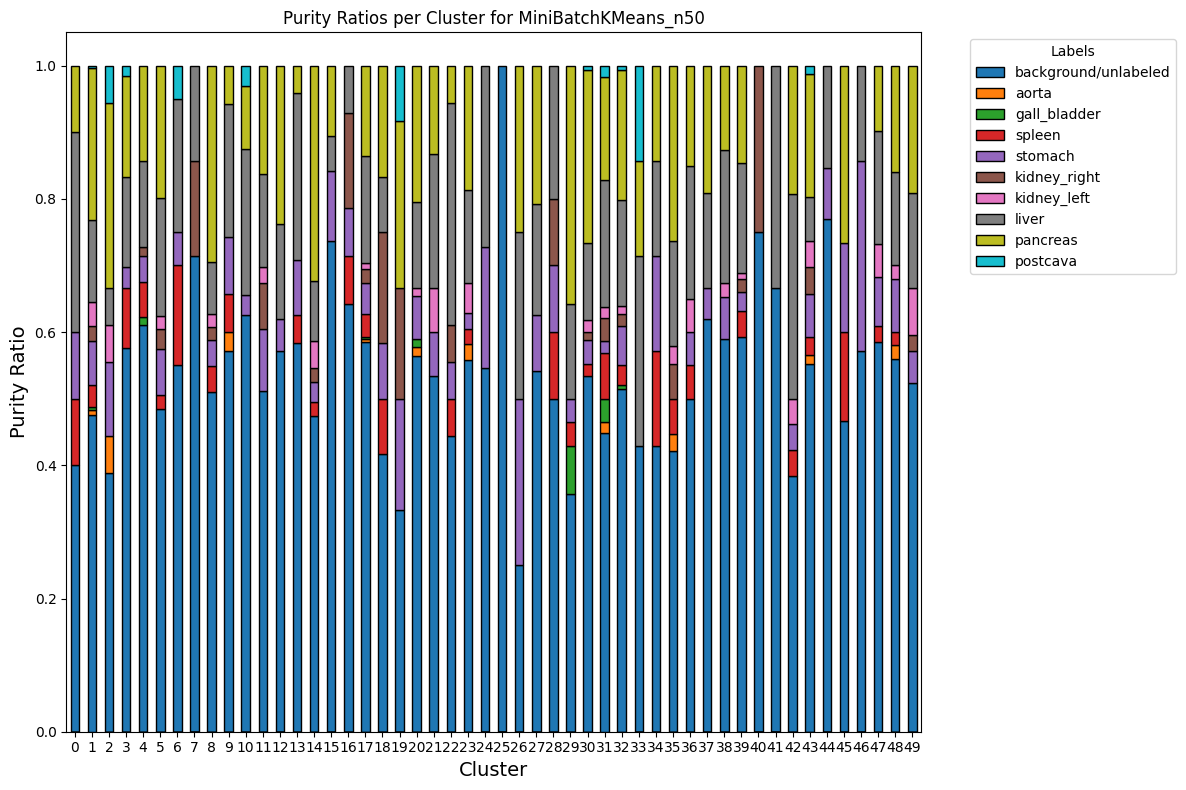

In [164]:
purity_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=[50], random_state=1)

In [165]:
purity_results['Count_Total'] = purity_results.filter(like='Count_').sum(axis=1)

# Rearrange the columns to move 'Count_Total' to the second position
columns = list(purity_results.columns)
columns.insert(1, columns.pop(columns.index('Count_Total')))
purity_results = purity_results[columns]

In [167]:
purity_results_sorted = purity_results.copy()

In [171]:
# Ensure 'Cluster' column is sorted numerically
purity_results_sorted['Cluster'] = purity_results_sorted['Cluster'].astype(int)
purity_results_sorted = purity_results_sorted.sort_values(by='Cluster', inplace=False)

In [172]:
purity_results

Cluster  Count_Total  Count_background/unlabeled  Count_aorta  \
0         0           10                           4            0   
1         1          271                         129            2   
2         2           18                           7            1   
3         3           66                          38            0   
4         4           77                          47            0   
5         5          101                          49            0   
6         6           20                          11            0   
7         7            7                           5            0   
8         8           51                          26            0   
9         9           35                          20            1   
10       10           32                          20            0   
11       11           43                          22            0   
12       12           21                          12            0   
13       13           24                          14            0   
14       14           99                          47            0   
15       15           19                          14            0   
16       16           14                           9            0   
17       17          236                         138            1   
18       18           12                           5            0   
19       19           12                           4            0   
20       20           78                          44            1   
21       21           15                           8            0   
22       22           18                           8            0   
23       23           43                          24            1   
24       24           11                           6            0   
25       25            6                           6            0   
26       27           24                          13            0   
27       28           10                           5            0   
28       29           28                          10            0   
29       30          165                          88            0   
30       31           58                          26            1   
31       32          169                          87            0   
32       33            7                           3            0   
33       35           38                          16            1   
34       36           20                          10            0   
35       37           21                          13            0   
36       38           95                          56            0   
37       39          103                          61            0   
38       40            4                           3            0   
39       42           26                          10            0   
40       43           76                          42            1   
41       44           13                          10            0   
42       45           15                           7            0   
43       46            7                           4            0   
44       47           41                          24            0   
45       48           50                          28            1   
46       49           42                          22            0   
47       34            7                           3            0   
48       26            4                           1            0   
49       41            3                           2            0   

    Count_gall_bladder  Count_spleen  Count_stomach  Count_kidney_right  \
0                    0             1              1                   0   
1                    1             9             18                   6   
2                    0             0              2                   0   
3                    0             6              2                   0   
4                    1             4              3                   1   
5                    0            

In [173]:
purity_results_sorted

Cluster  Count_Total  Count_background/unlabeled  Count_aorta  \
0         0           10                           4            0   
1         1          271                         129            2   
2         2           18                           7            1   
3         3           66                          38            0   
4         4           77                          47            0   
5         5          101                          49            0   
6         6           20                          11            0   
7         7            7                           5            0   
8         8           51                          26            0   
9         9           35                          20            1   
10       10           32                          20            0   
11       11           43                          22            0   
12       12           21                          12            0   
13       13           24                          14            0   
14       14           99                          47            0   
15       15           19                          14            0   
16       16           14                           9            0   
17       17          236                         138            1   
18       18           12                           5            0   
19       19           12                           4            0   
20       20           78                          44            1   
21       21           15                           8            0   
22       22           18                           8            0   
23       23           43                          24            1   
24       24           11                           6            0   
25       25            6                           6            0   
48       26            4                           1            0   
26       27           24                          13            0   
27       28           10                           5            0   
28       29           28                          10            0   
29       30          165                          88            0   
30       31           58                          26            1   
31       32          169                          87            0   
32       33            7                           3            0   
47       34            7                           3            0   
33       35           38                          16            1   
34       36           20                          10            0   
35       37           21                          13            0   
36       38           95                          56            0   
37       39          103                          61            0   
38       40            4                           3            0   
49       41            3                           2            0   
39       42           26                          10            0   
40       43           76                          42            1   
41       44           13                          10            0   
42       45           15                           7            0   
43       46            7                           4            0   
44       47           41                          24            0   
45       48           50                          28            1   
46       49           42                          22            0   

    Count_gall_bladder  Count_spleen  Count_stomach  Count_kidney_right  \
0                    0             1              1                   0   
1                    1             9             18                   6   
2                    0             0              2                   0   
3                    0             6              2                   0   
4                    1             4              3                   1   
5                    0            

In [33]:
minibatchkmeans_38 = MiniBatchKMeans(n_clusters=38, random_state=42)

minibatchkmeans_38.fit(data)

MiniBatchKMeans(n_clusters=38, random_state=42)

In [34]:
save_clusters_as_itk_snap_annotations(sampled_points_coordinates[0].numpy(), minibatchkmeans_38.labels_[:55])

Successfully saved 3465 LandmarkAnnotations to 'annotations.annot'.


In [ ]:

# As a test, save true labels
# save_clusters_as_itk_snap_annotations(sampled_points_coordinates[0].numpy(), labels[:55], filename='true_labels.annot')

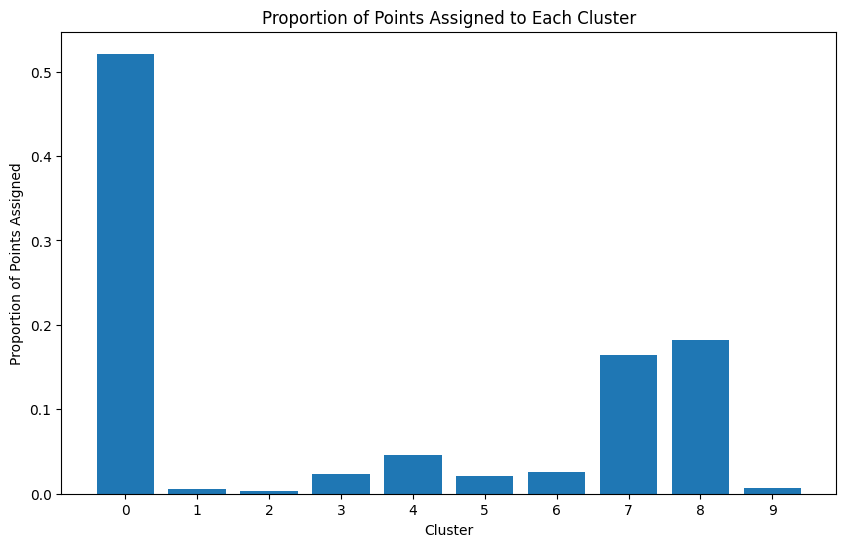

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume `labels` is a numpy array or list containing cluster labels for each data point

# Count the number of points assigned to each cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()

# Calculate proportions
cluster_proportions = cluster_counts / cluster_counts.sum()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_proportions)
plt.xlabel('Cluster')
plt.ylabel('Proportion of Points Assigned')
plt.title('Proportion of Points Assigned to Each Cluster')
plt.xticks(np.arange(min(cluster_counts.index), max(cluster_counts.index) + 1, step=1))
plt.show()

In [43]:
algorithms[36]

('MiniBatchKMeans_n38',
 MiniBatchKMeans(batch_size=10000, n_clusters=38, n_init=10, random_state=42))

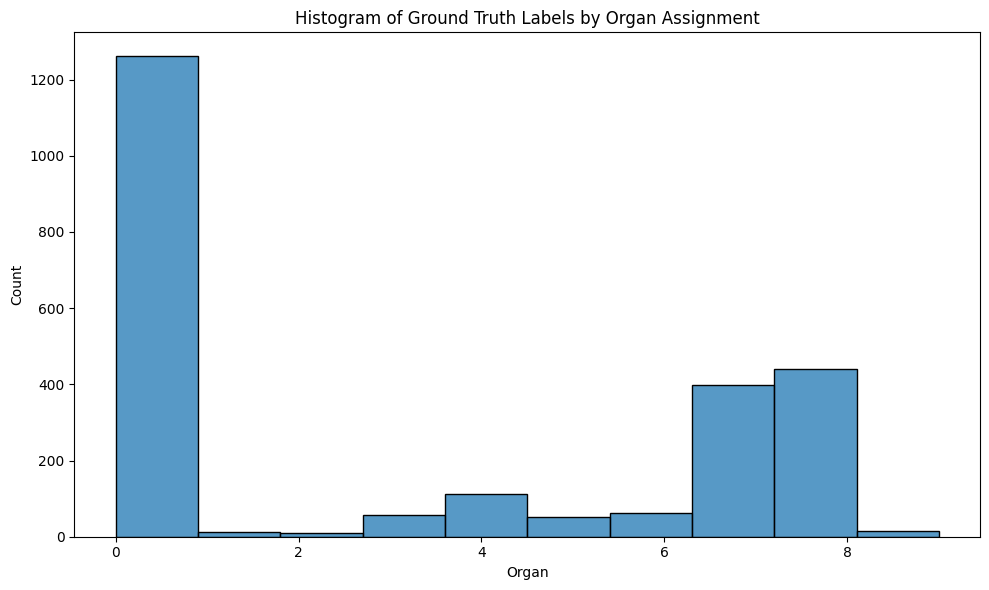

Clustering Algorithms:   0%|          | 0/1 [00:00<?, ?alg/s]


TypeError: cannot unpack non-iterable MiniBatchKMeans object

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot histogram of ground truth labels by organ assignment
plt.figure(figsize=(10, 6))
sns.histplot(labels, bins=len(reverse_organs_dict), kde=False)
plt.title("Histogram of Ground Truth Labels by Organ Assignment")
plt.xlabel("Organ")
plt.ylabel("Count")
# plt.xticks(ticks=list(reverse_organs_dict.values()), labels=list(reverse_organs_dict.keys()), rotation=45)
plt.tight_layout()
plt.show()


purity_results = calculate_purities(
    data=data,
    labels=labels,
    algorithms=[minibatchkmeans_38],
    plot=True  # Set to False if you don't want plots
)

# Plot histogram of points assigned in each cluster
cluster_assignments = purity_results['Cluster']

plt.figure(figsize=(10, 6))
sns.histplot(cluster_assignments, bins=len(cluster_assignments.unique()), kde=False)
plt.title("Histogram of Points Assigned in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
purity_results

Cluster  Count_background/unlabeled  Count_aorta  Count_gall_bladder  \
0           0                         883           10                   6   
1           1                         378            3                   3   
2           0                         843            9                   6   
3           1                         254            3                   1   
4           2                         164            1                   2   
...       ...                         ...          ...                 ...   
1269       48                           3            0                   0   
1270       49                          26            0                   0   
1271       17                           6            0                   0   
1272       41                           5            0                   0   
1273       42                           5            0                   0   

      Count_spleen  Count_stomach  Count_kidney_right  Count_kidney_left  \
0               36             80                  29                 41   
1               21             32                  23                 21   
2               34             81                  30                 47   
3               16             20                  11                 10   
4                7             11                  11                  5   
...            ...            ...                 ...                ...   
1269             0              0                   0                  0   
1270             1              1                   1                  1   
1271             1              1                   0                  0   
1272             0              0                   0                  0   
1273             0              0                   0                  0   

      Count_liver  Count_pancreas  ...  Ratio_gall_bladder  Ratio_spleen  \
0             254             322  ...            0.003593      0.021557   
1             144             118  ...            0.004000      0.028000   
2             277             279  ...            0.003717      0.021066   
3              69             119  ...            0.001969      0.031496   
4              52              42  ...            0.006711      0.023490   
...           ...             ...  ...                 ...           ...   
1269            1               0  ...            0.000000      0.000000   
1270            7               4  ...            0.000000      0.024390   
1271            3               1  ...            0.000000      0.083333   
1272            1               1  ...            0.000000      0.000000   
1273            1               0  ...            0.000000      0.000000   

      Ratio_stomach  Ratio_kidney_right  Ratio_kidney_left  Ratio_liver  \
0          0.047904            0.017365           0.024551     0.152096   
1          0.042667            0.030667           0.028000     0.192000   
2          0.050186            0.018587           0.029120     0.171623   
3          0.039370            0.021654           0.019685     0.135827   
4          0.036913            0.036913           0.016779     0.174497   
...             ...                 ...                ...          ...   
1269       0.000000            0.000000           0.000000     0.250000   
1270       0.024390            0.024390           0.024390     0.170732   
1271       0.083333            0.000000           0.000000     0.250000   
1272       0.000000            0.000000           0.000000     0.142857   
1273       0.000000            0.000000           0.000000     0.166667   

      Ratio_pancreas  Ratio_postcava            Algorithm  n_clusters  
0           0.192814        0.005389   MiniBatchKMeans_n2           2  
1           0.157333        0.009333   MiniBatchKMeans_n2           2  
2           0.172862        0.004957   MiniBatchKMeans_n3           3  
3           0.234252        0.009843   MiniBatchKMeans

Clustering Algorithms: 100%|██████████| 49/49 [00:03<00:00, 12.34alg/s]


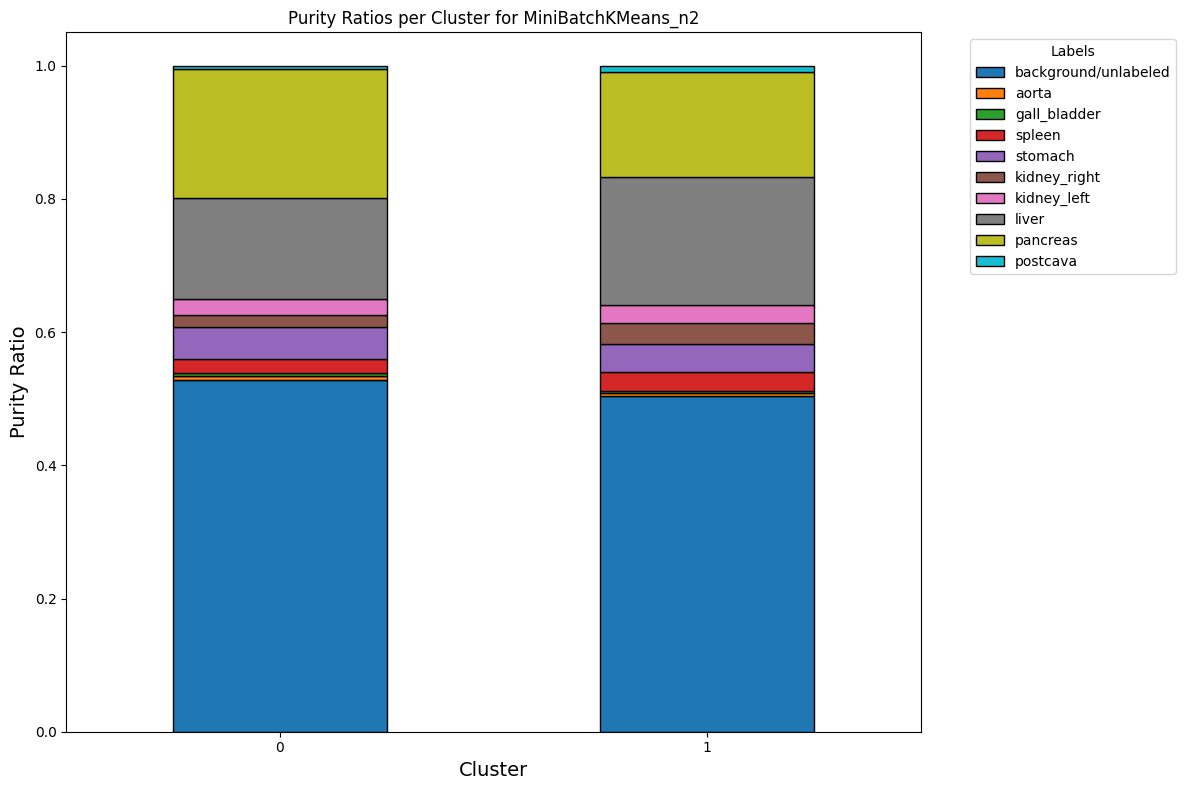

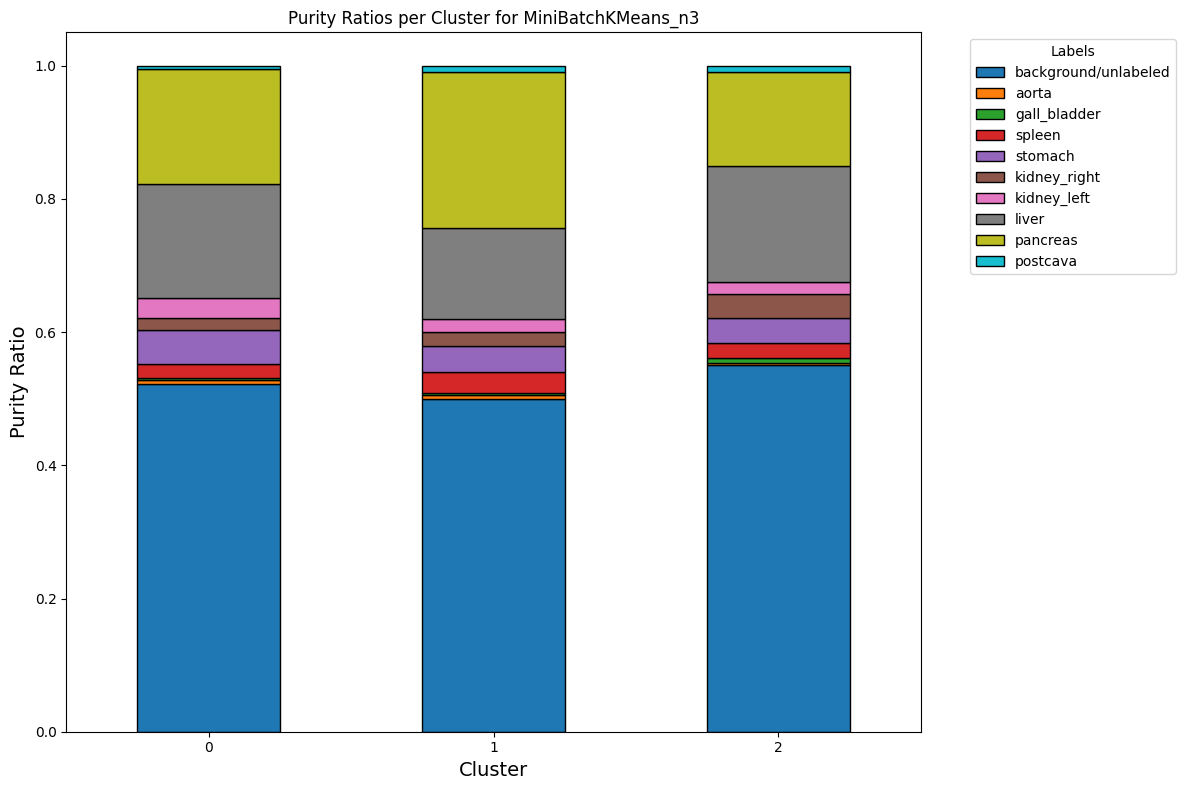

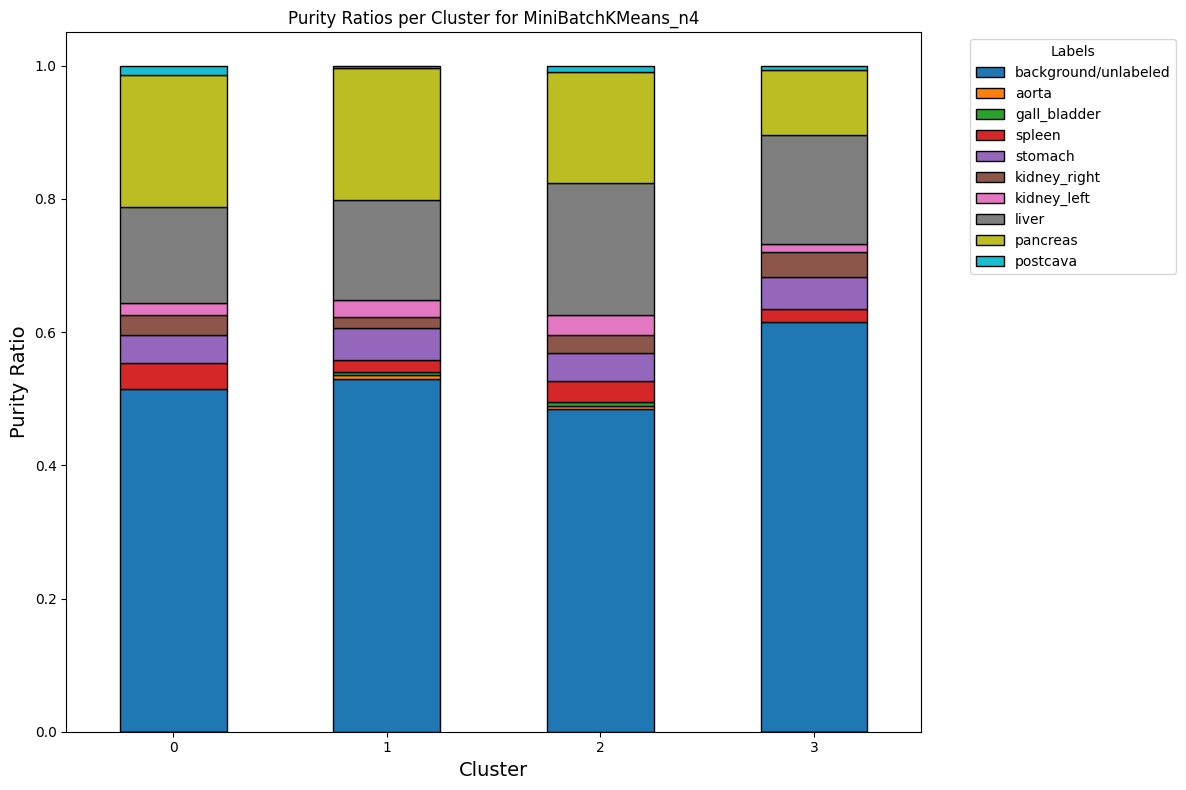

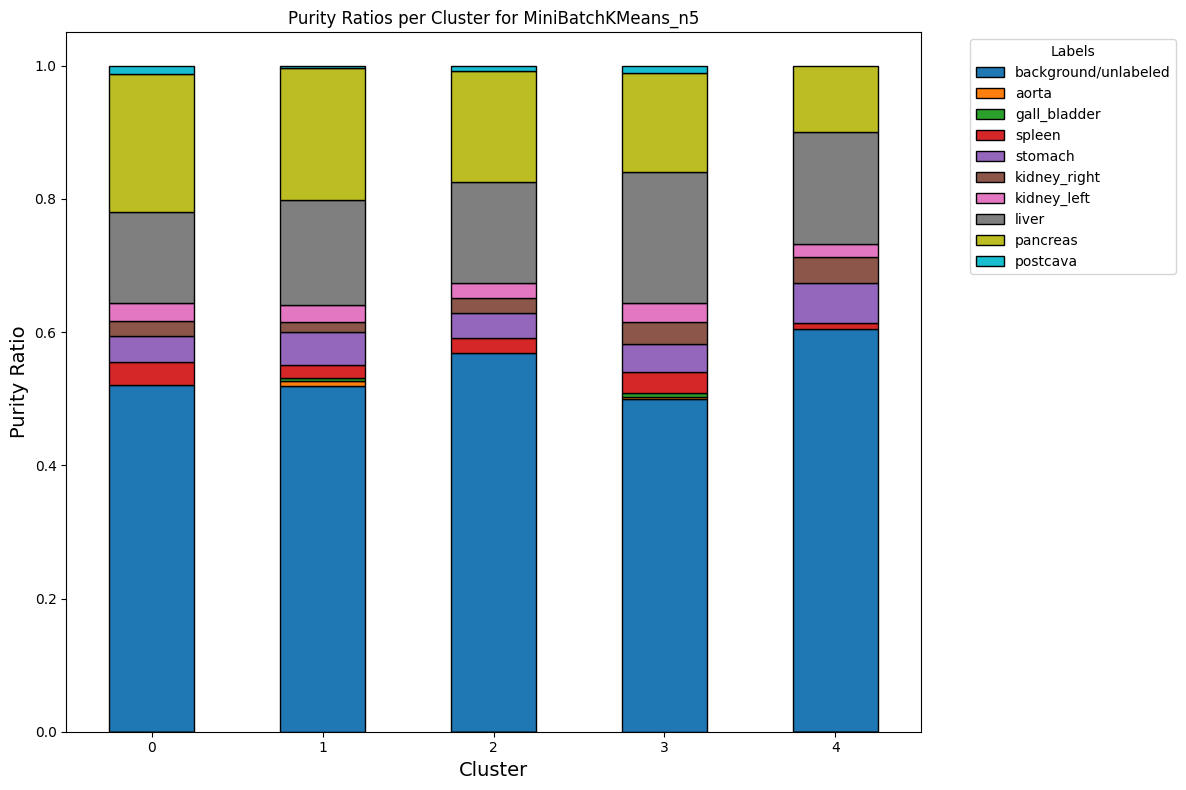

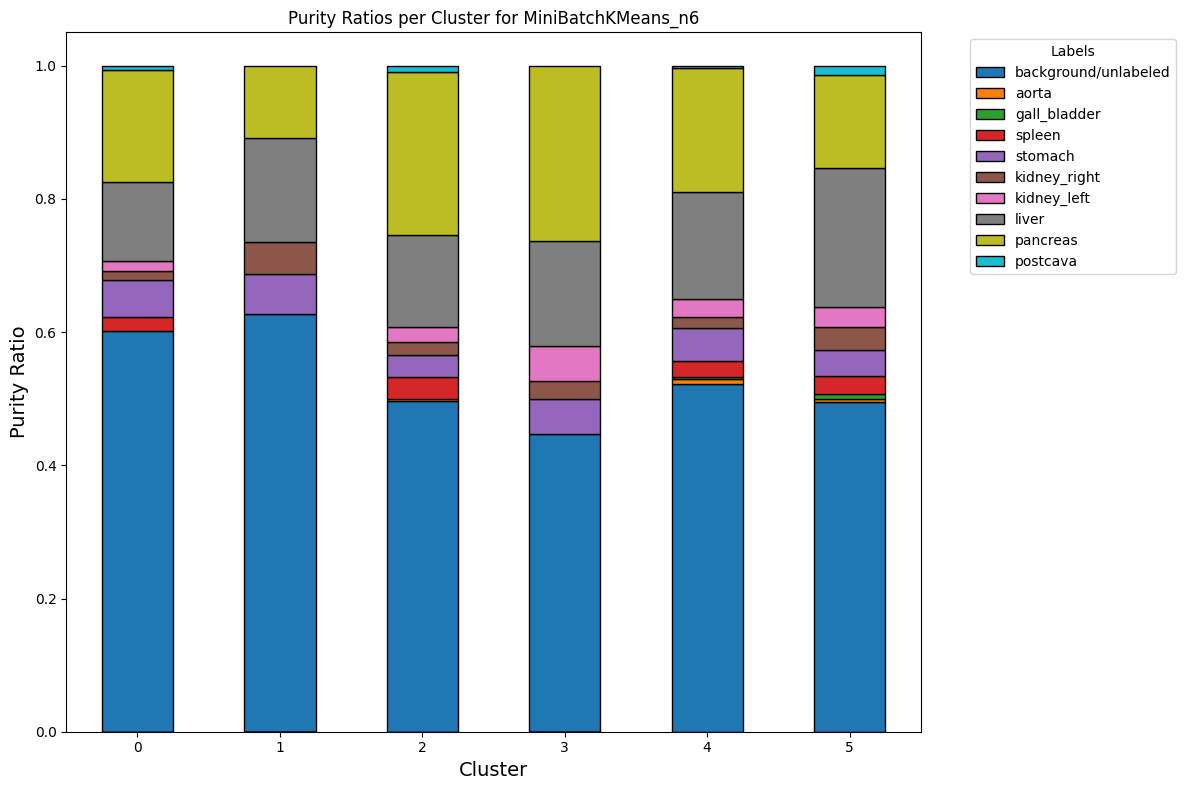

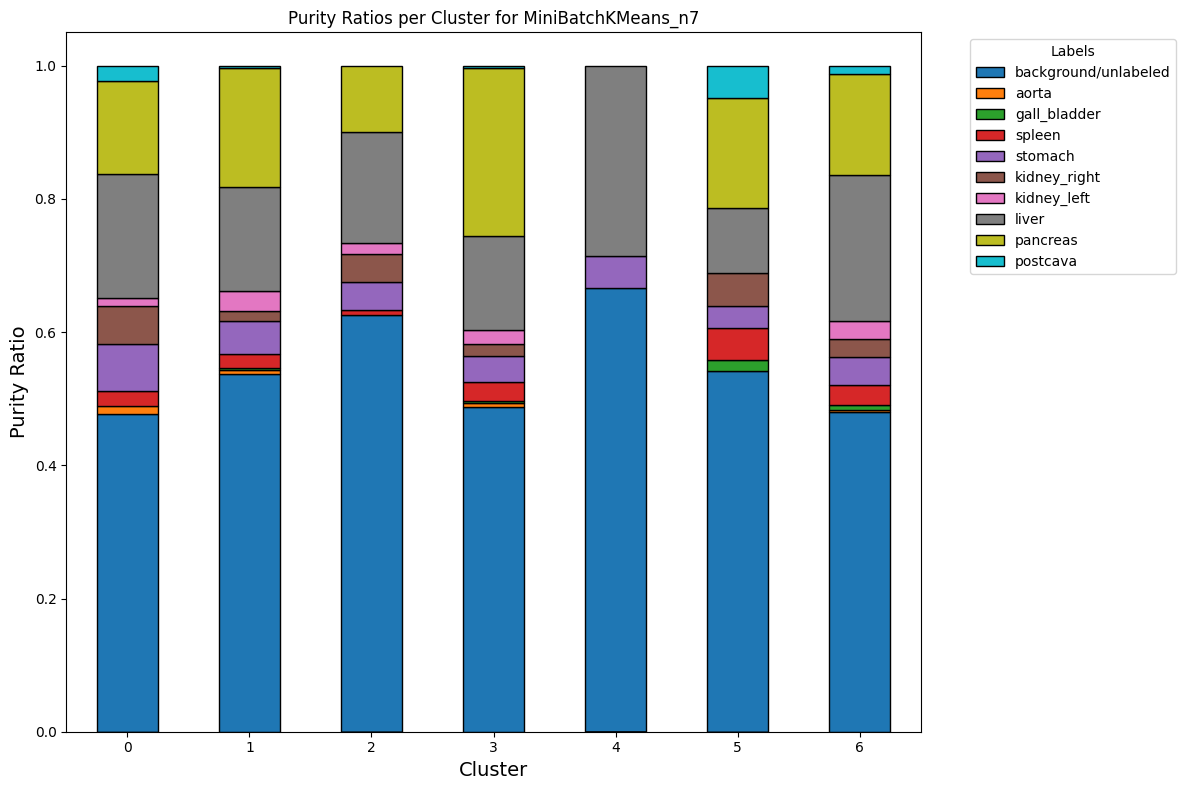

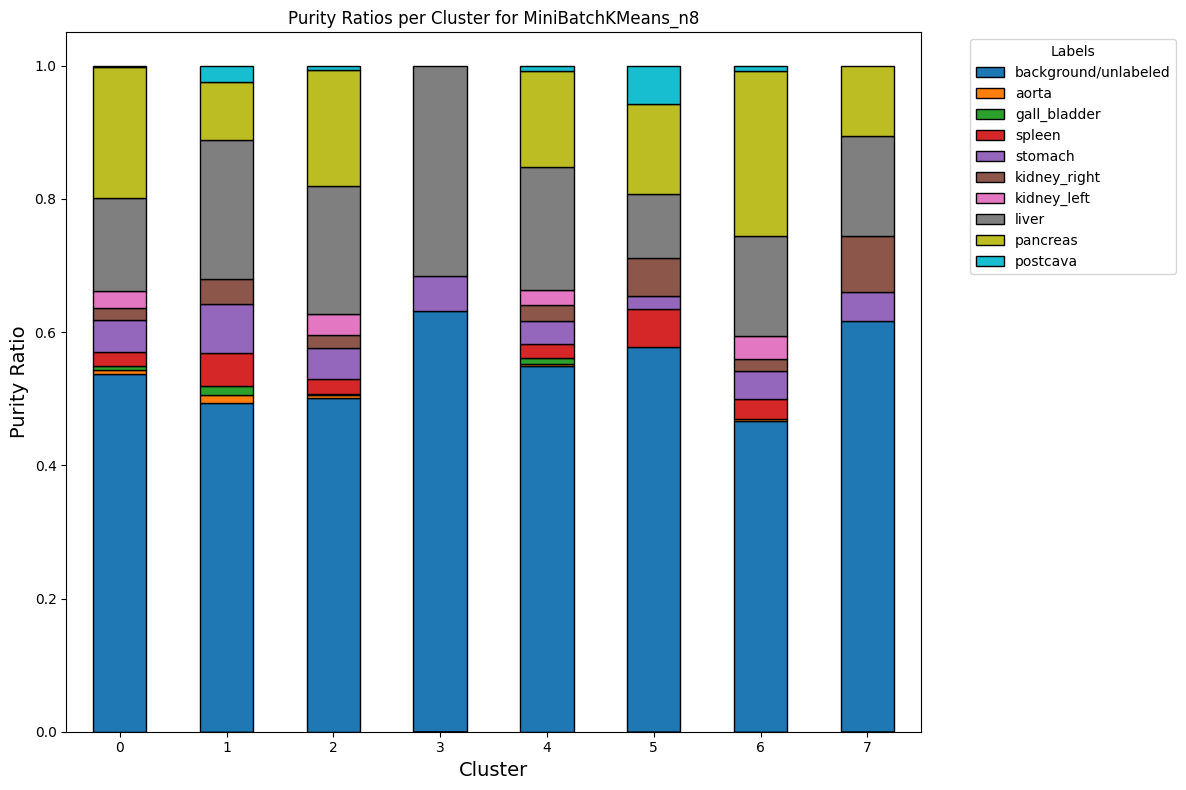

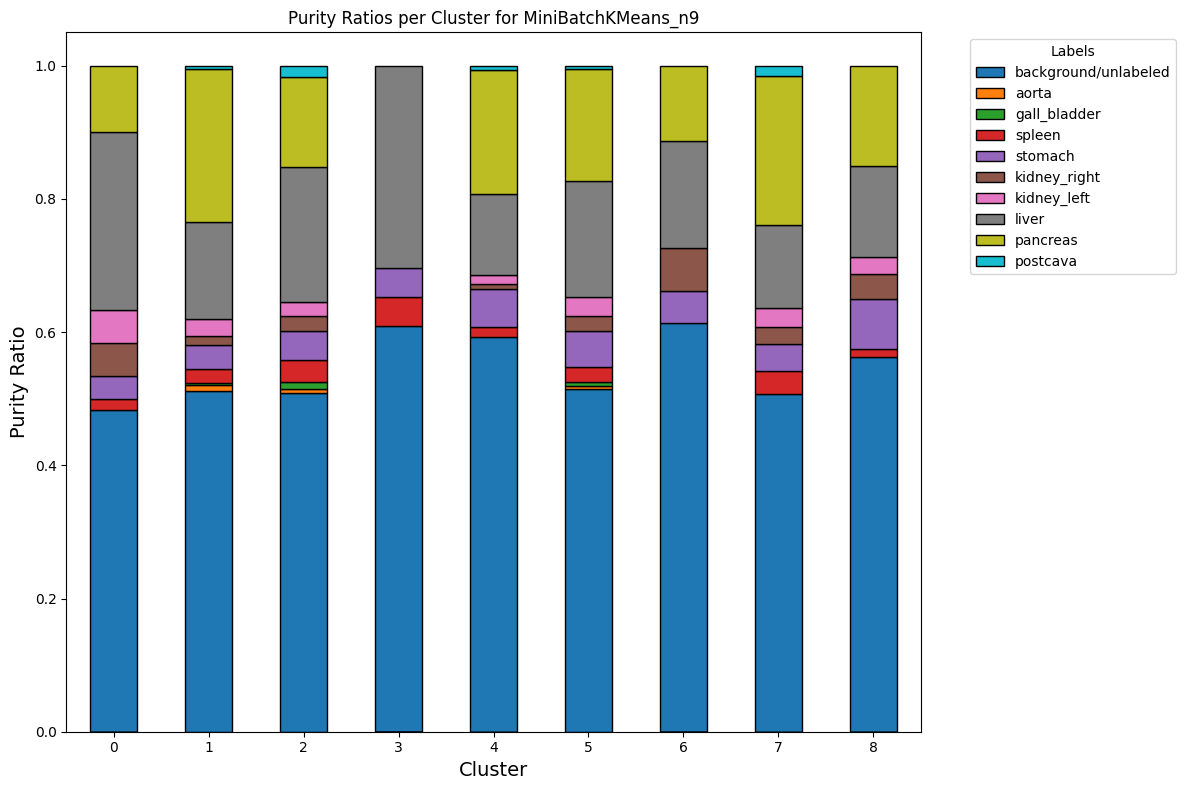

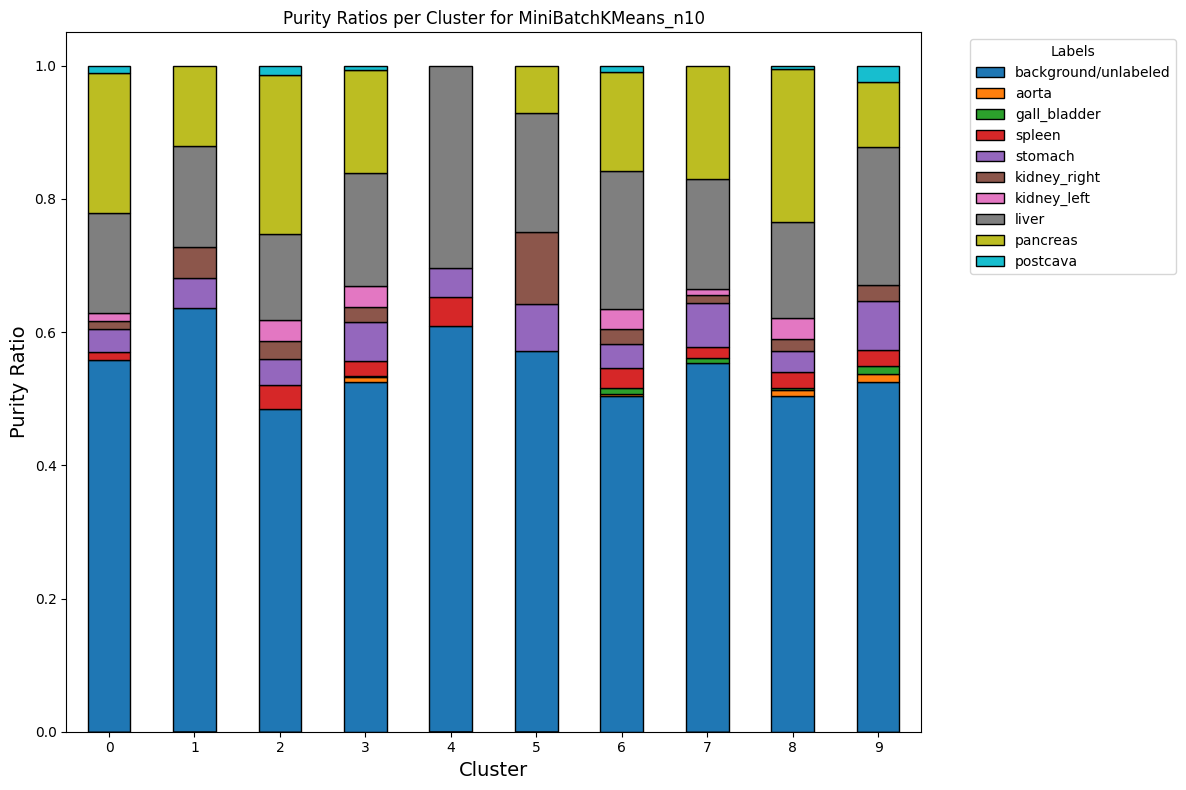

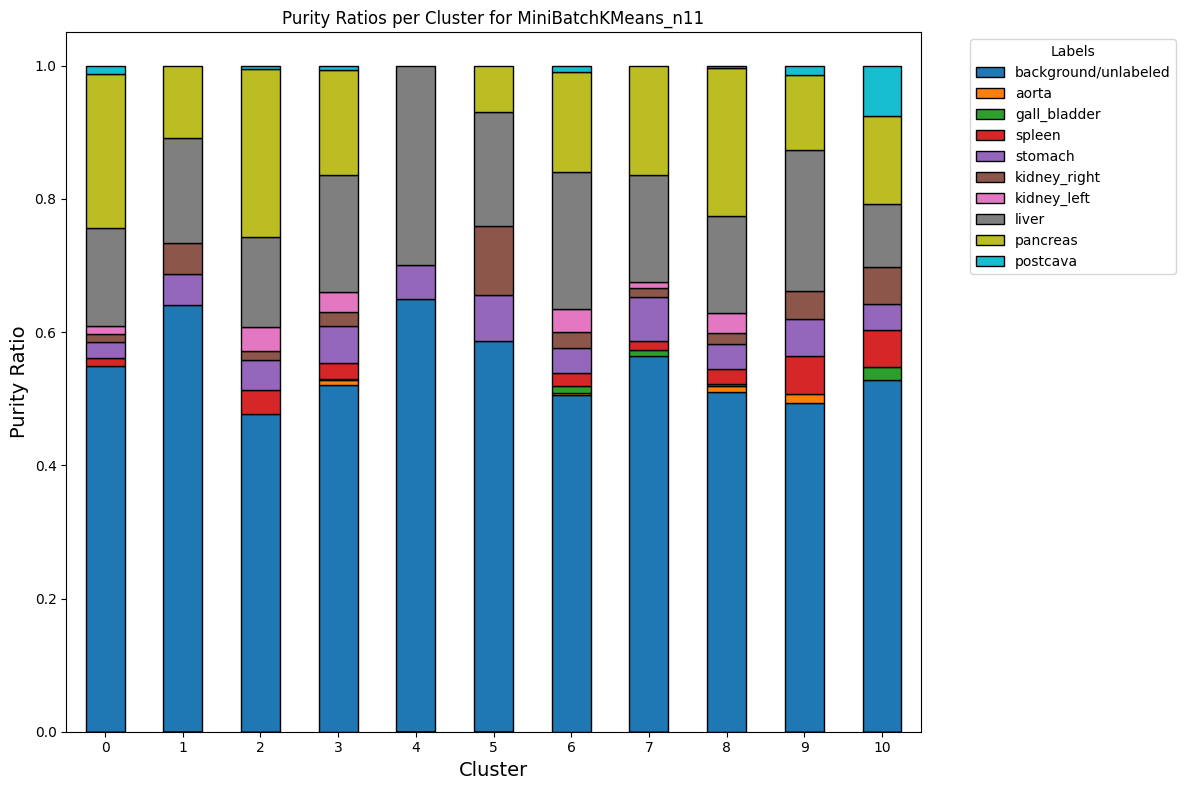

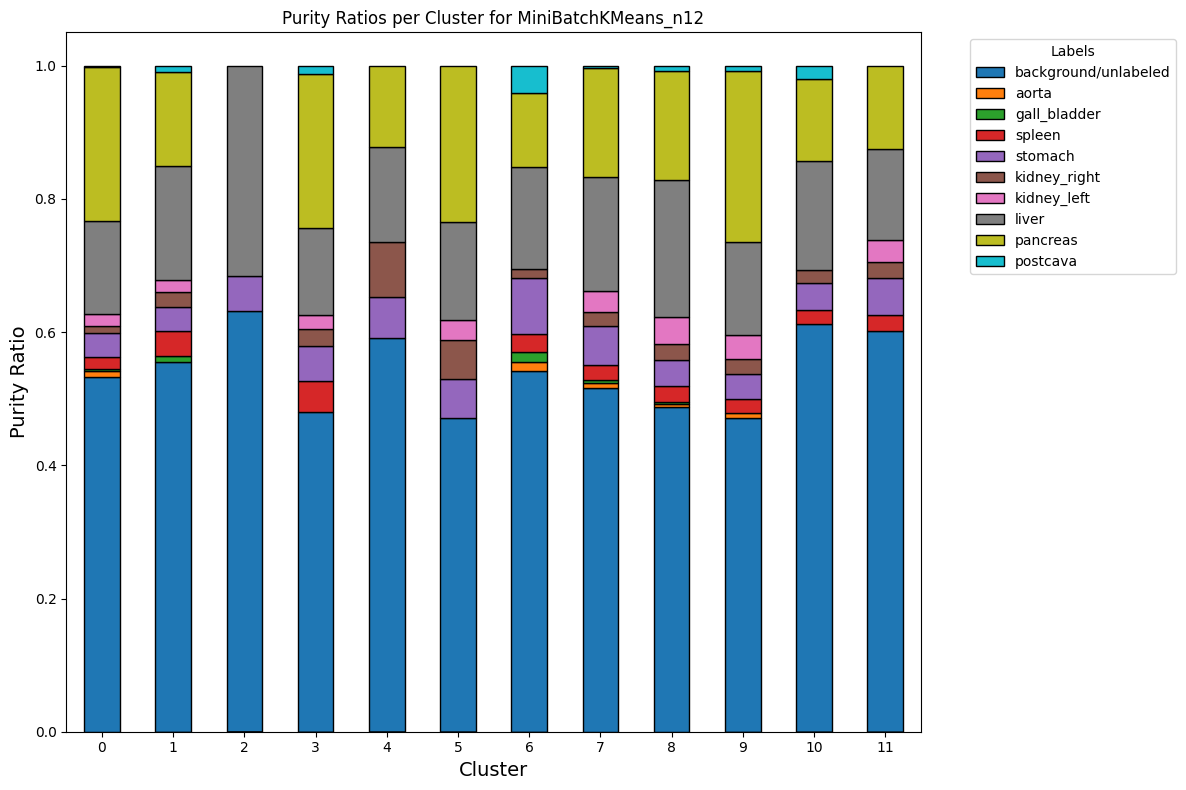

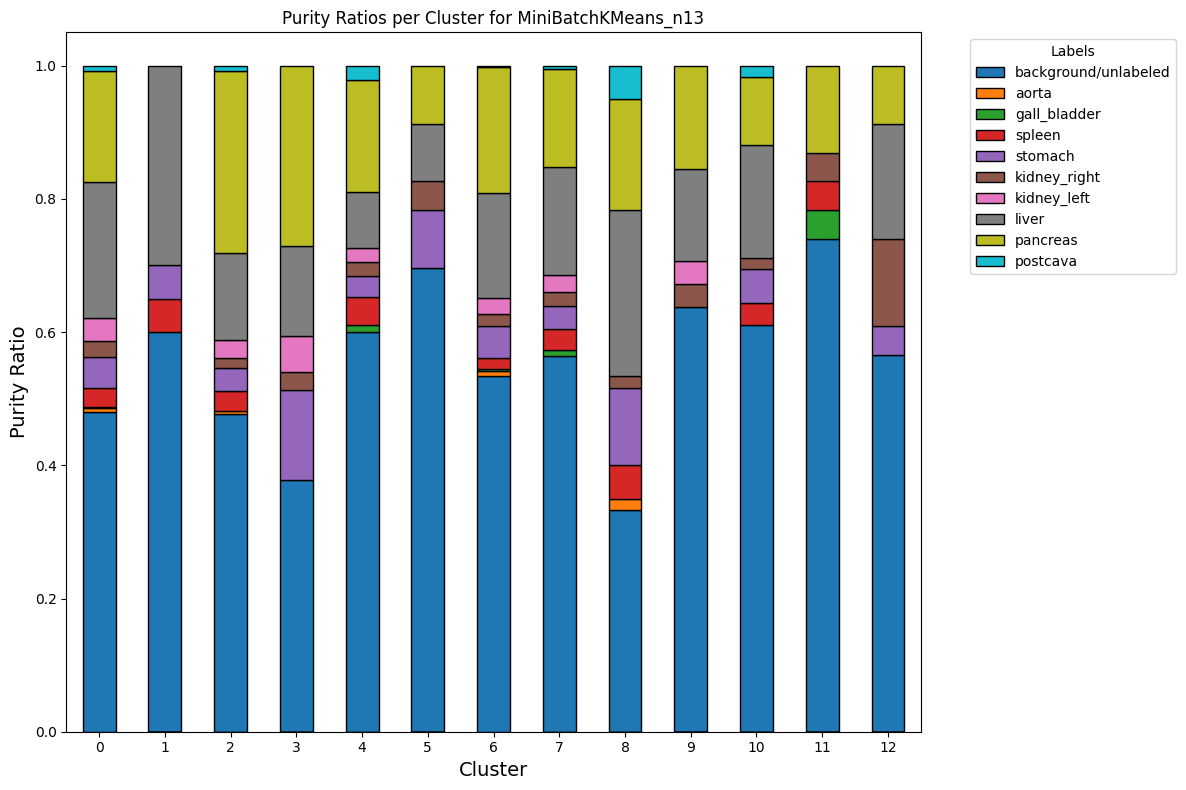

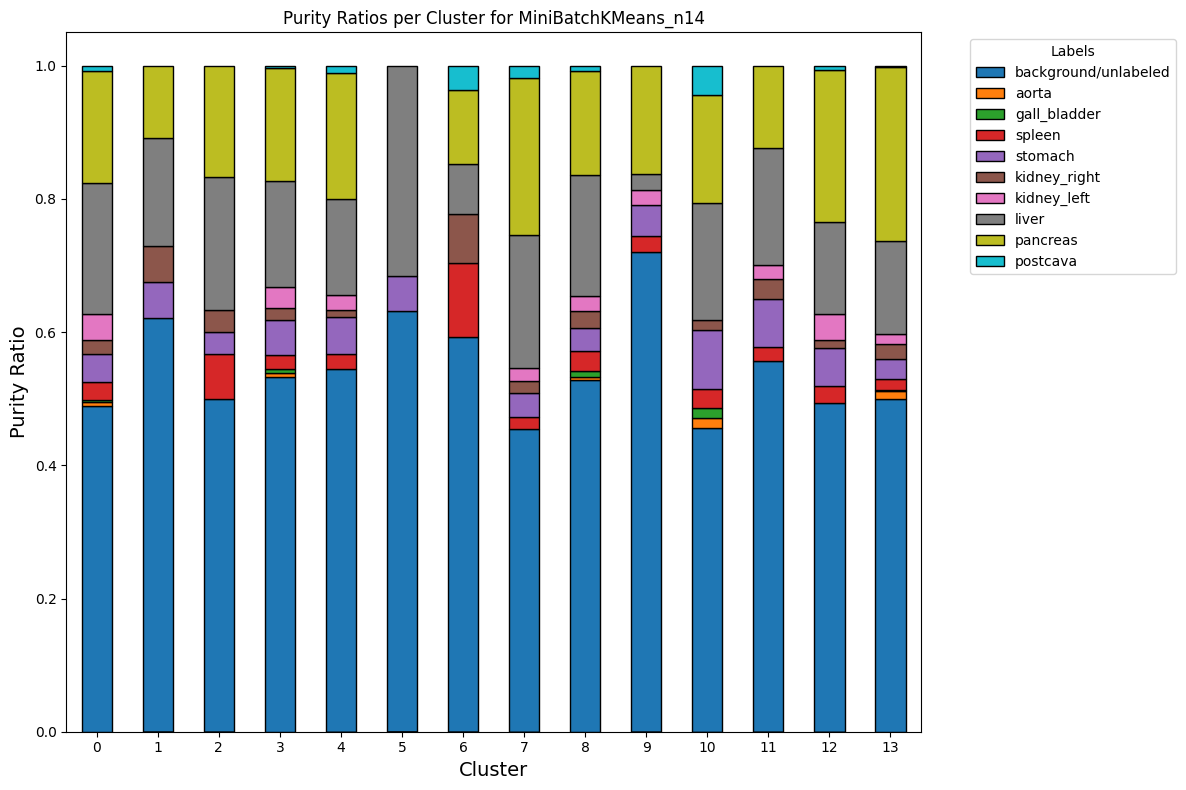

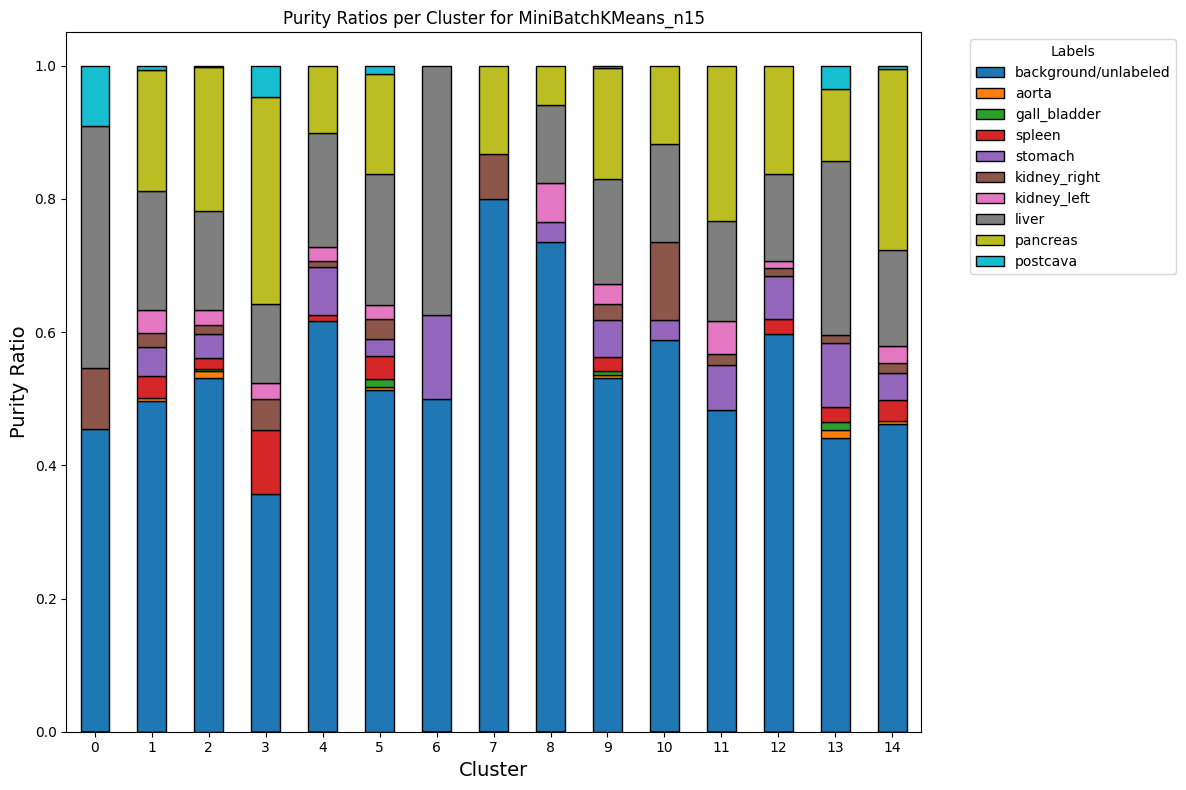

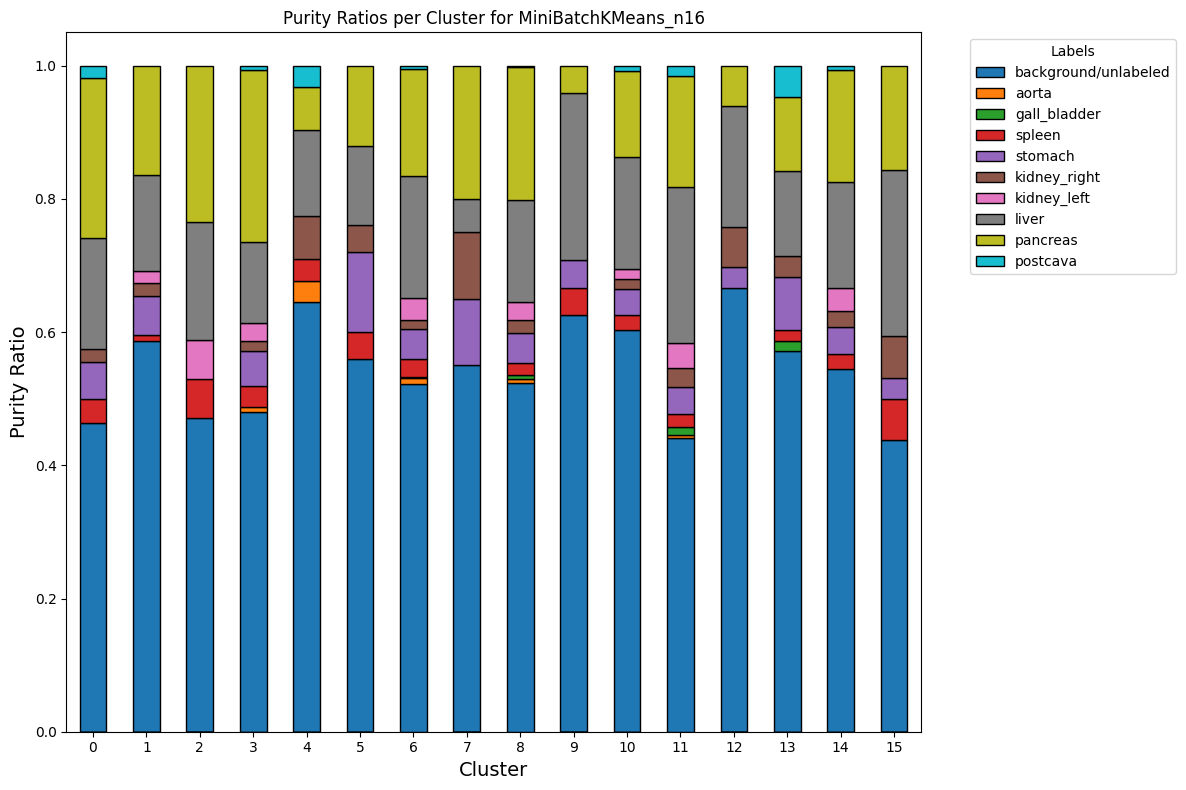

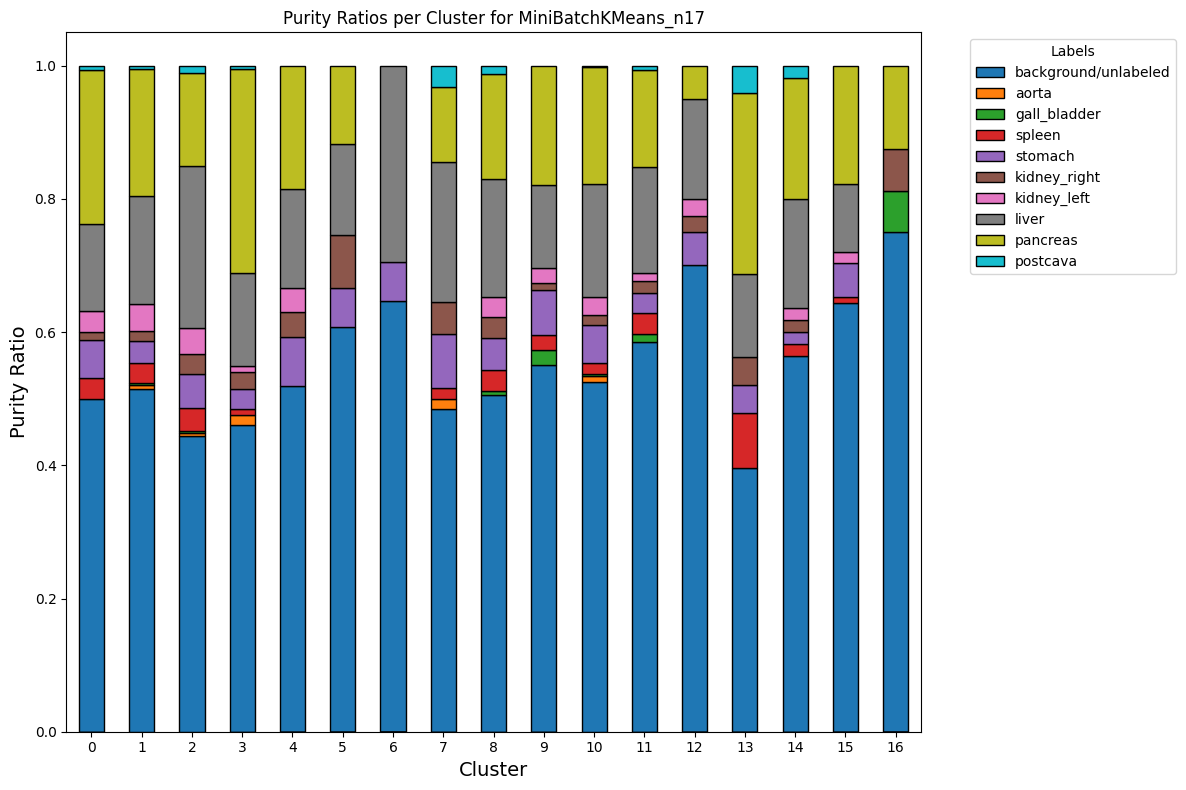

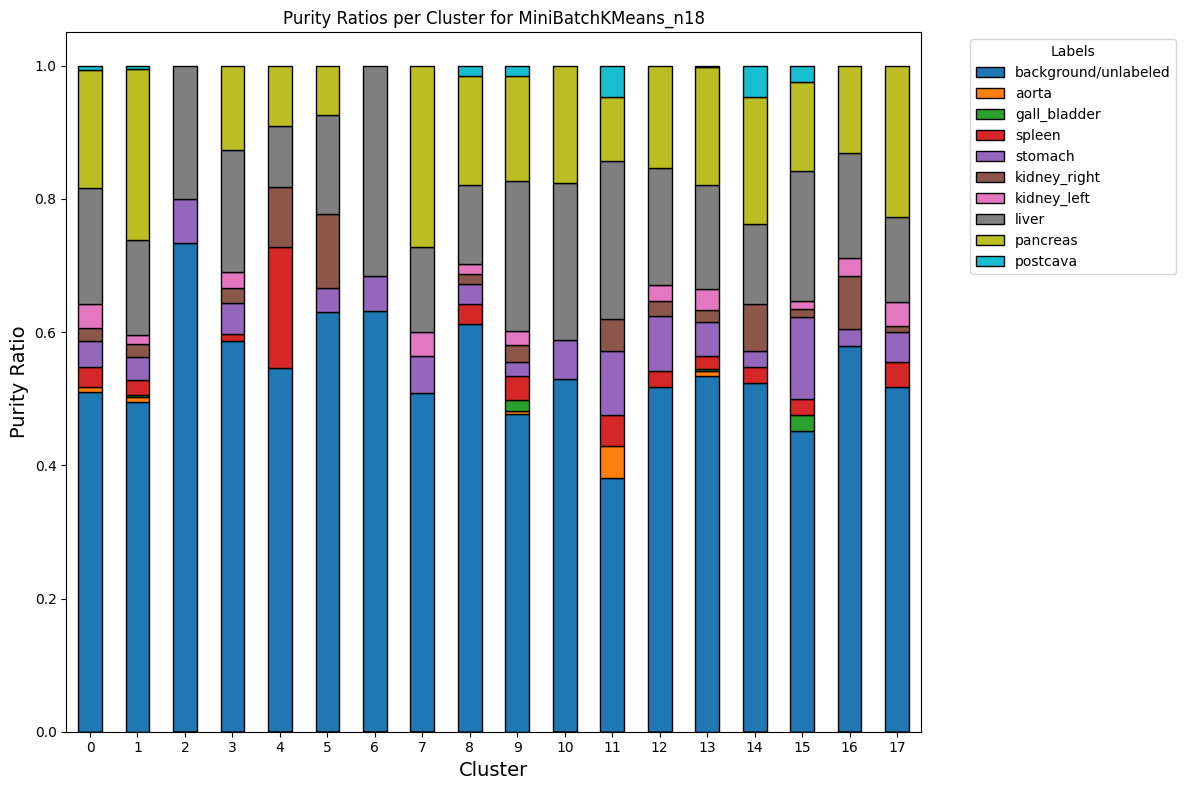

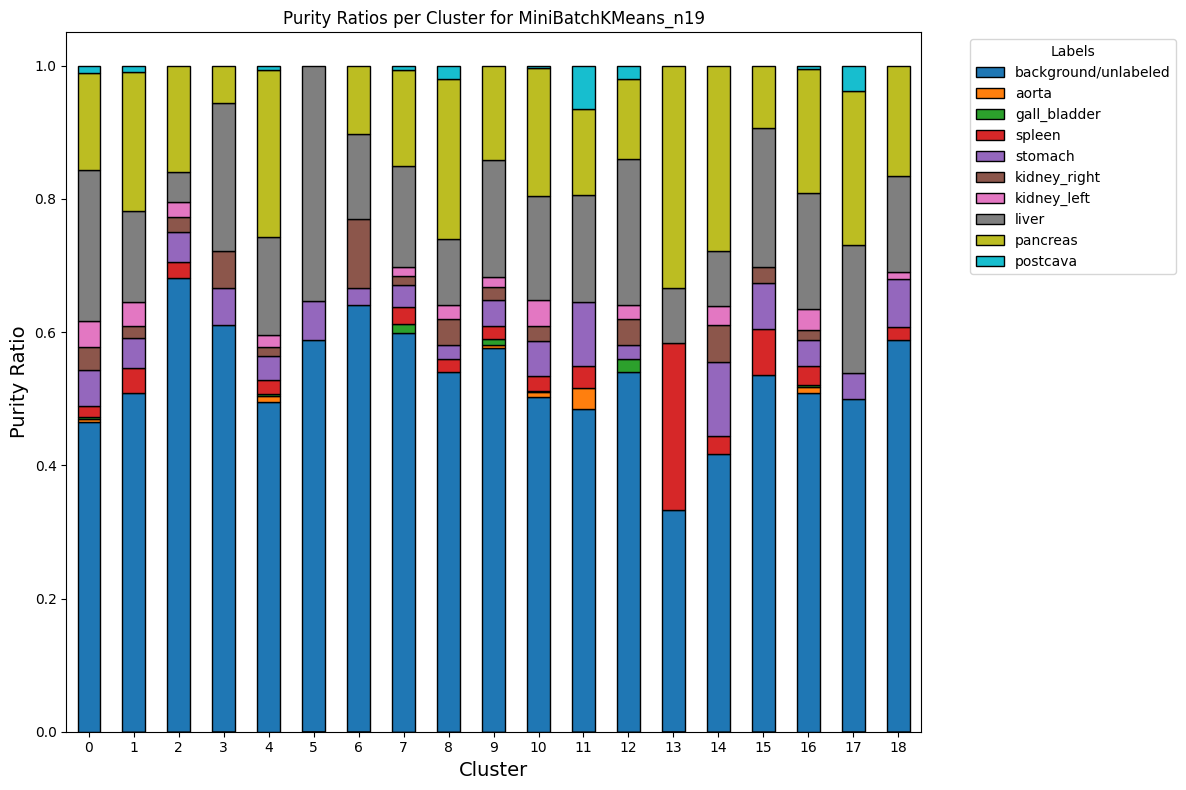

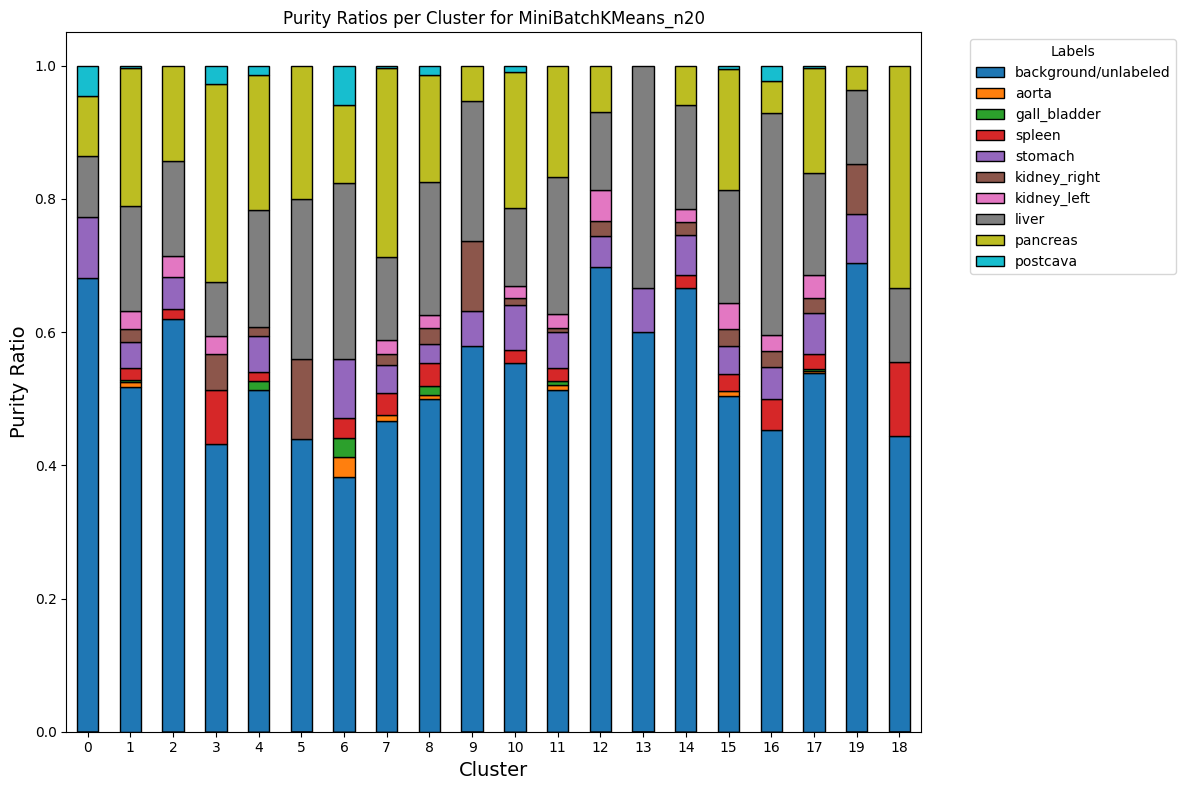

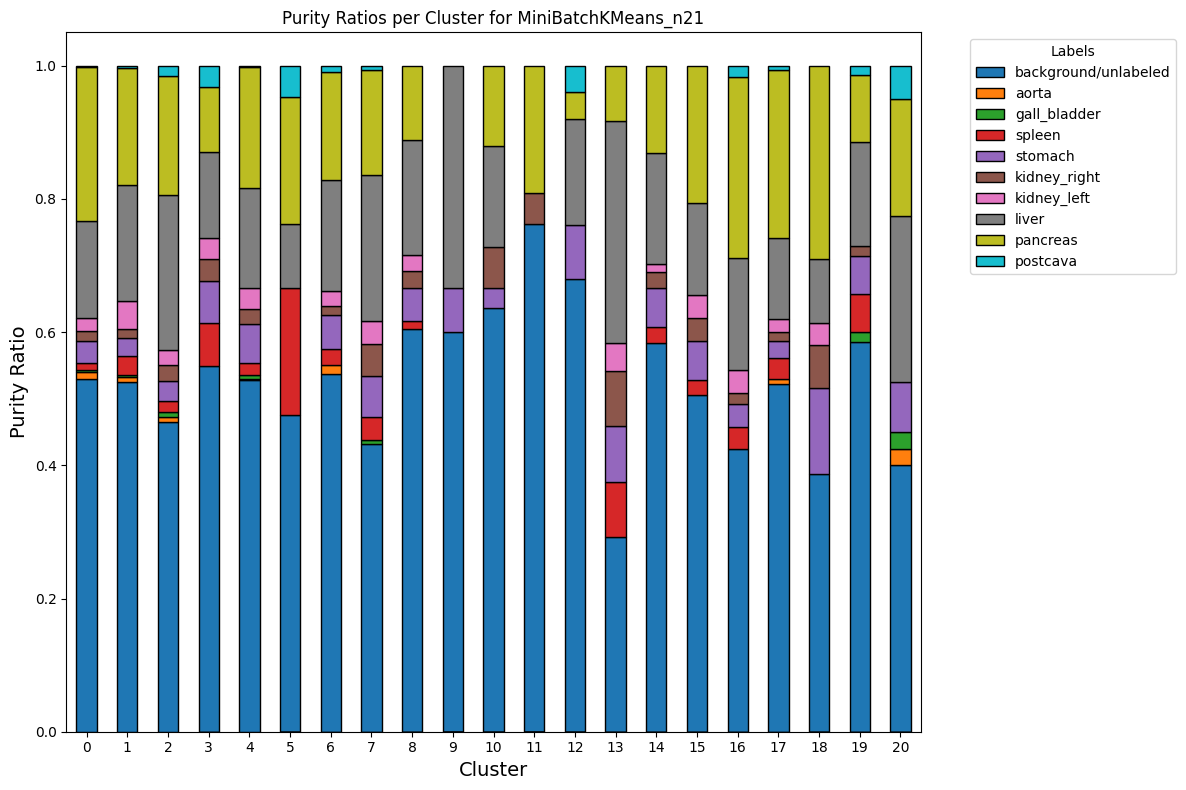

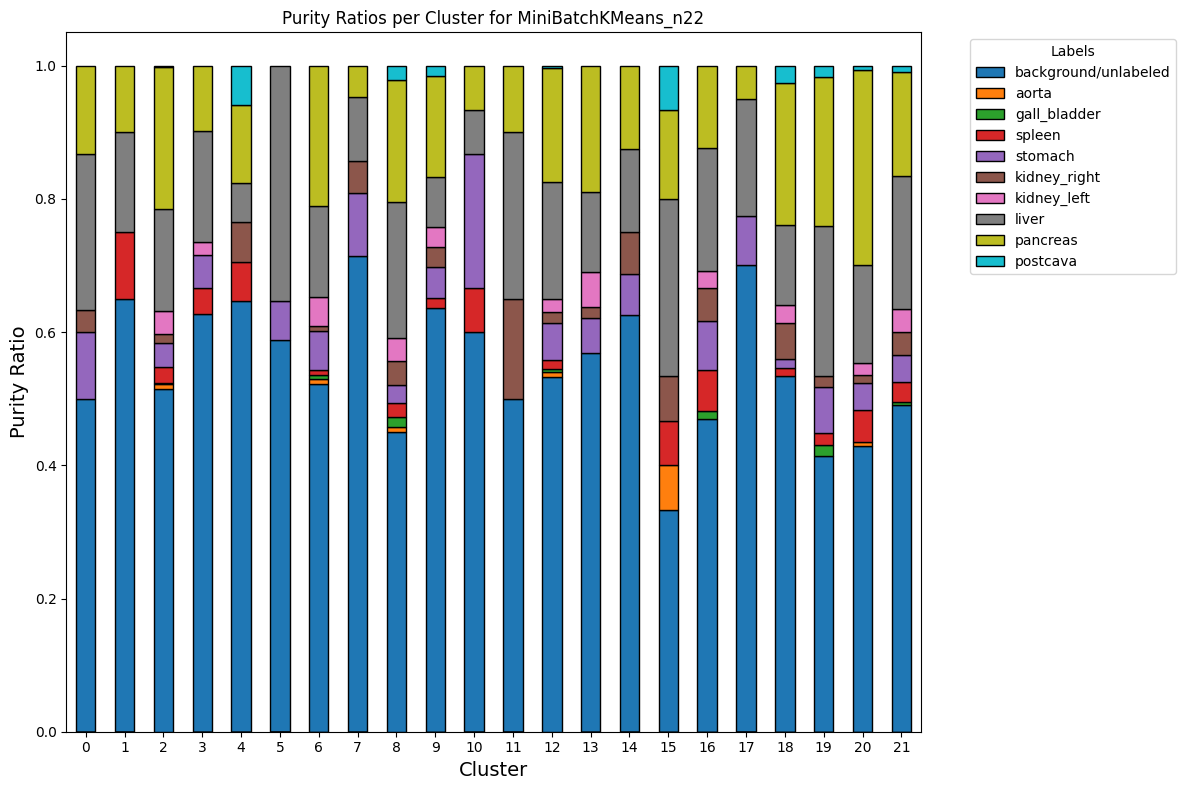

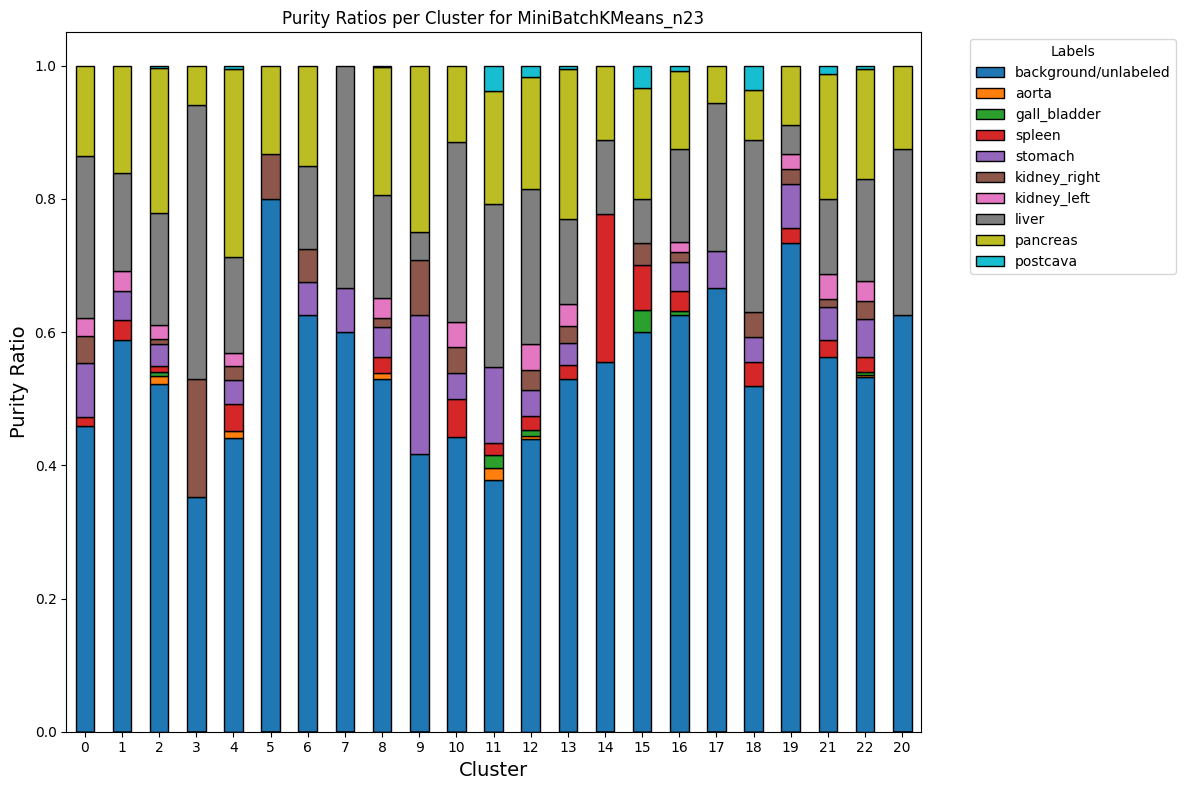

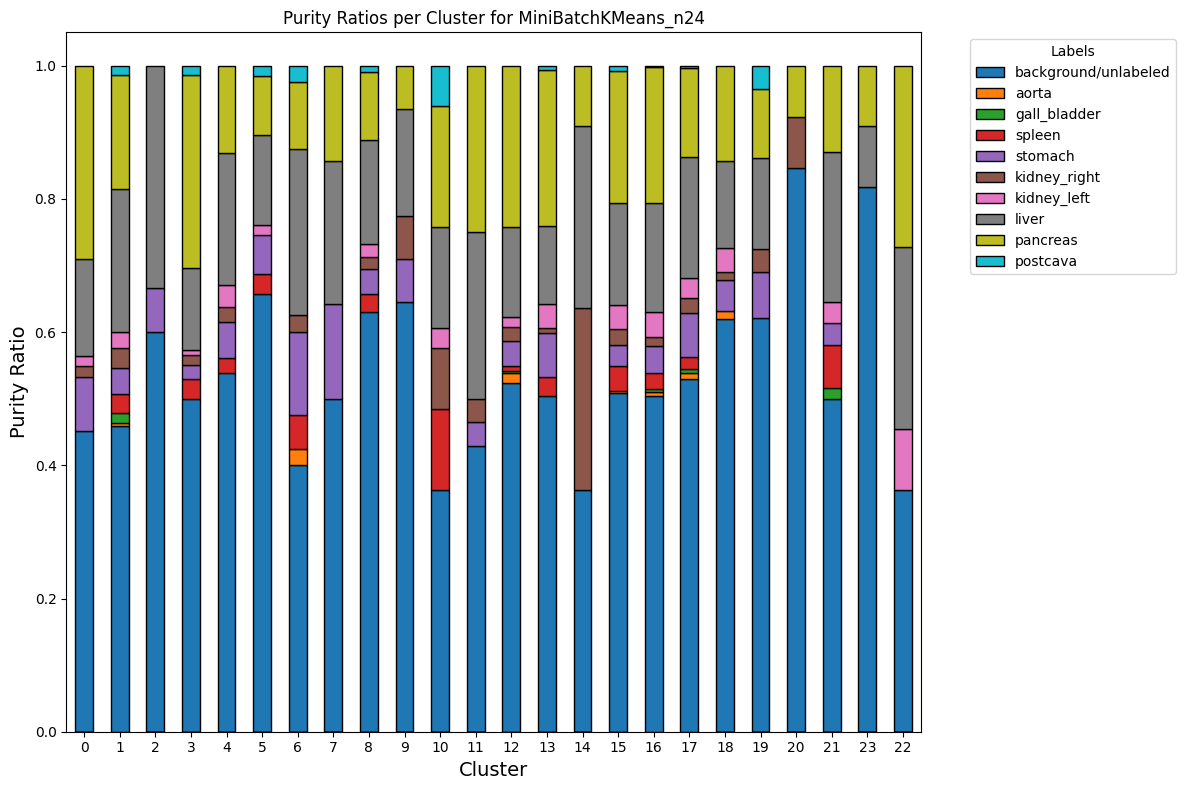

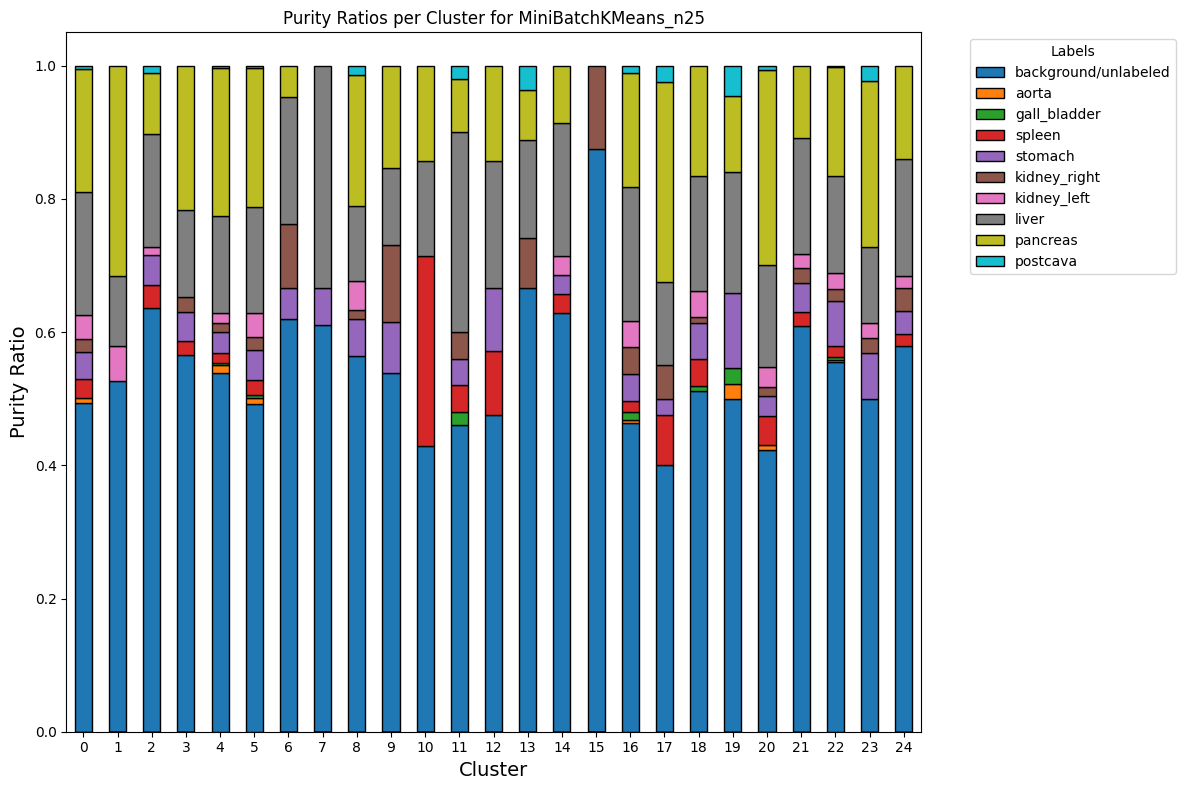

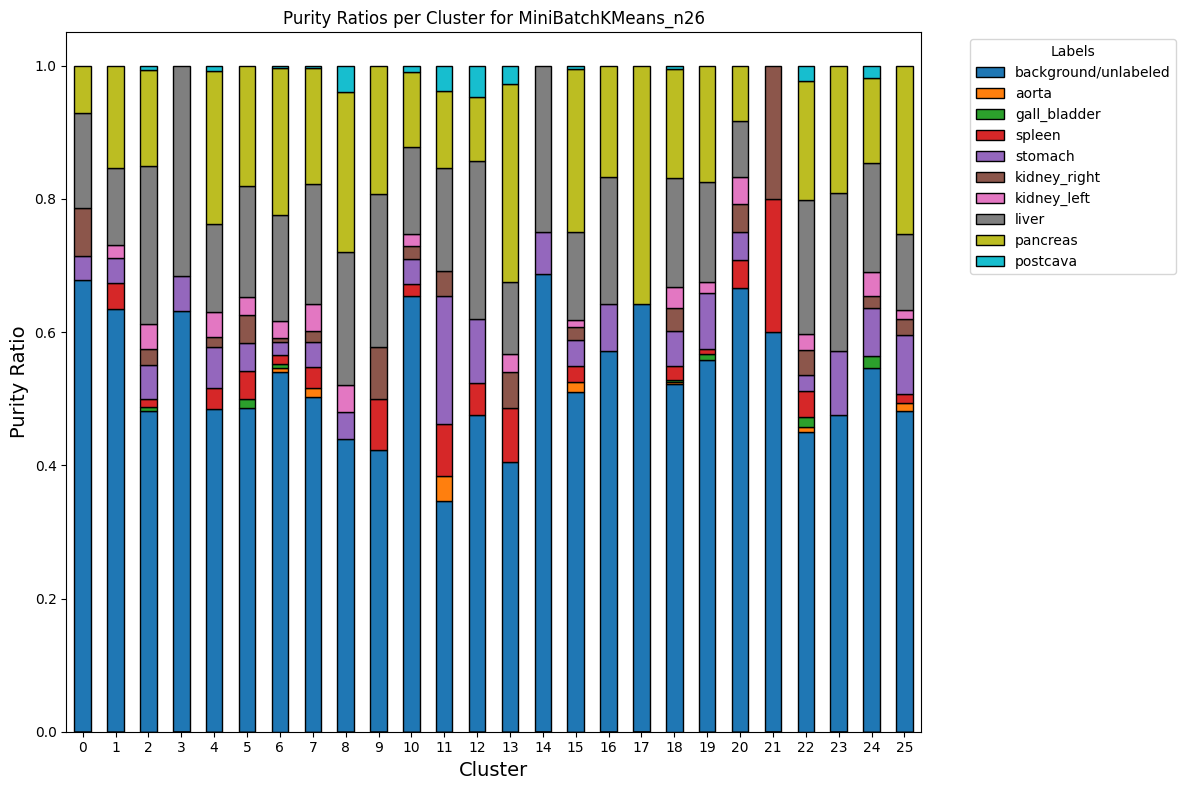

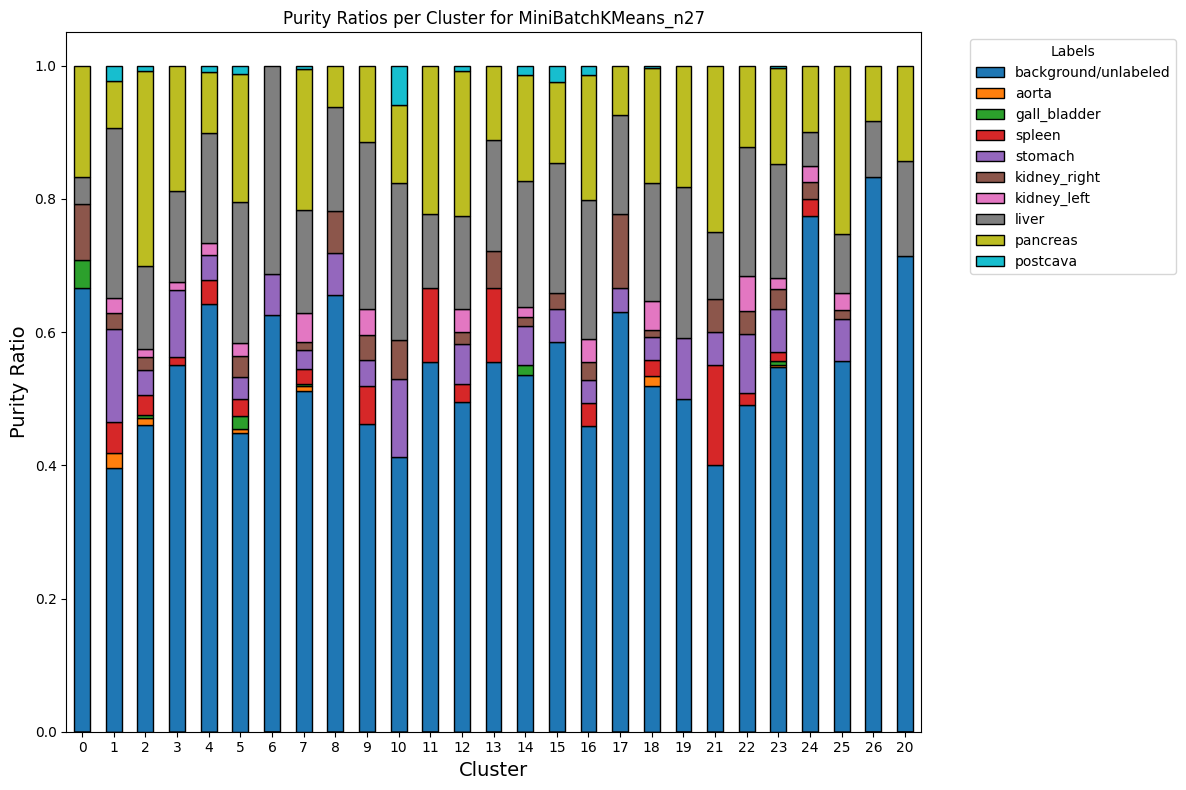

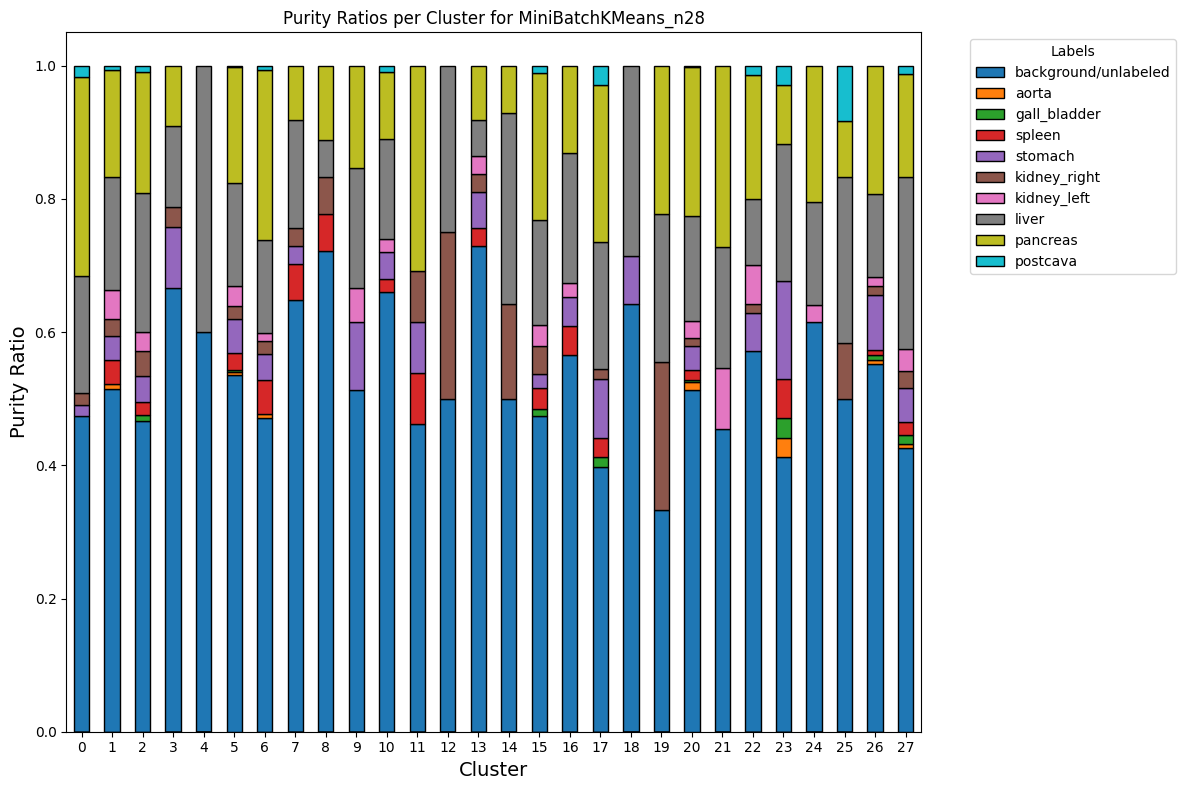

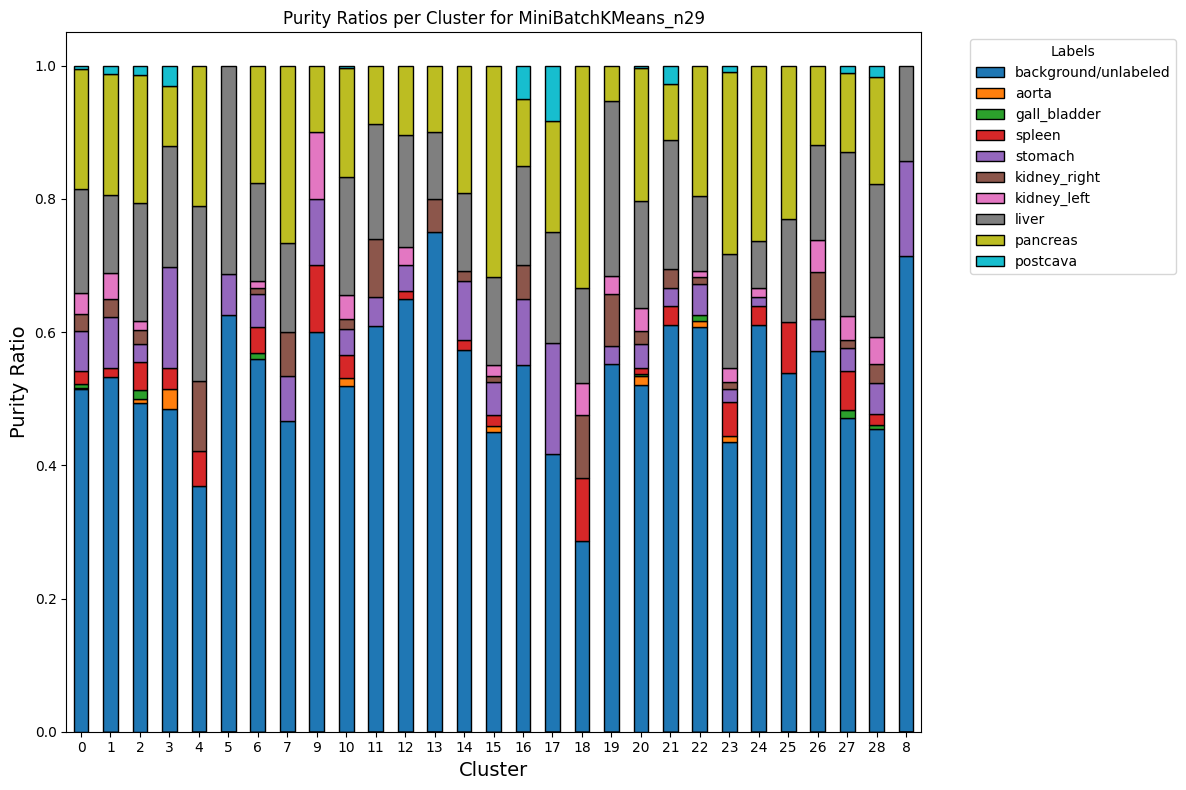

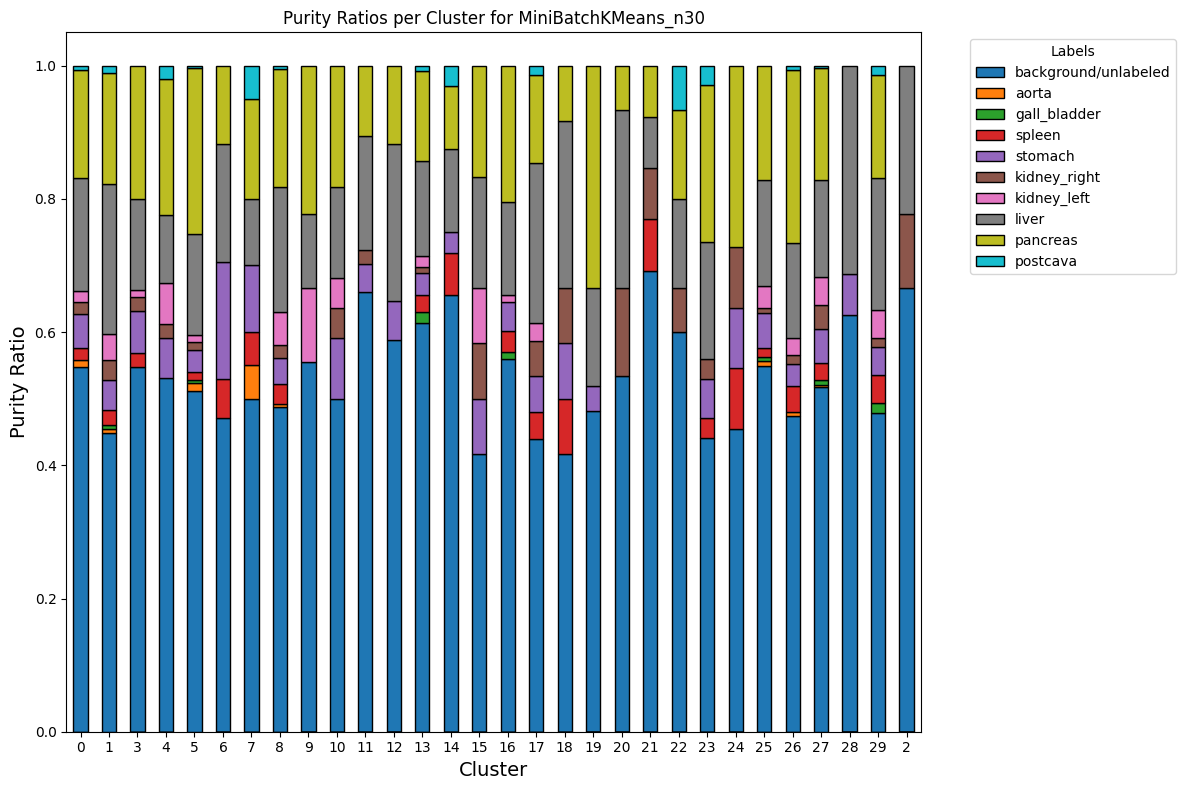

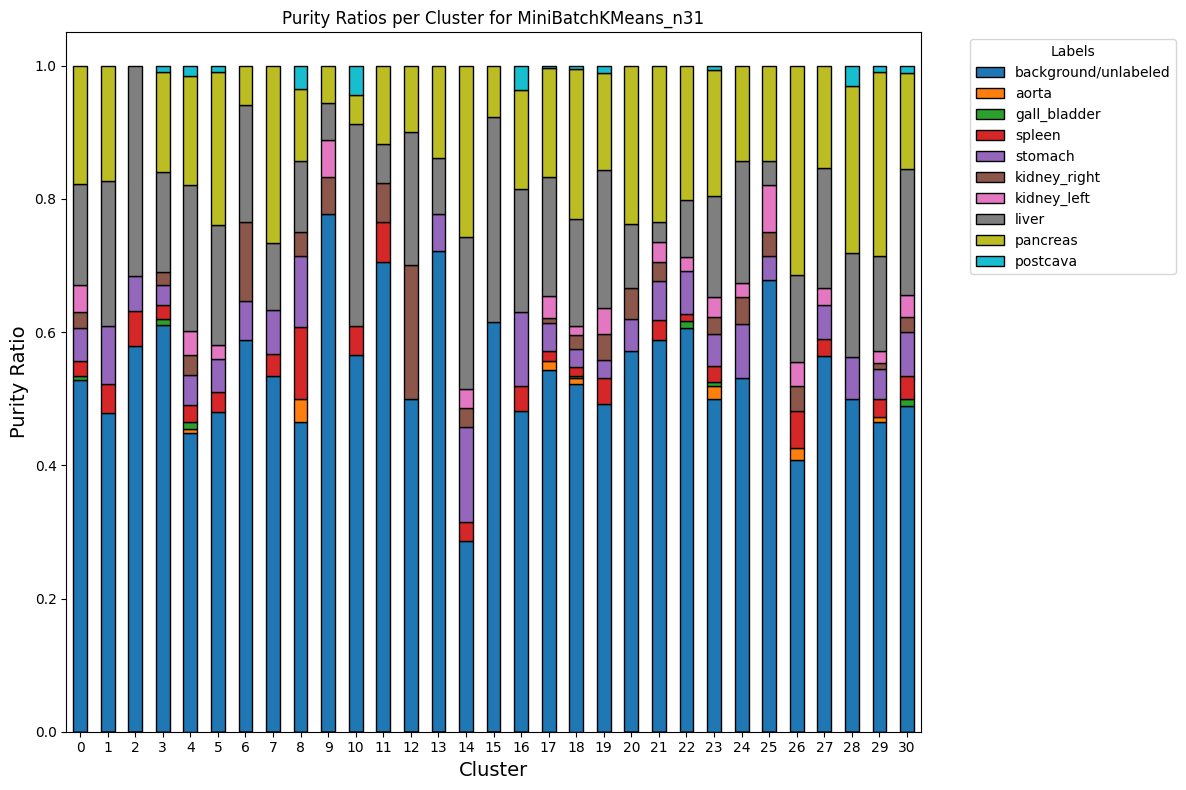

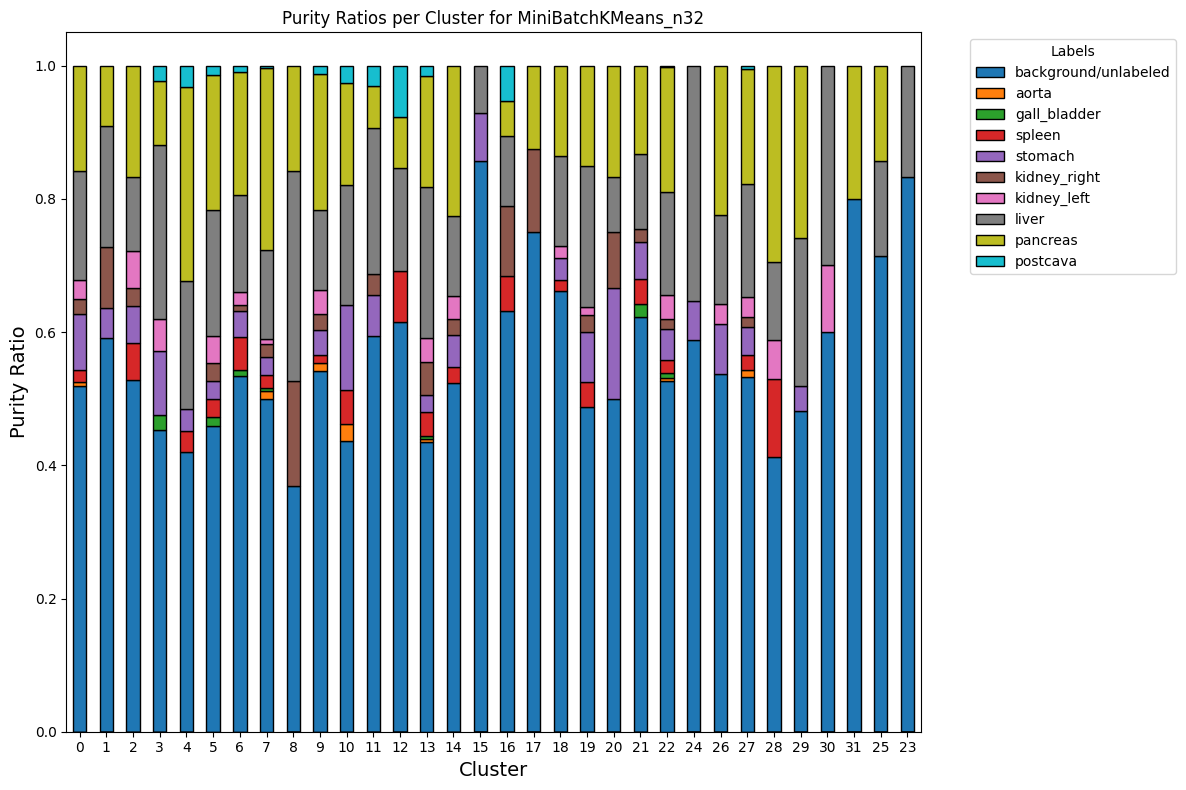

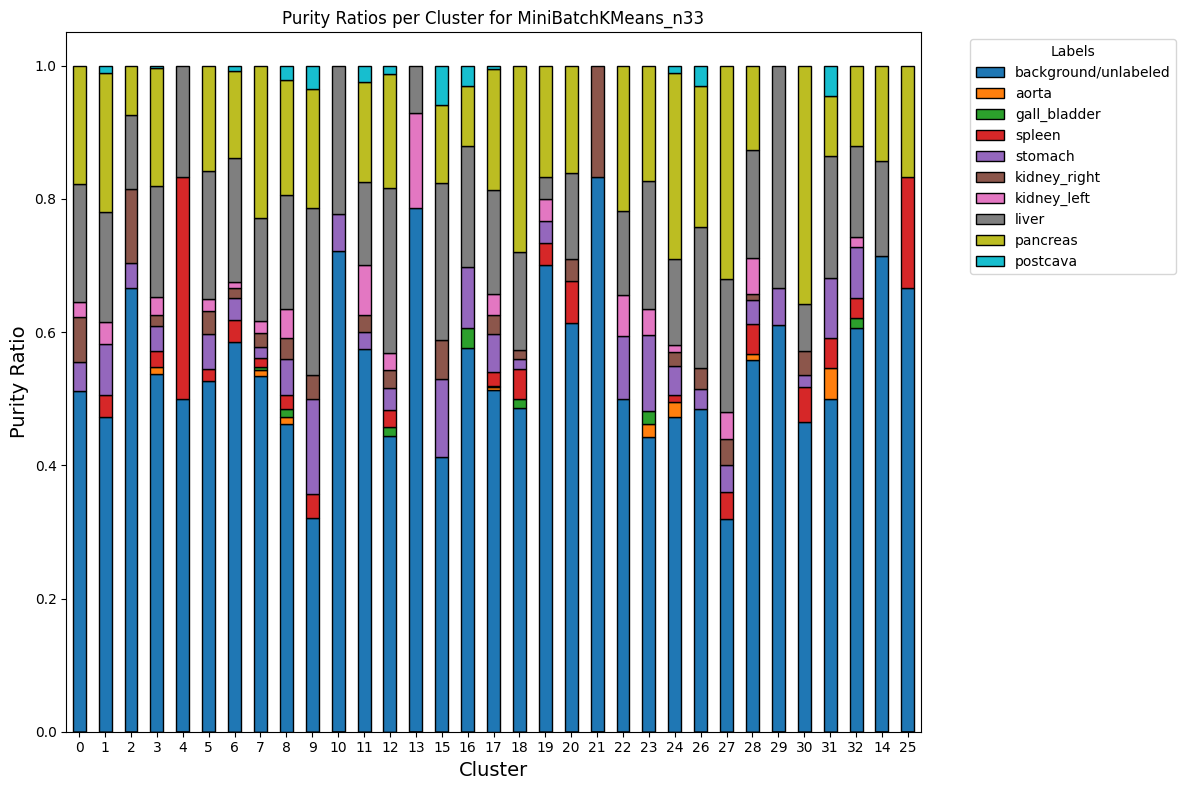

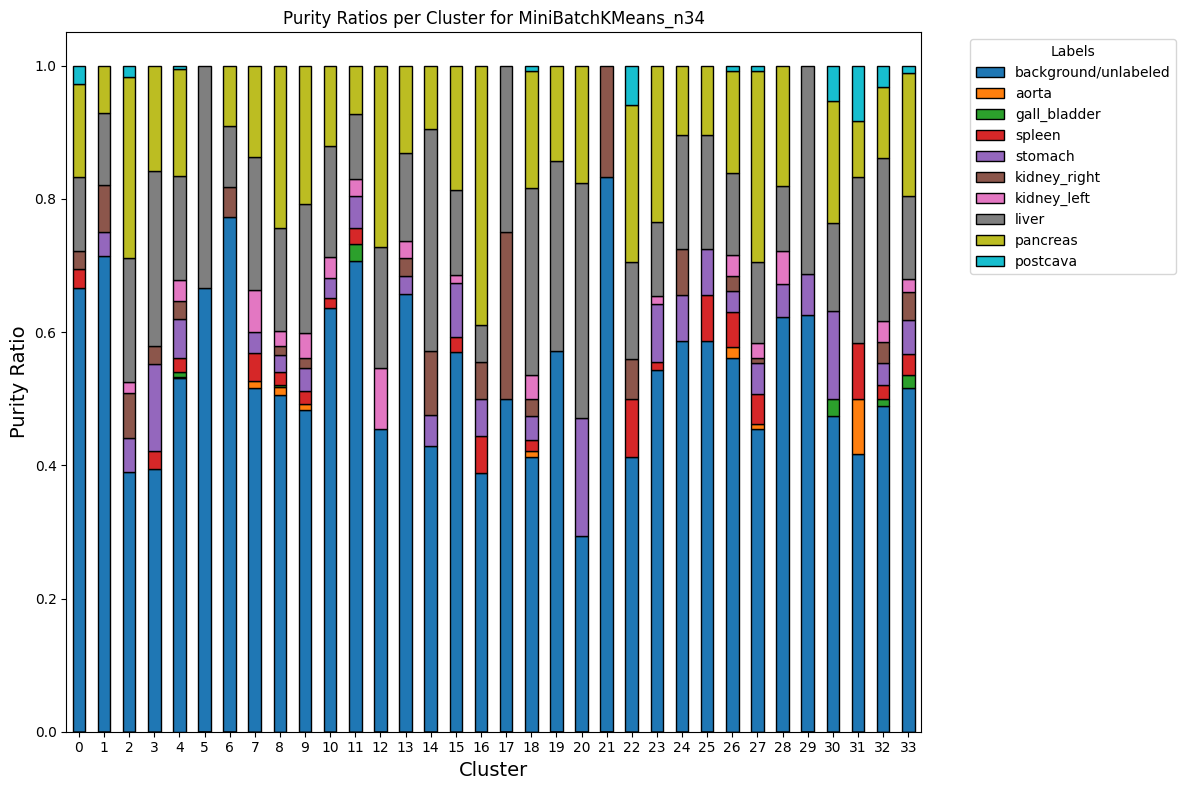

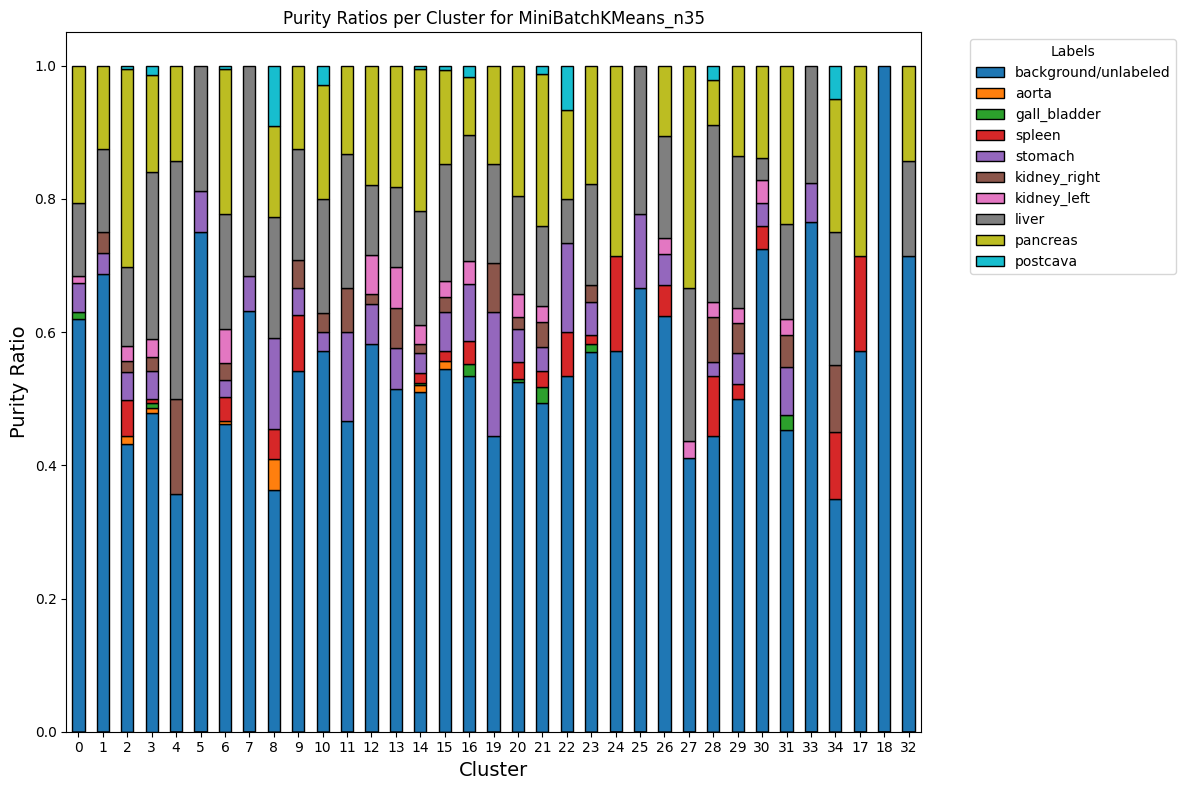

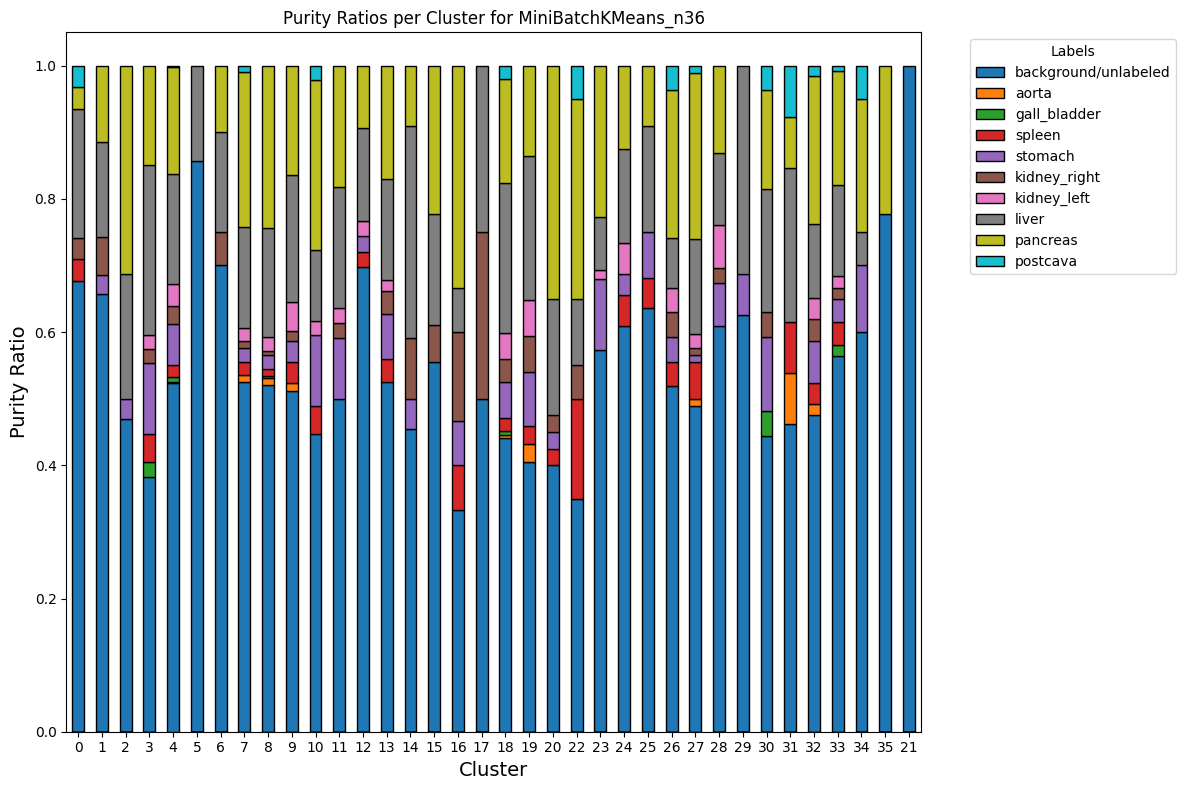

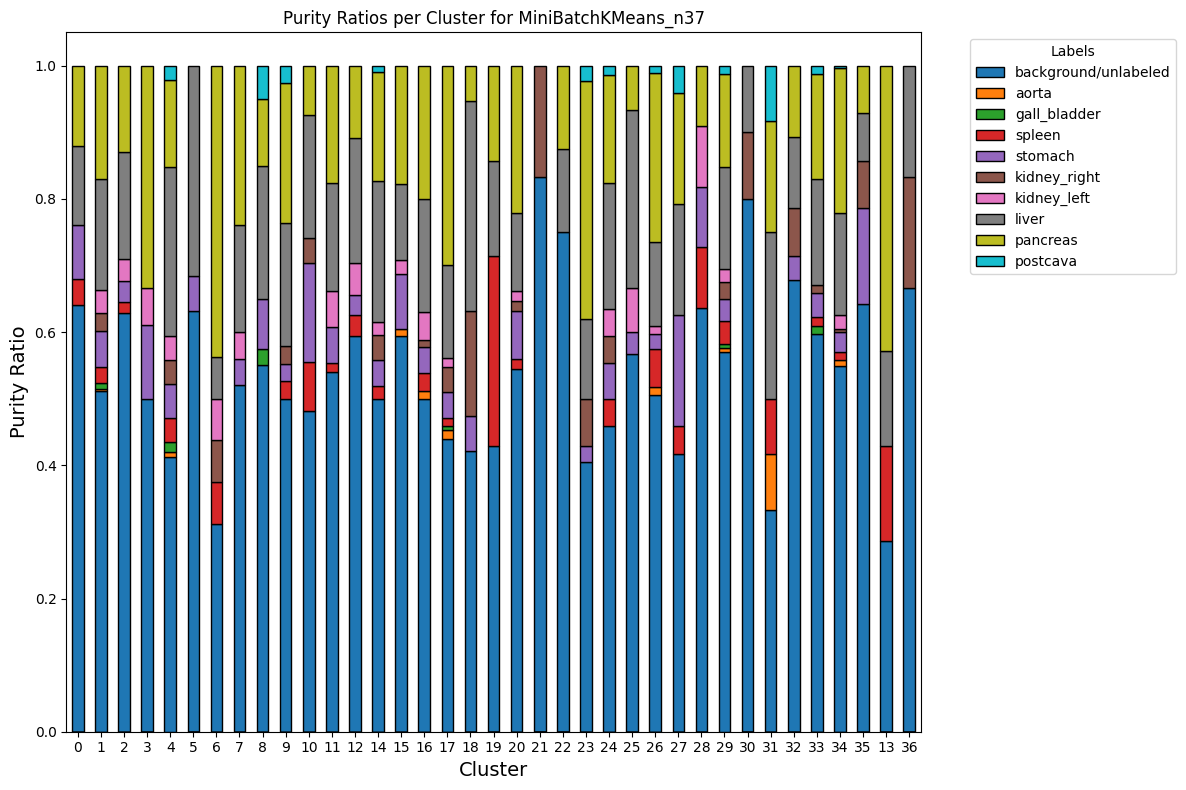

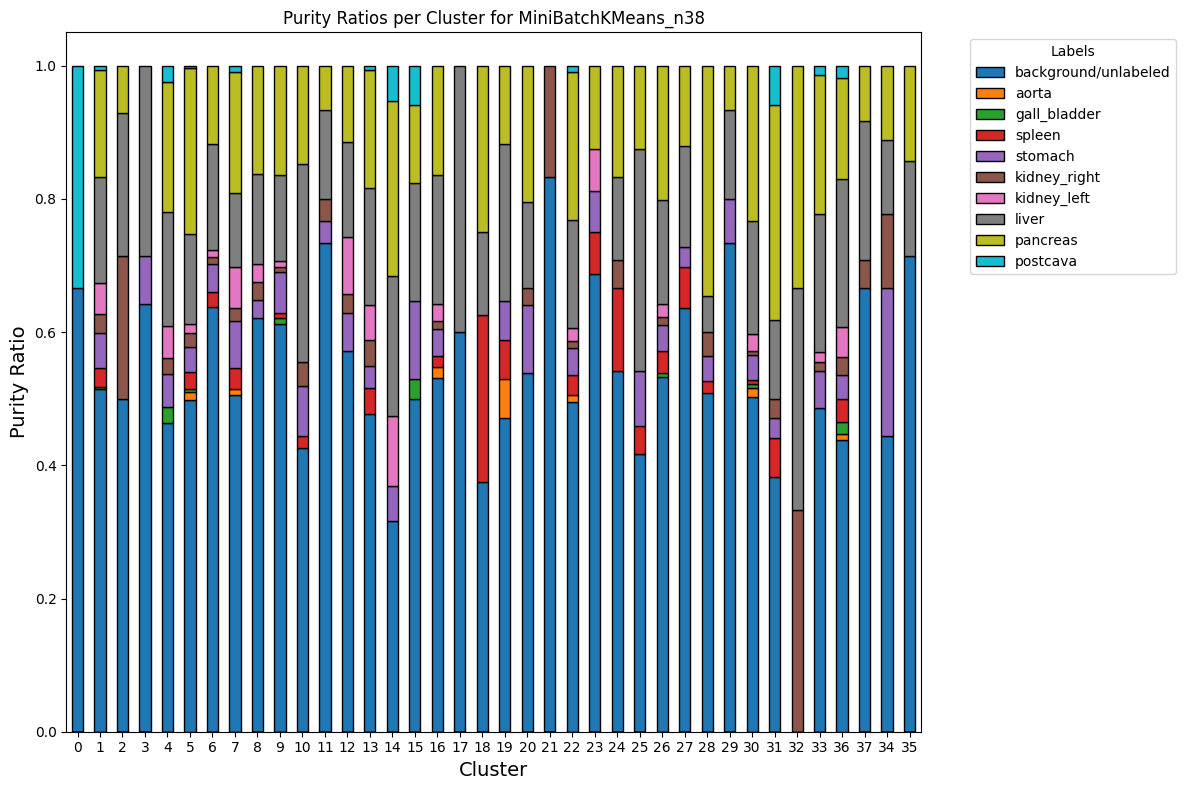

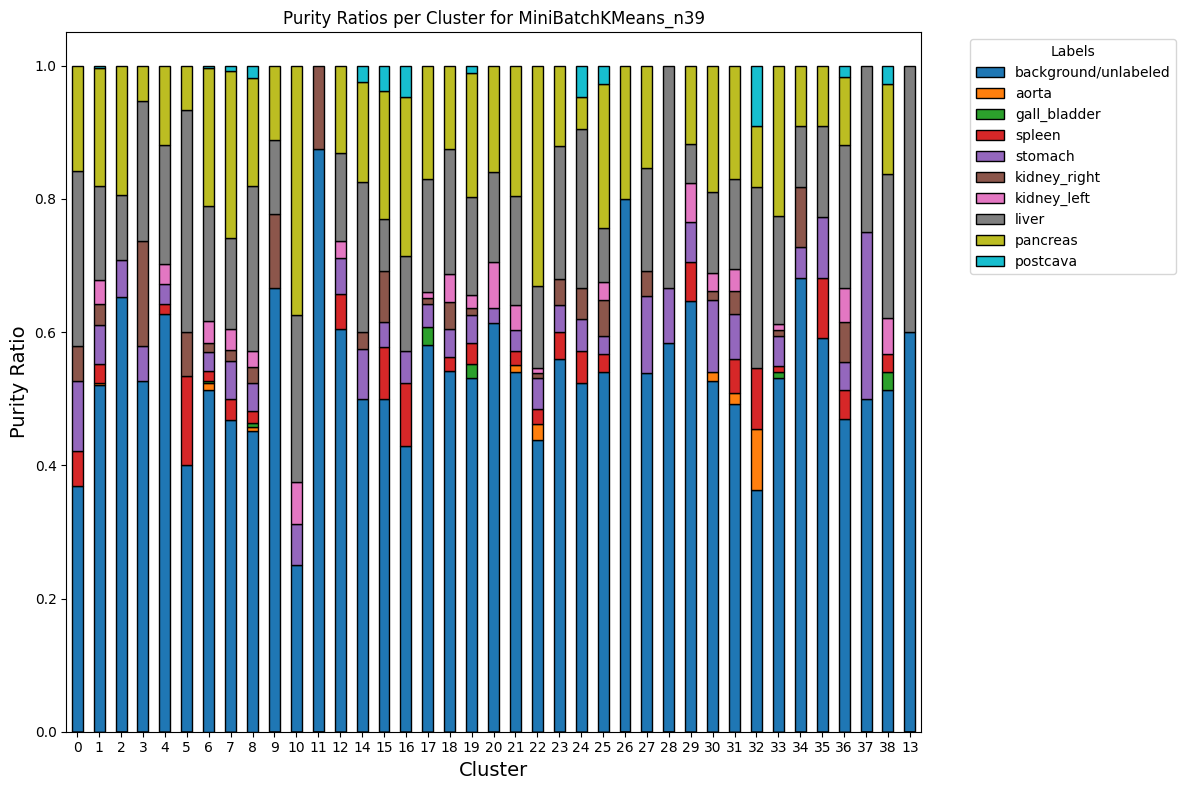

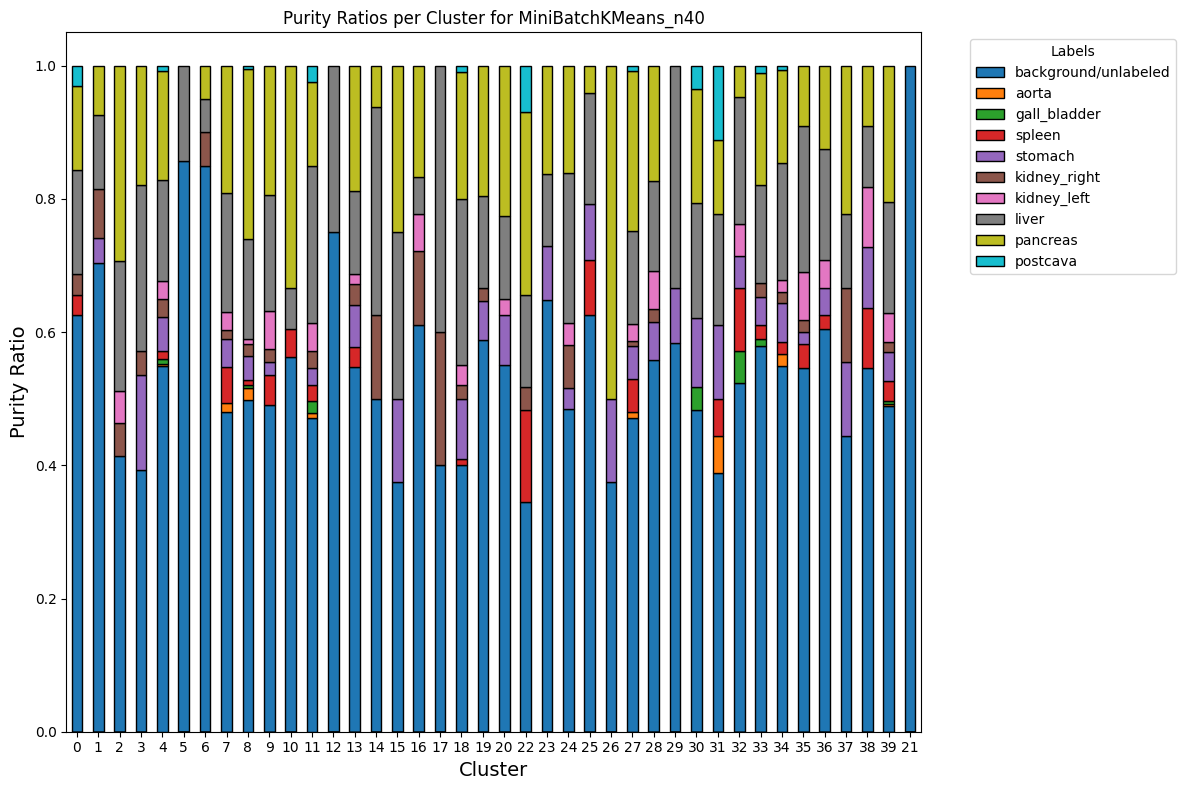

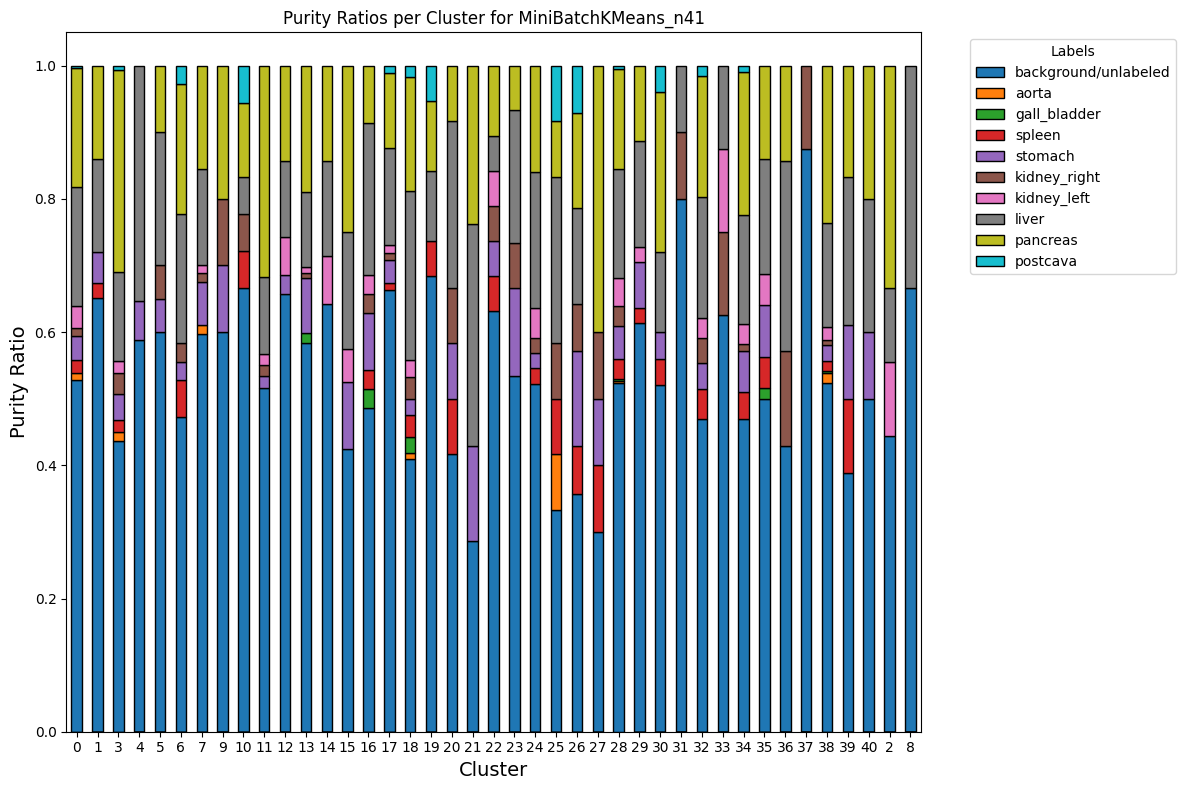

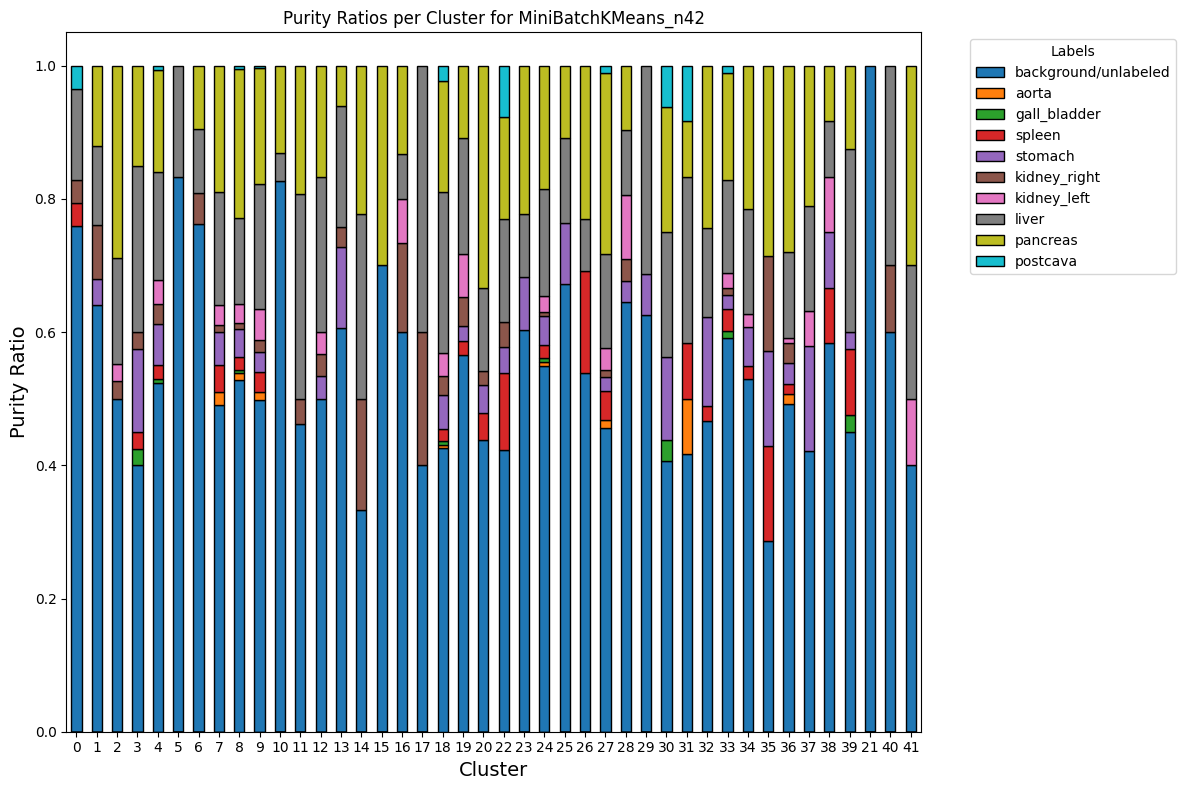

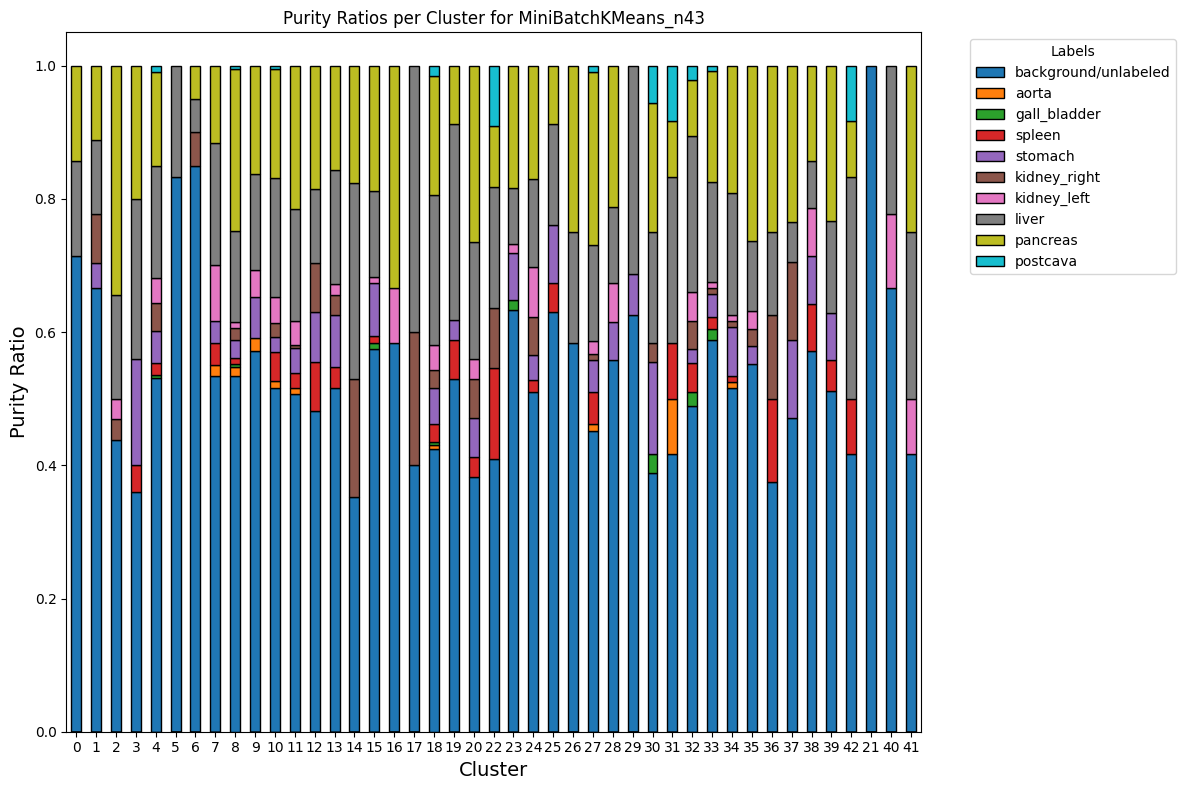

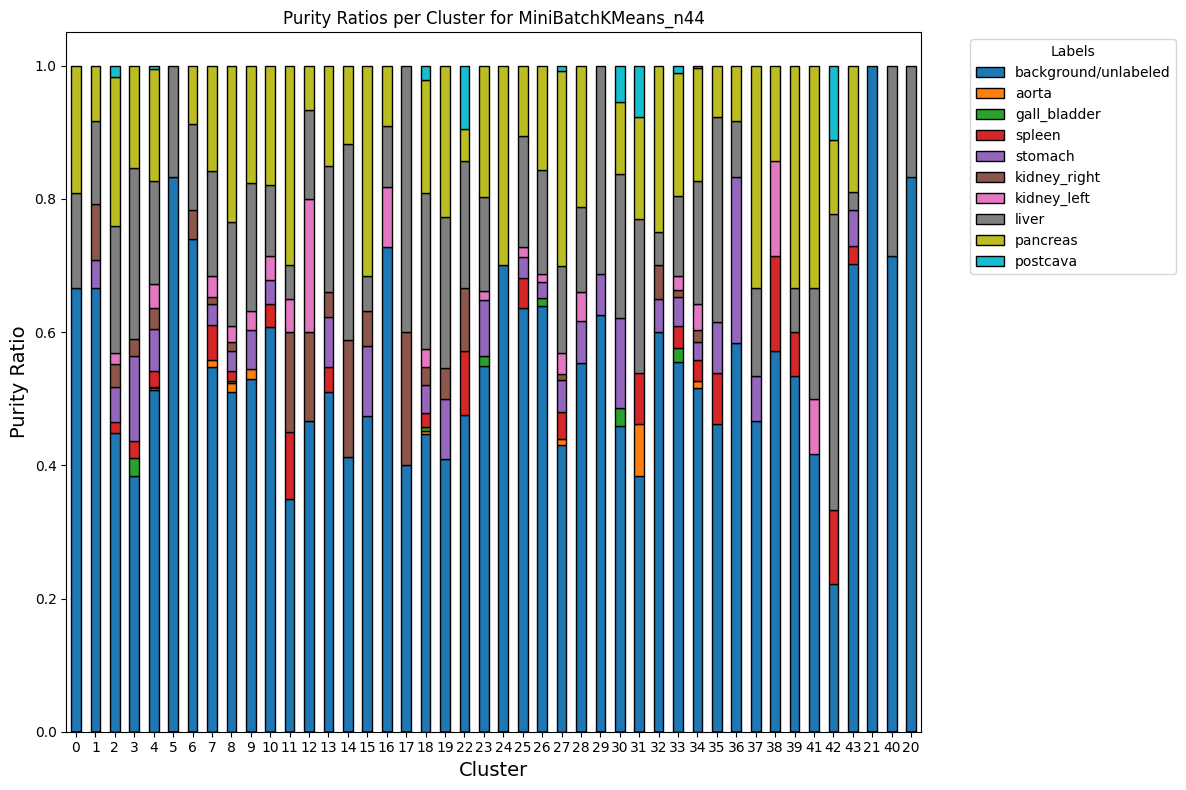

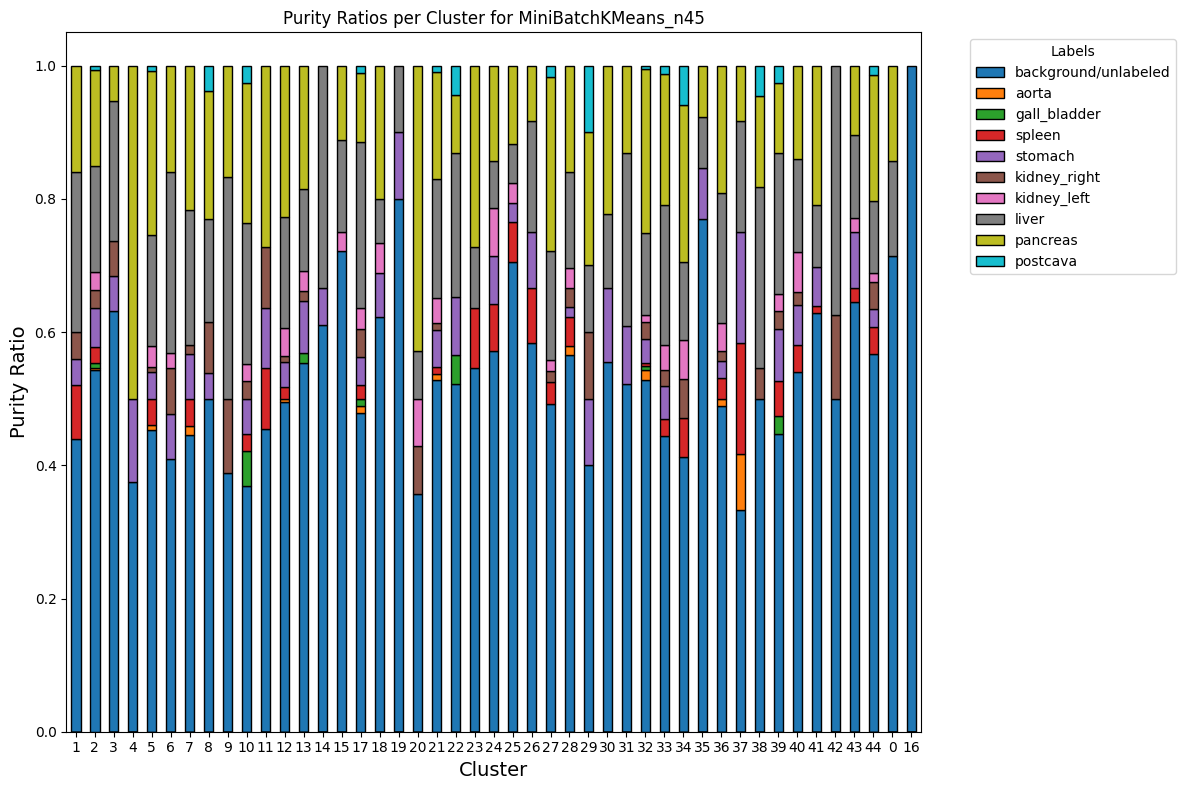

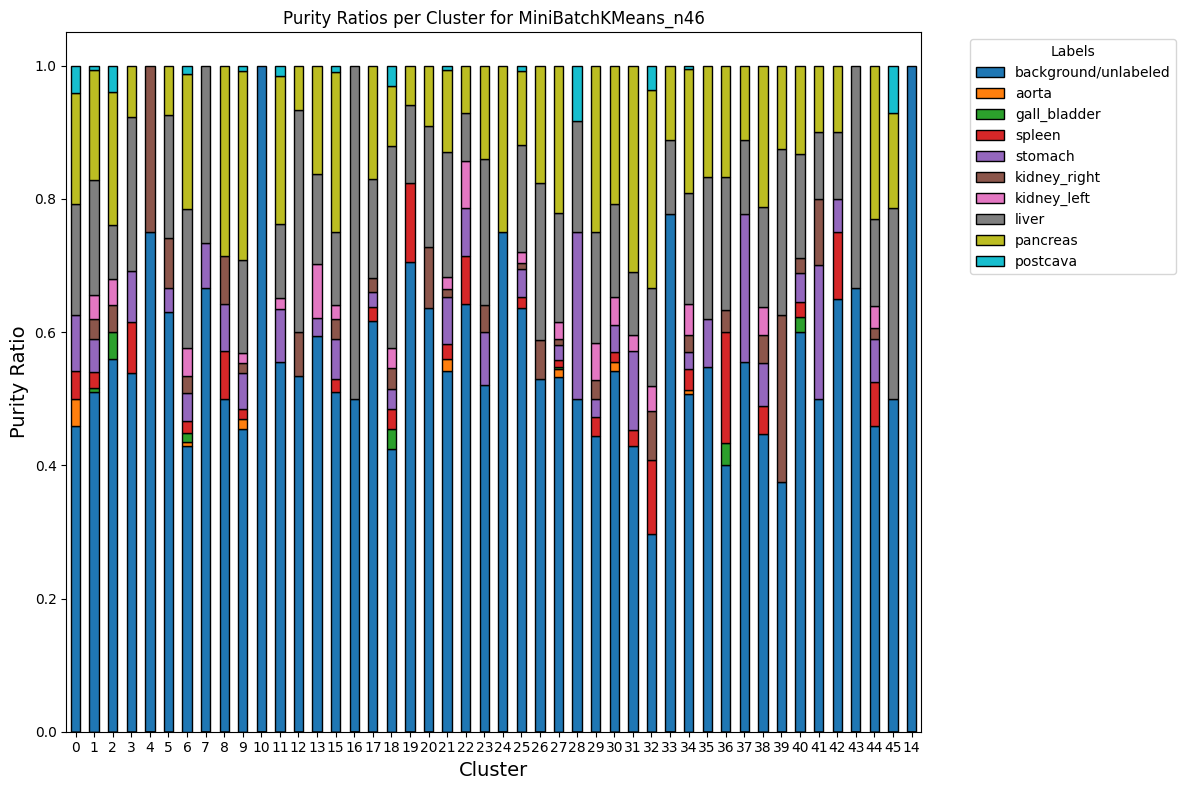

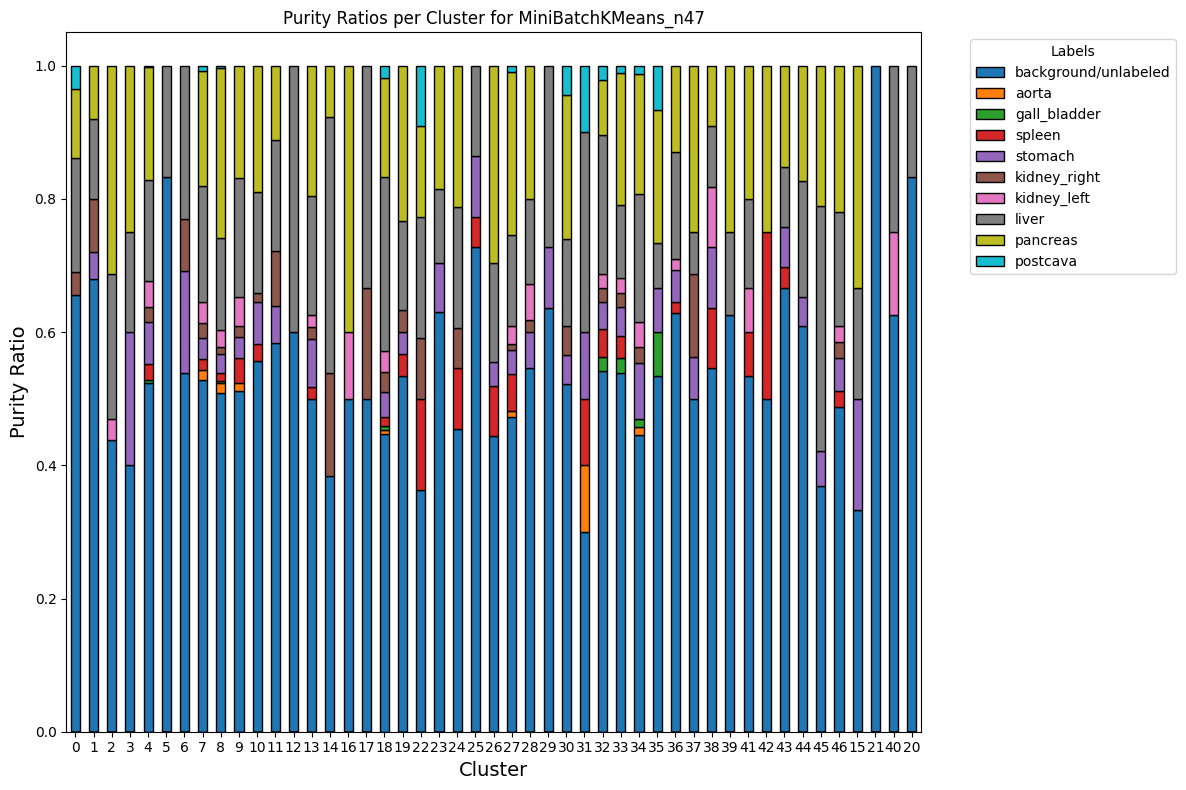

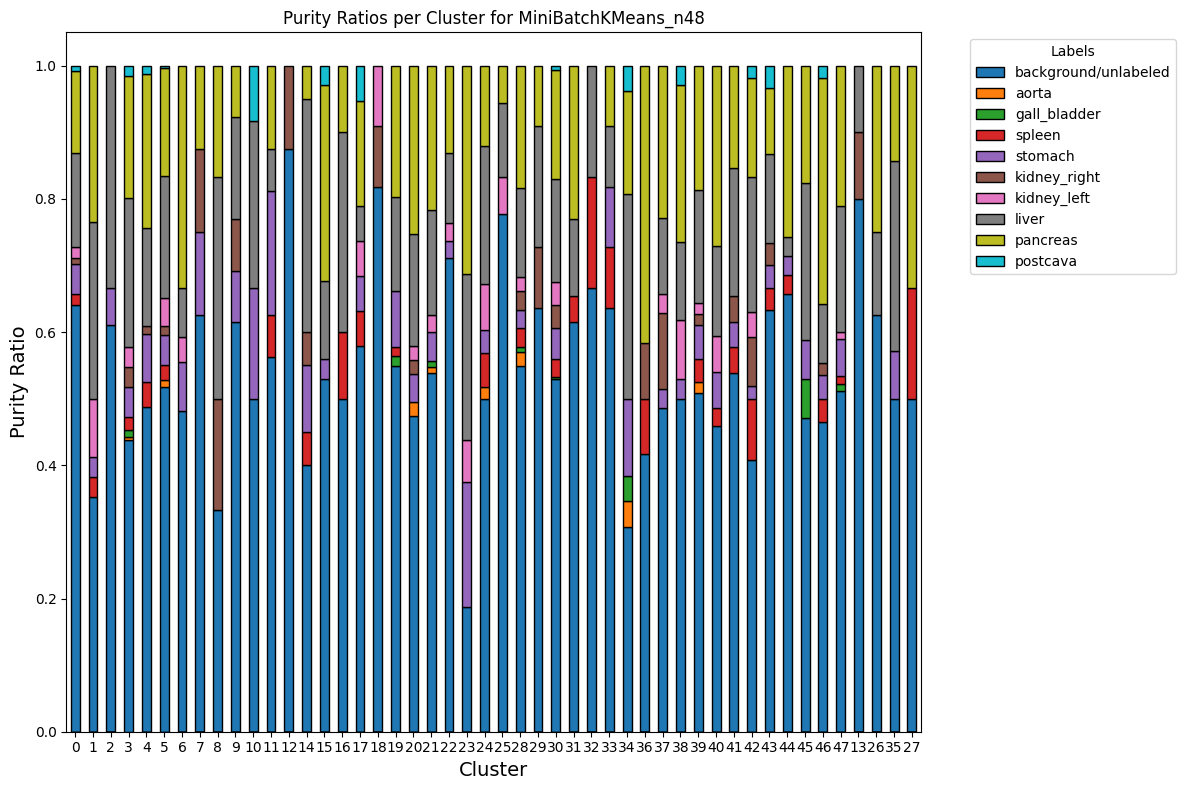

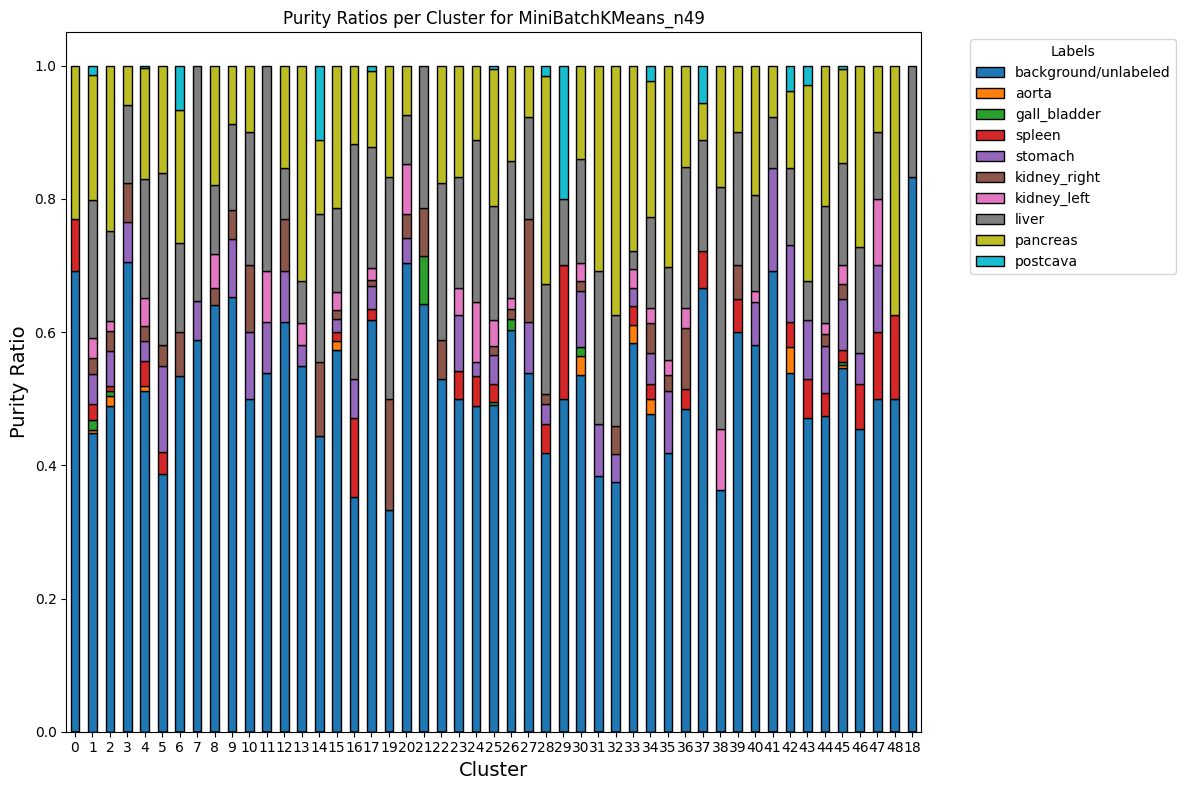

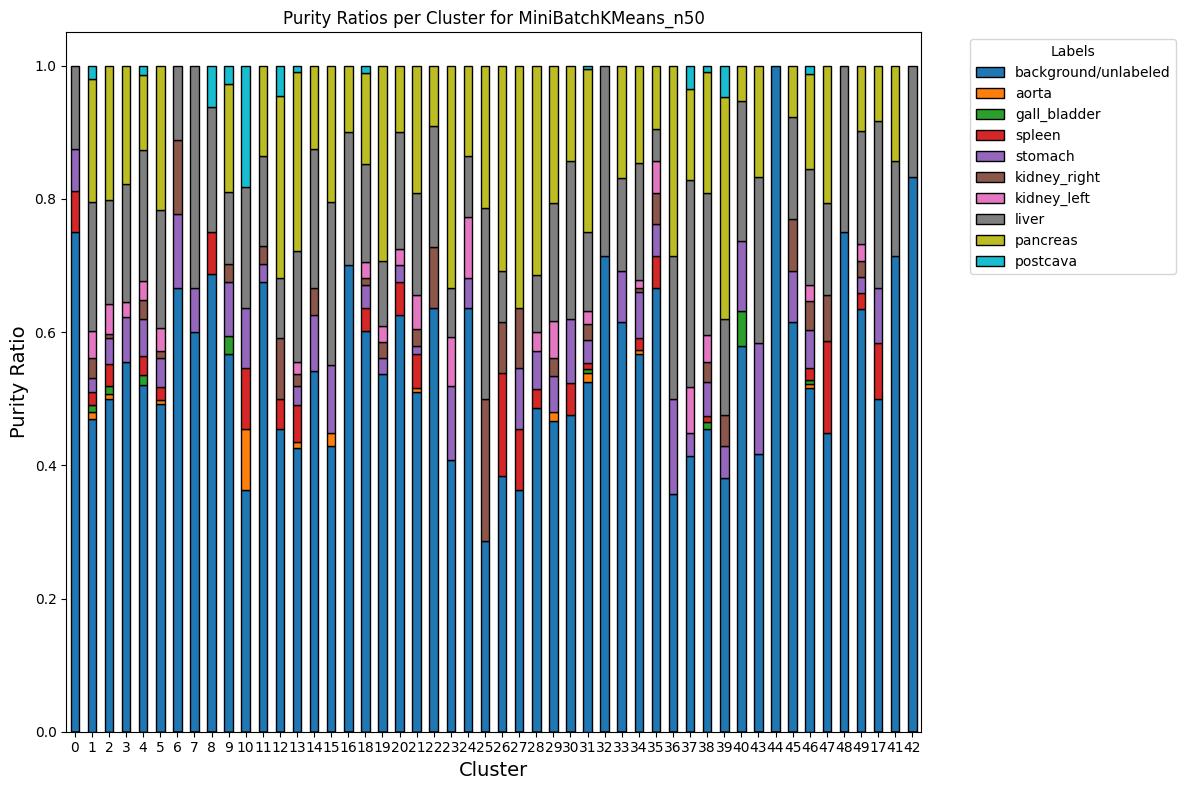

In [46]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 51, 1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))



# Calculate purities
purity_results = calculate_purities(
    data=data,
    labels=labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
# purity_results

### Pancreas vs. Background Labels Purity

In [ ]:
pancreas_vs_background_labels = middle_binary_labels

Clustering Algorithms: 100%|██████████| 49/49 [00:06<00:00,  7.50alg/s]


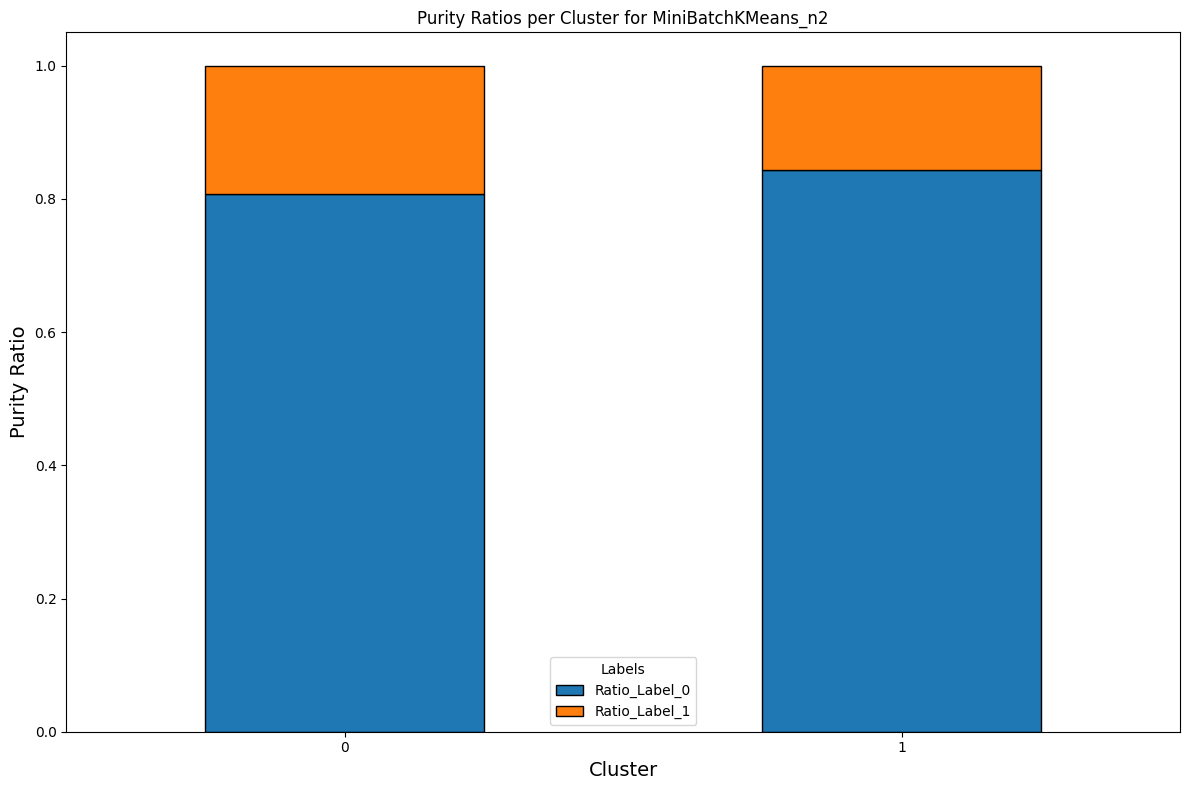

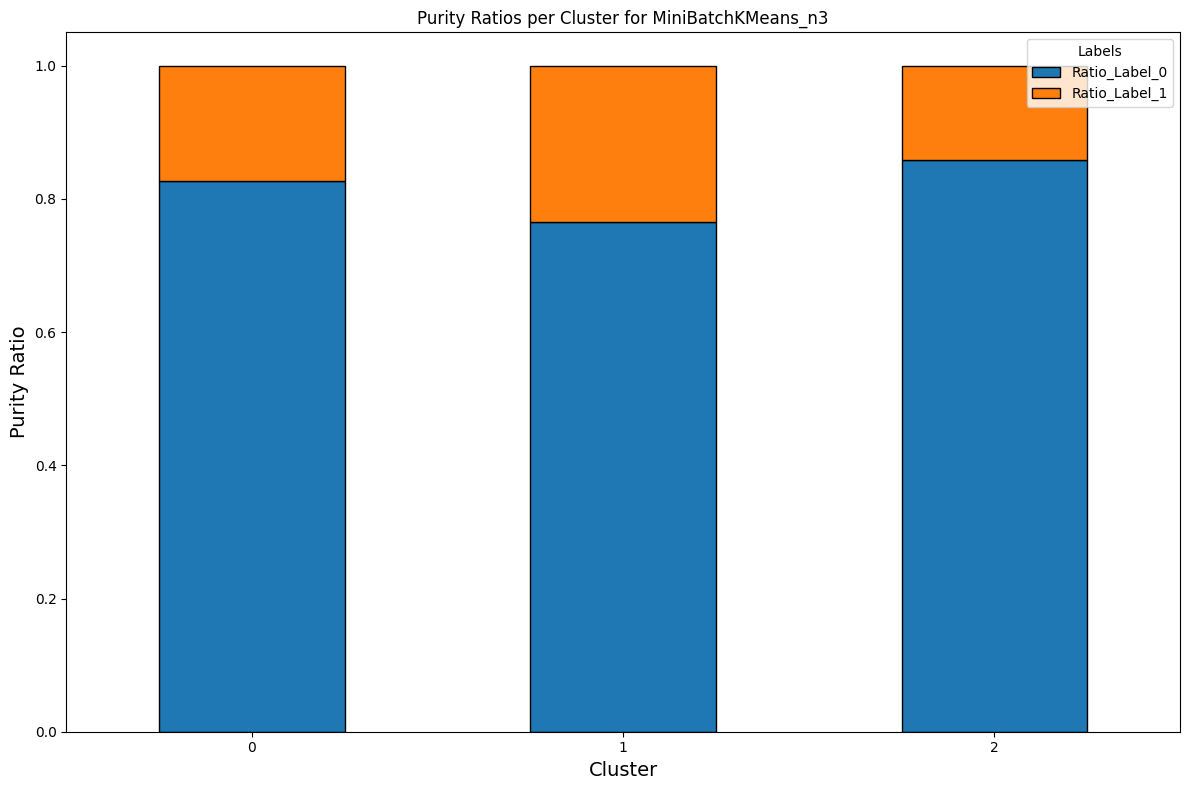

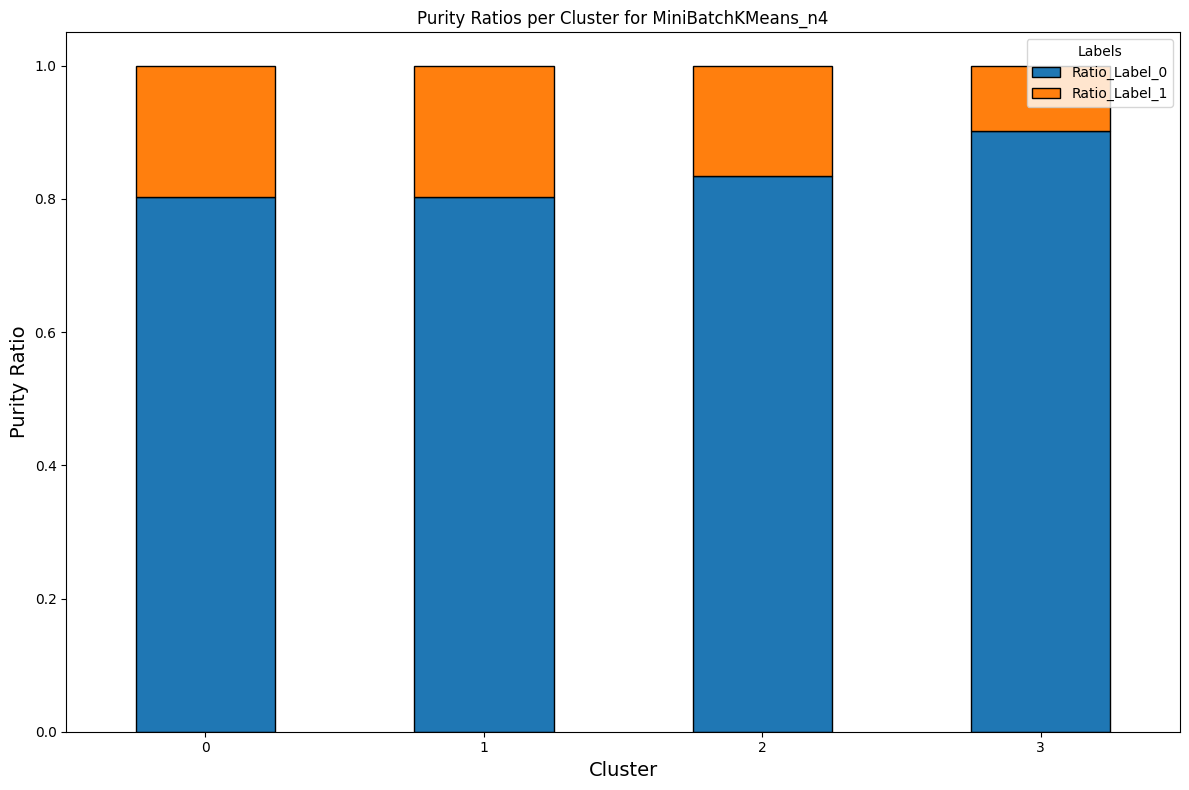

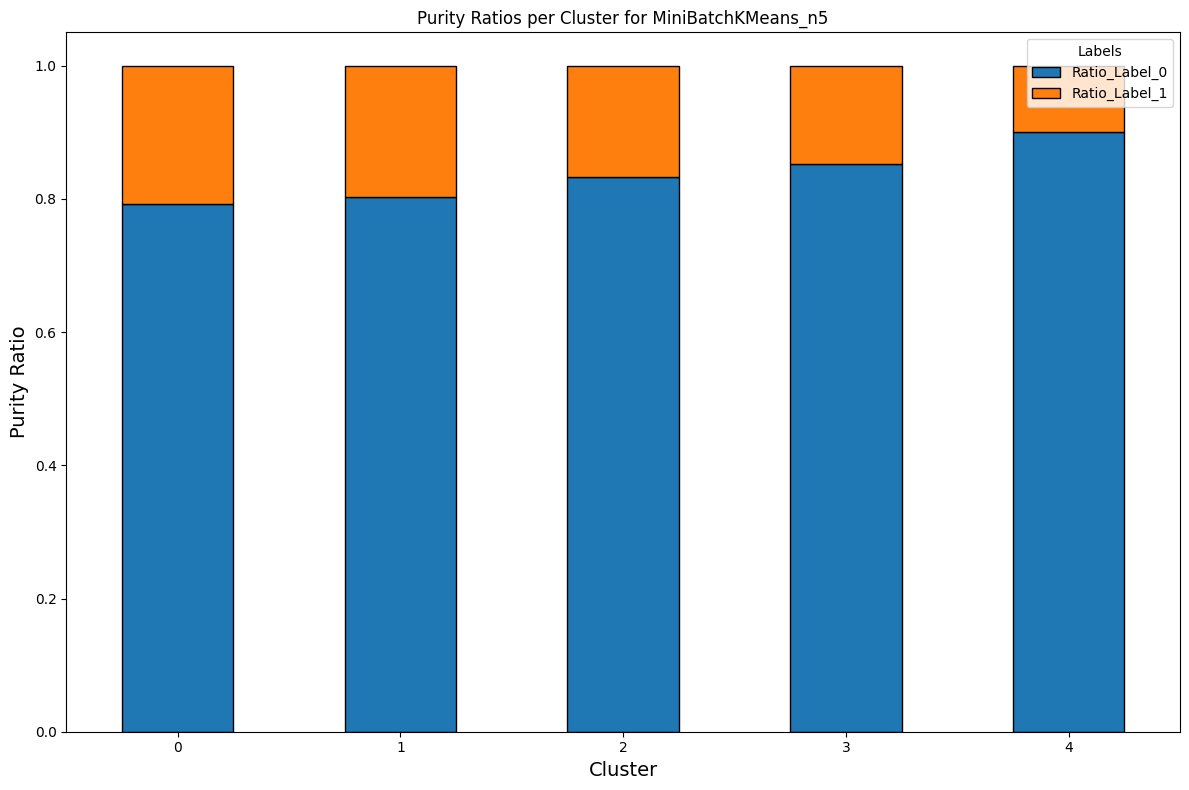

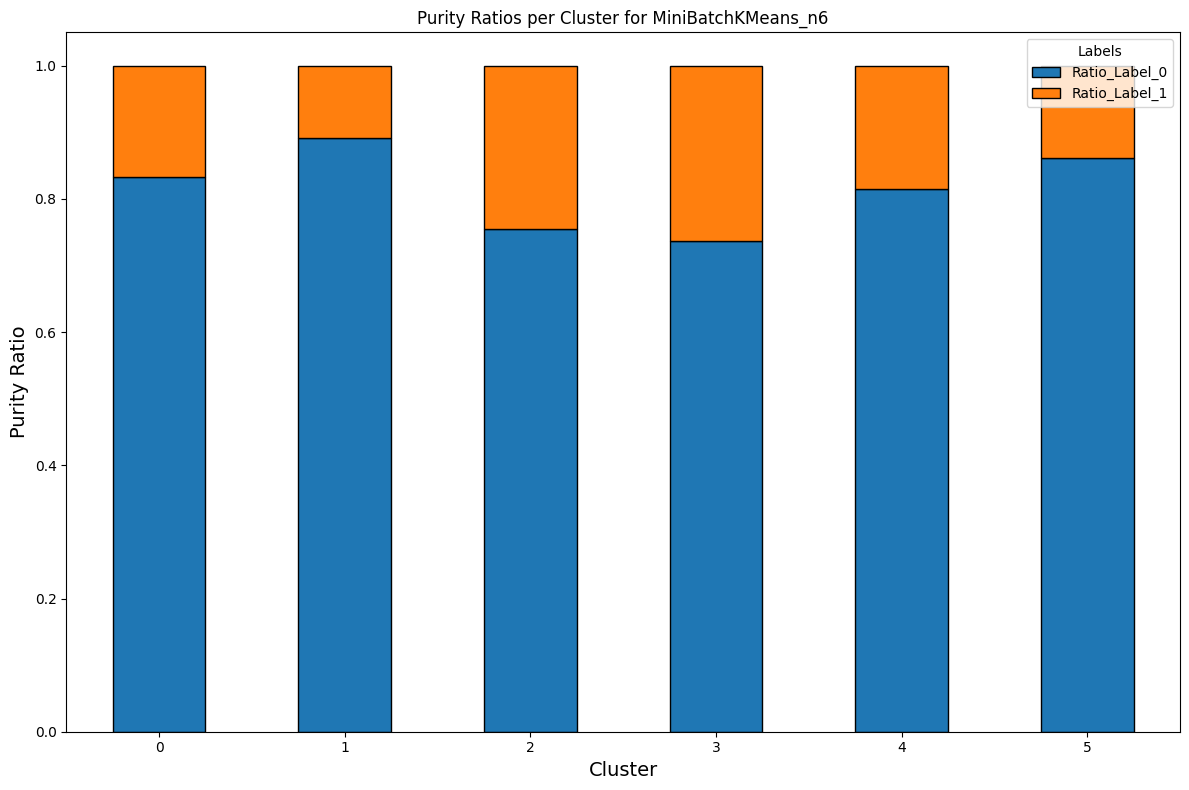

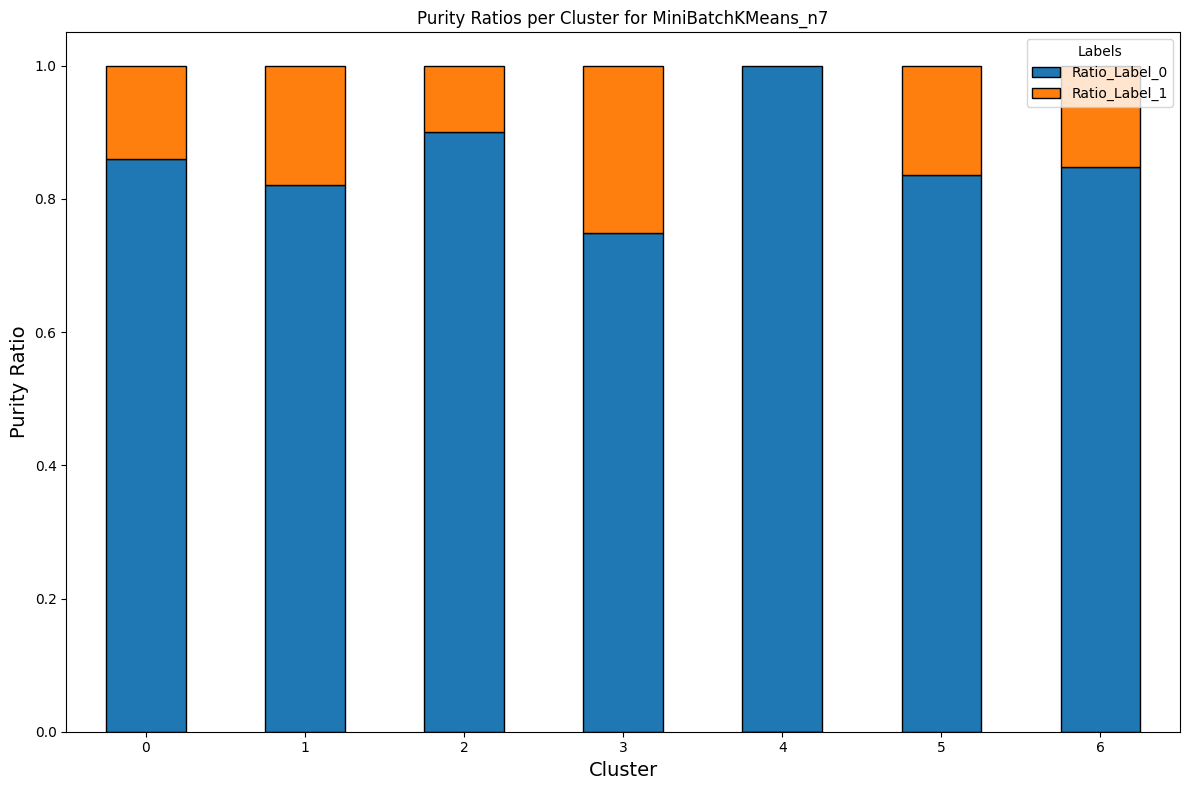

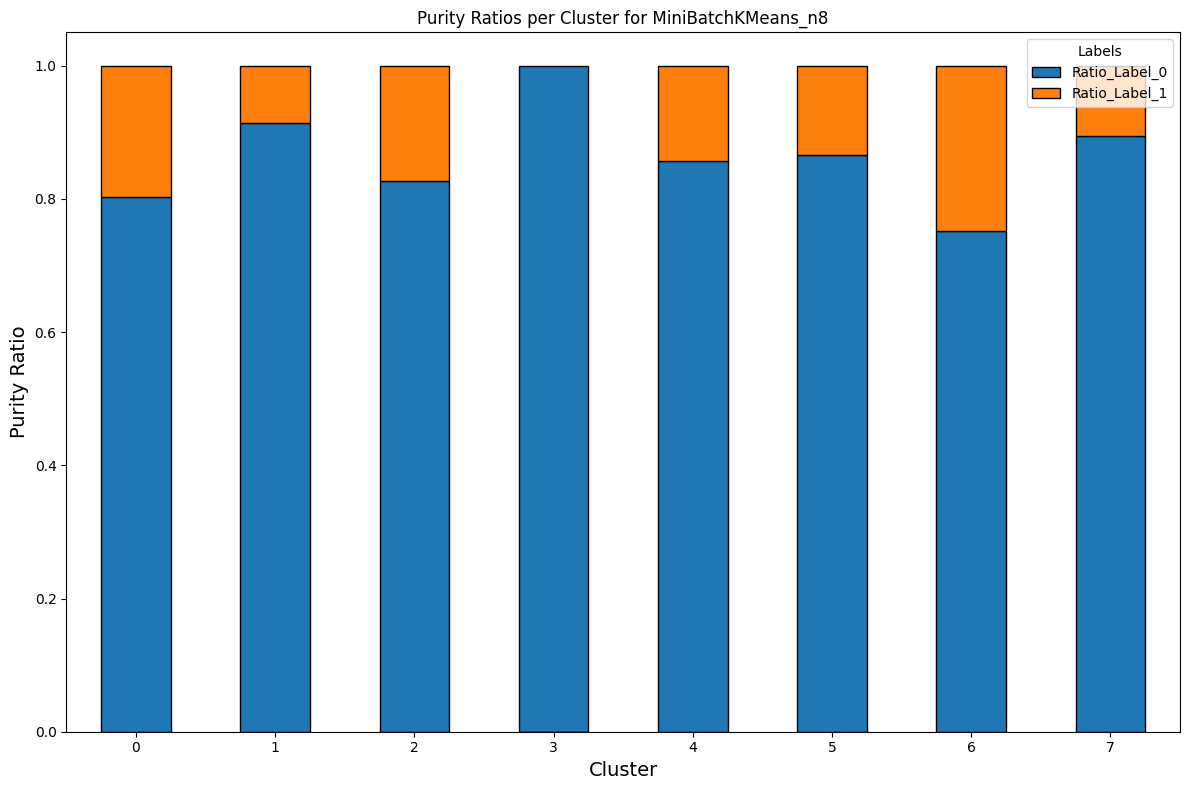

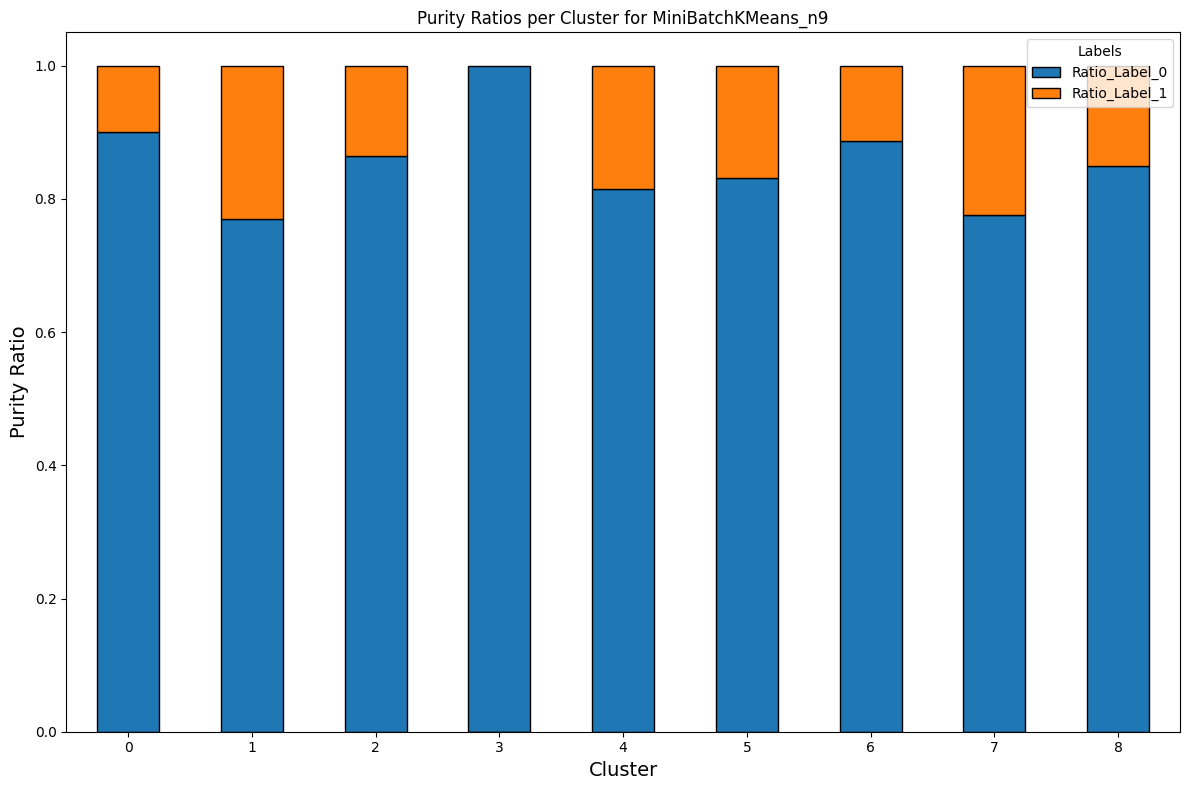

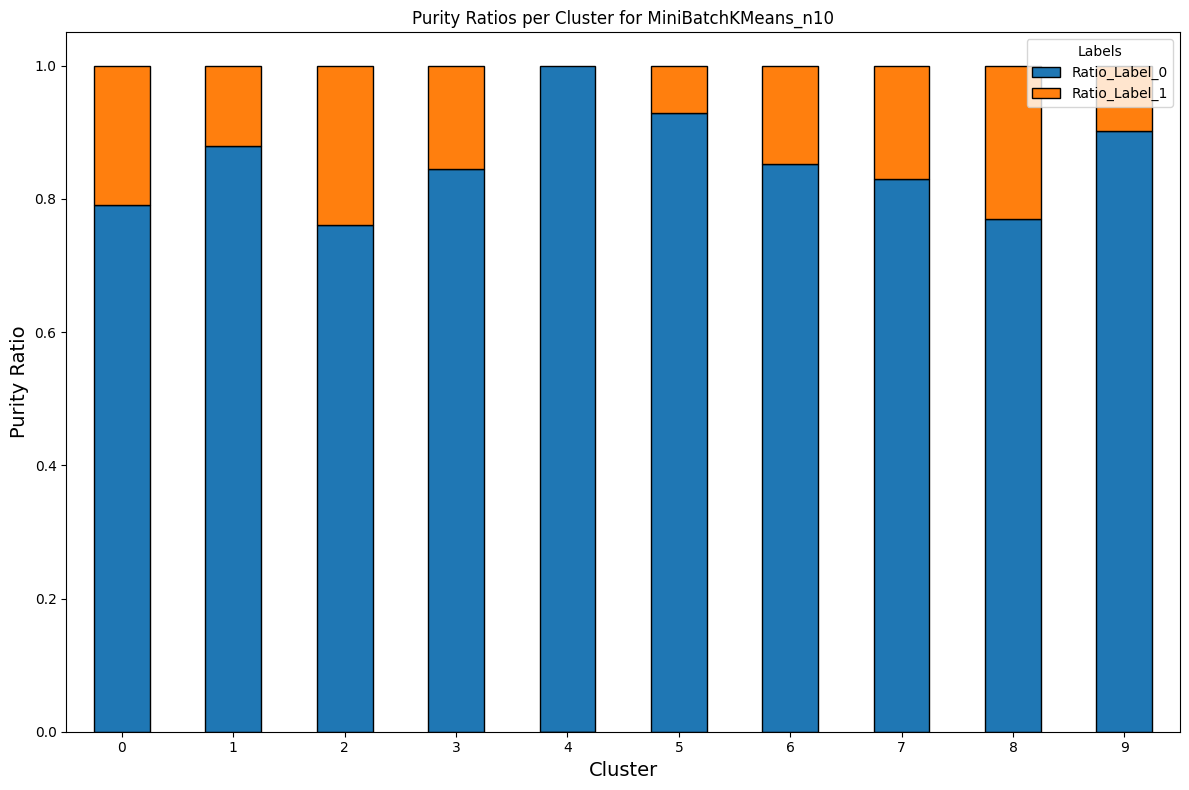

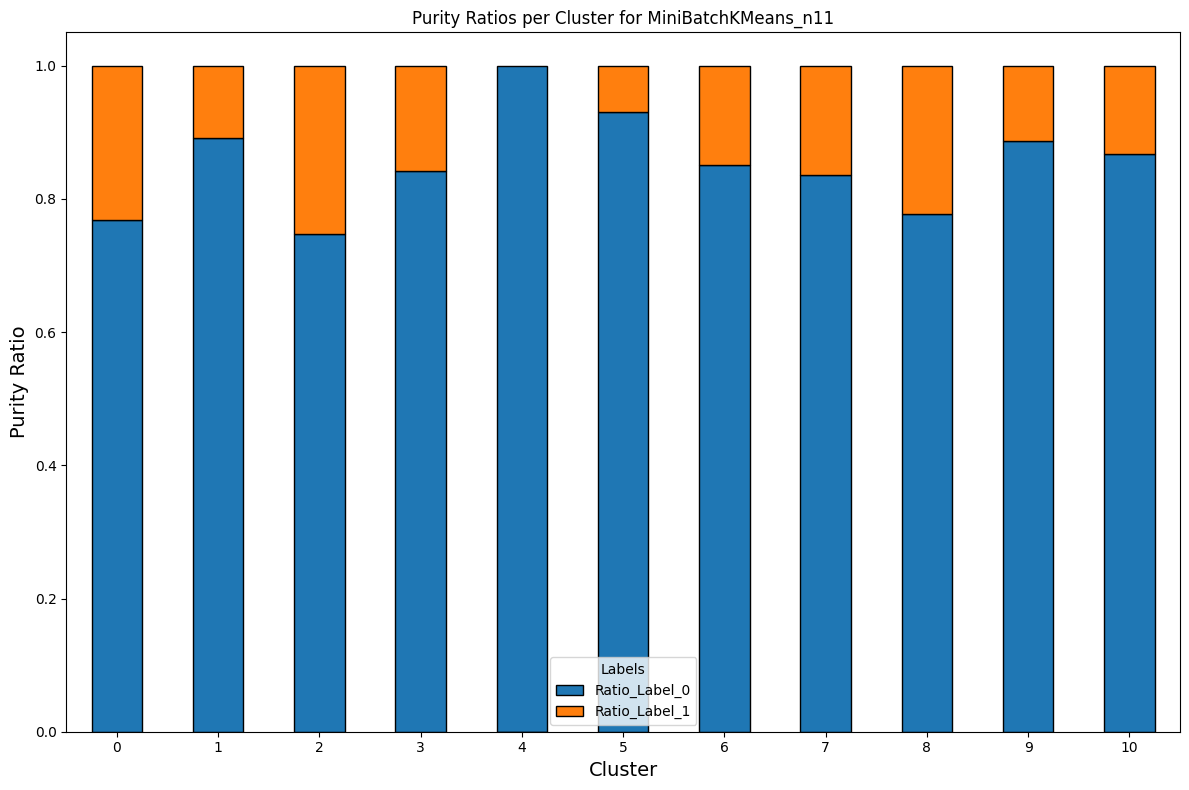

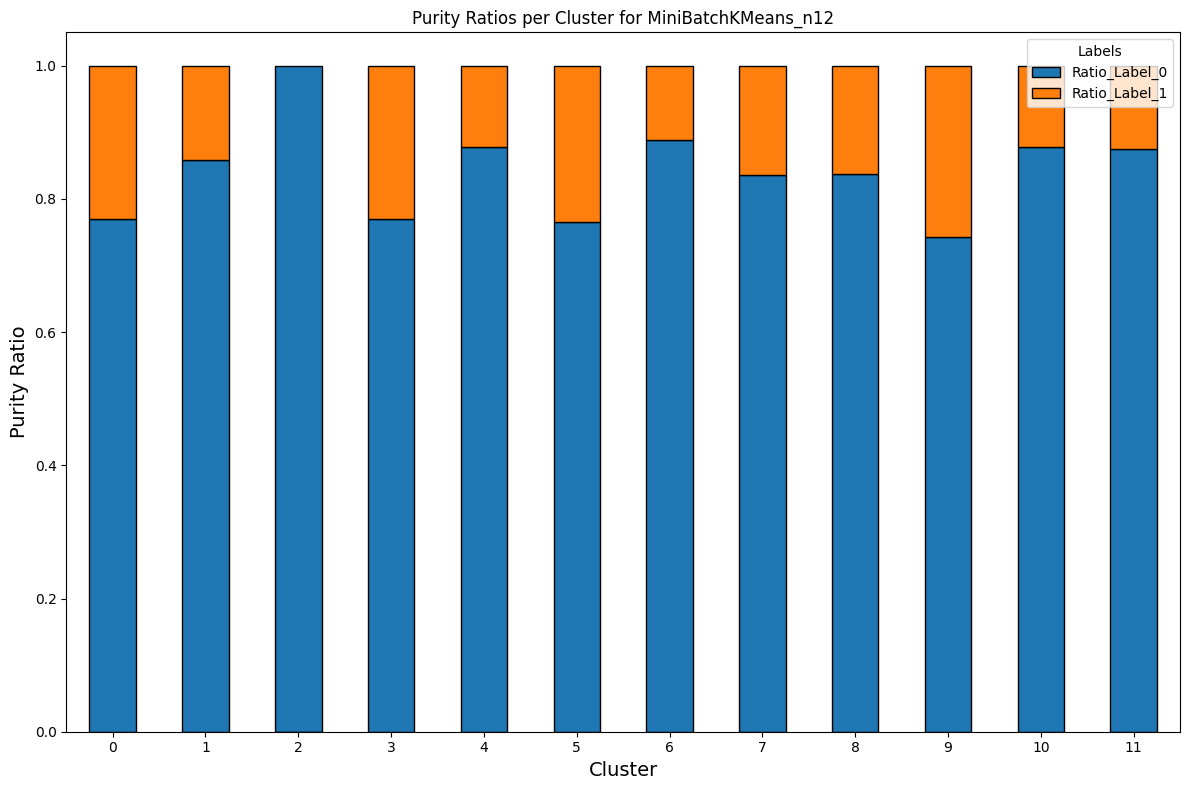

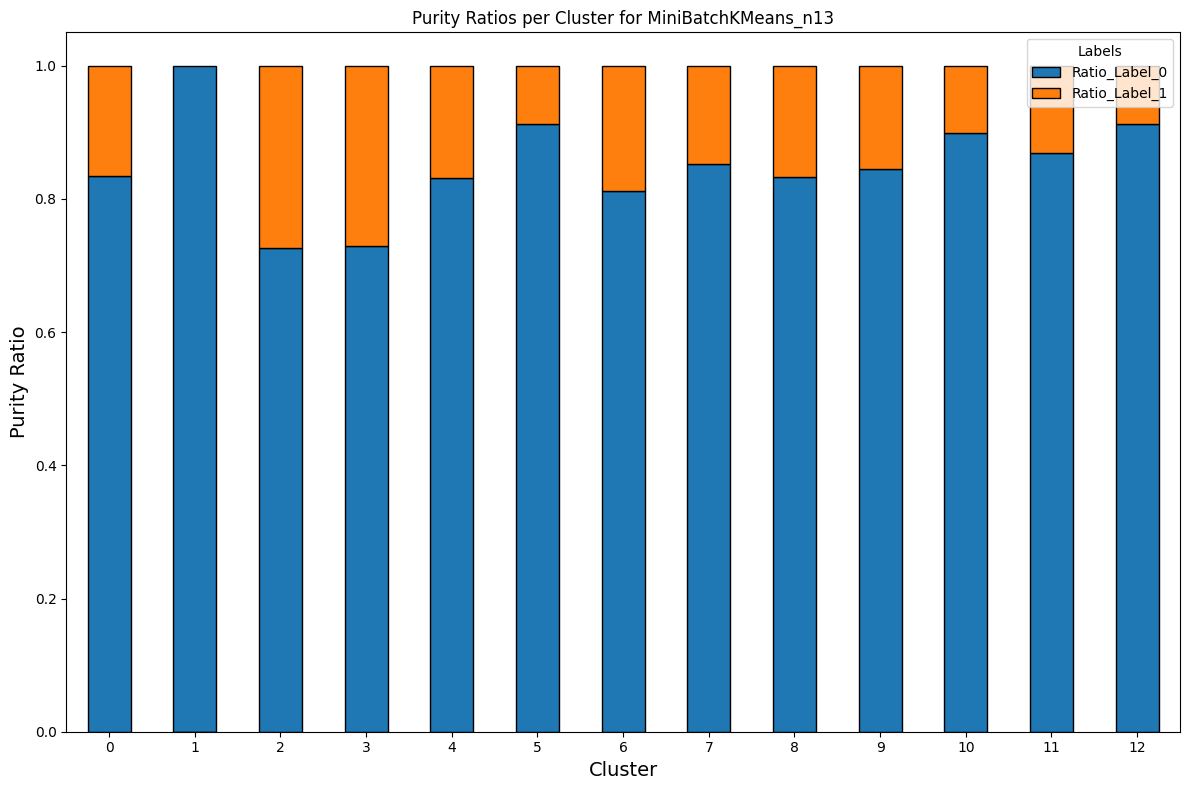

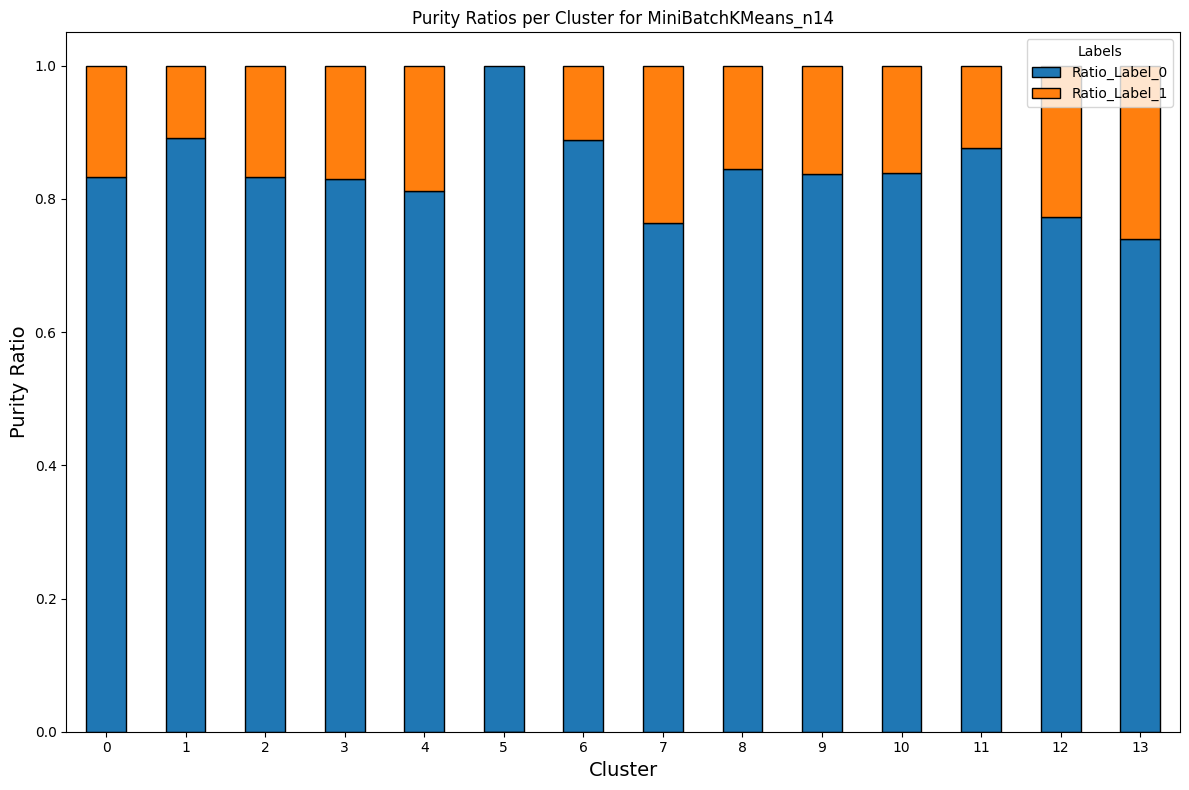

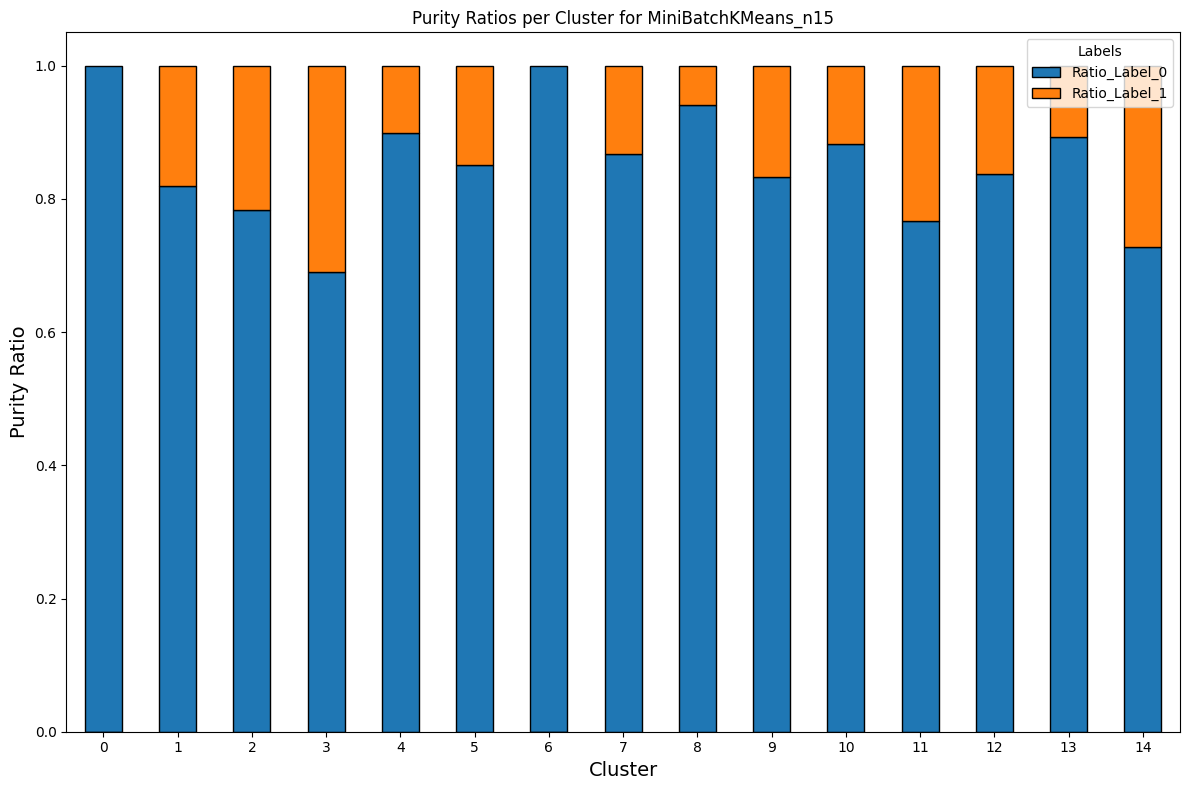

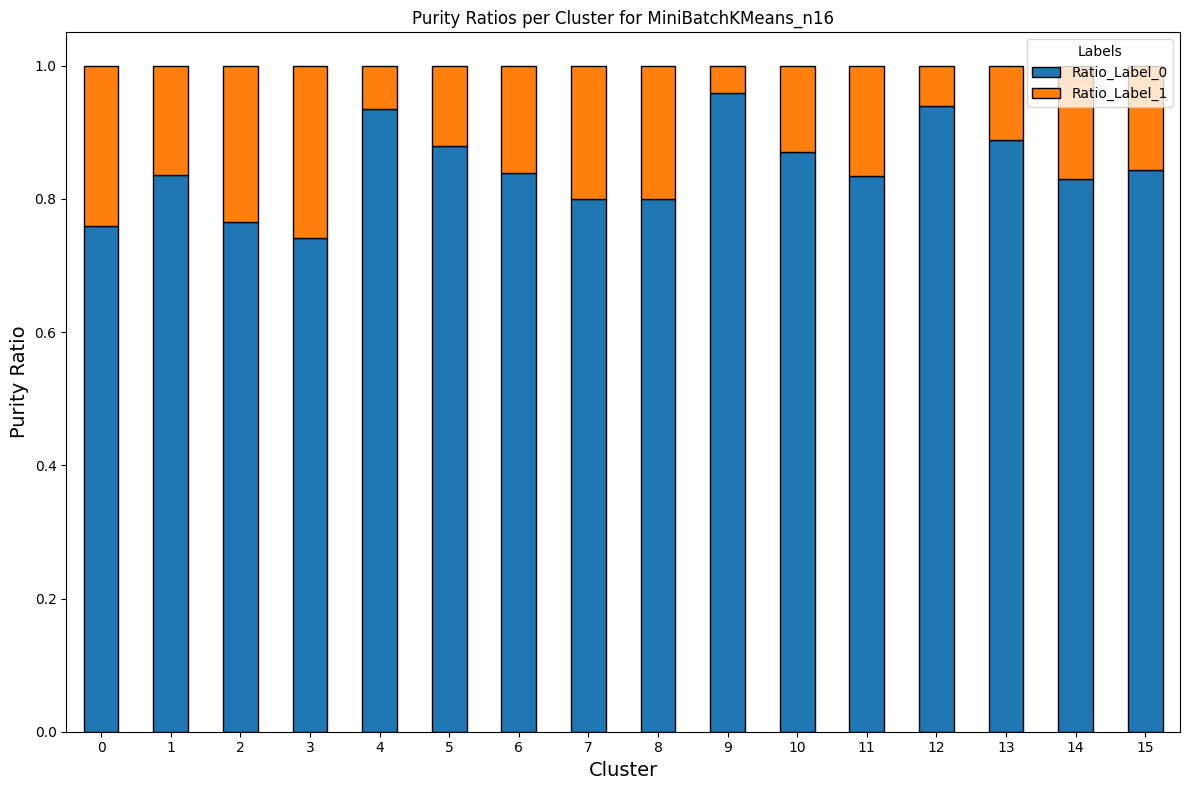

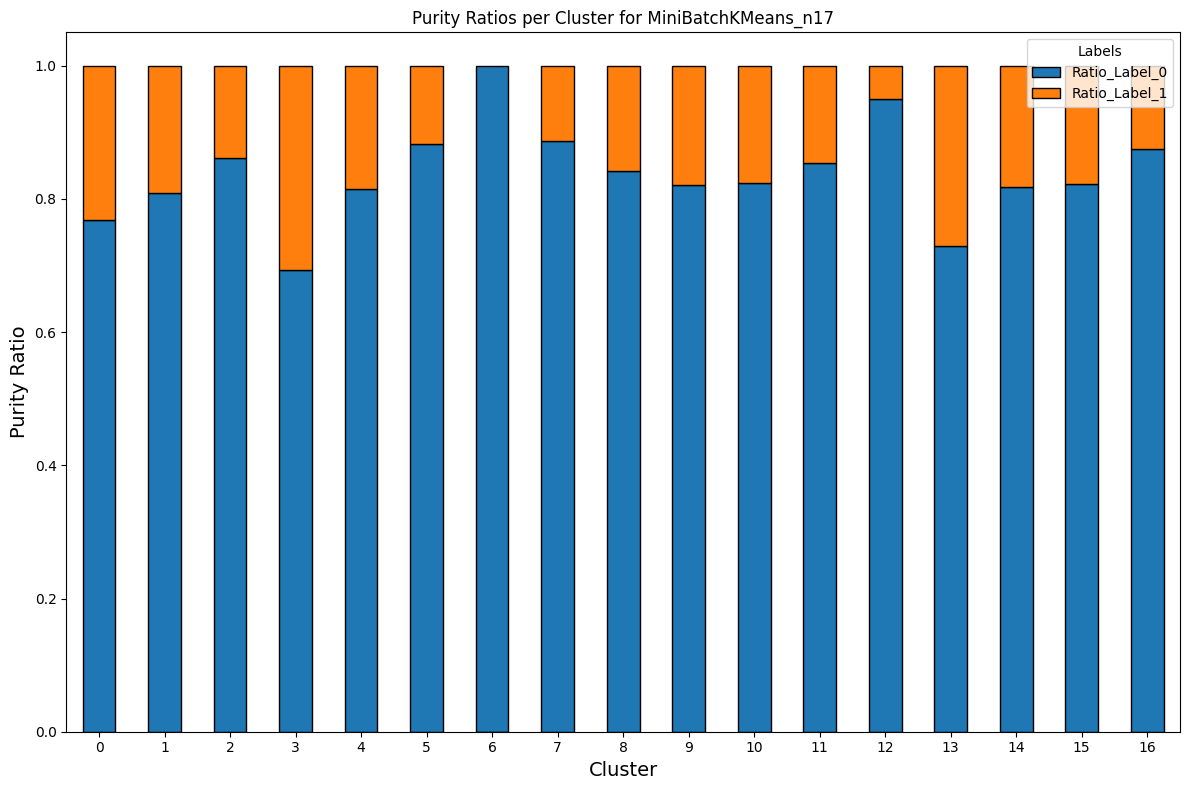

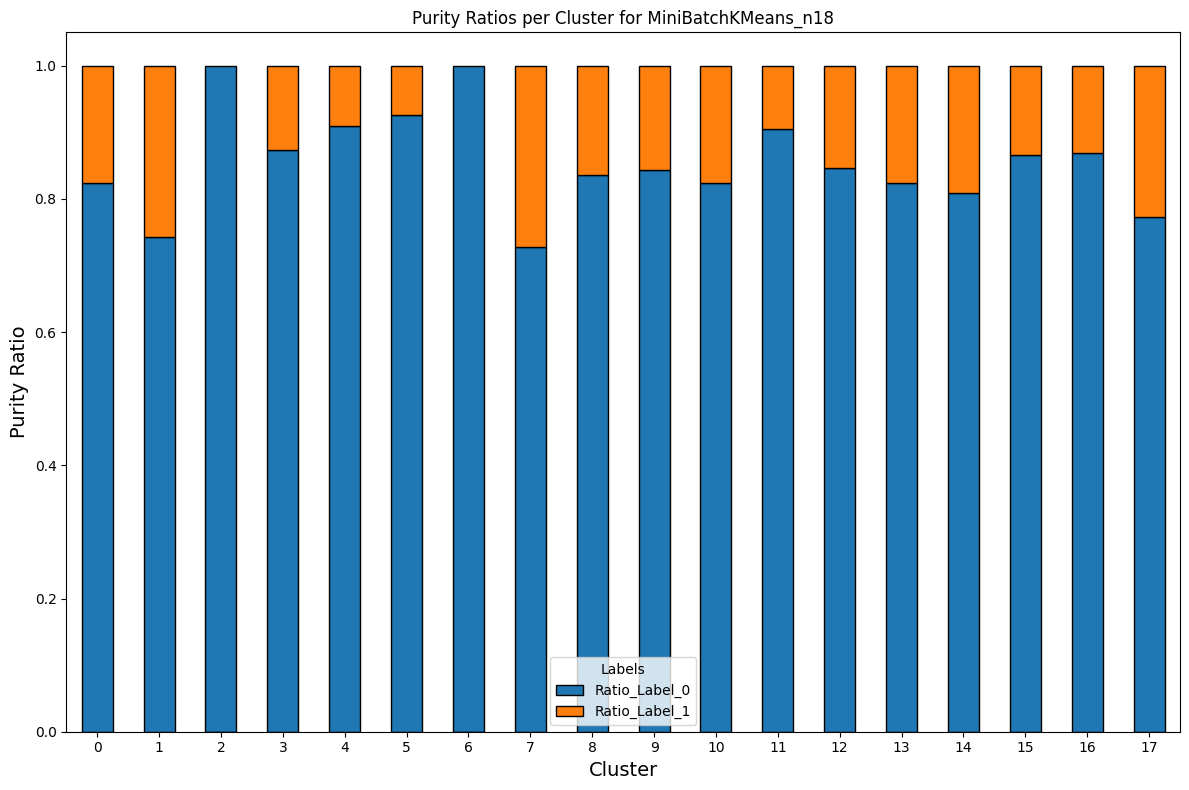

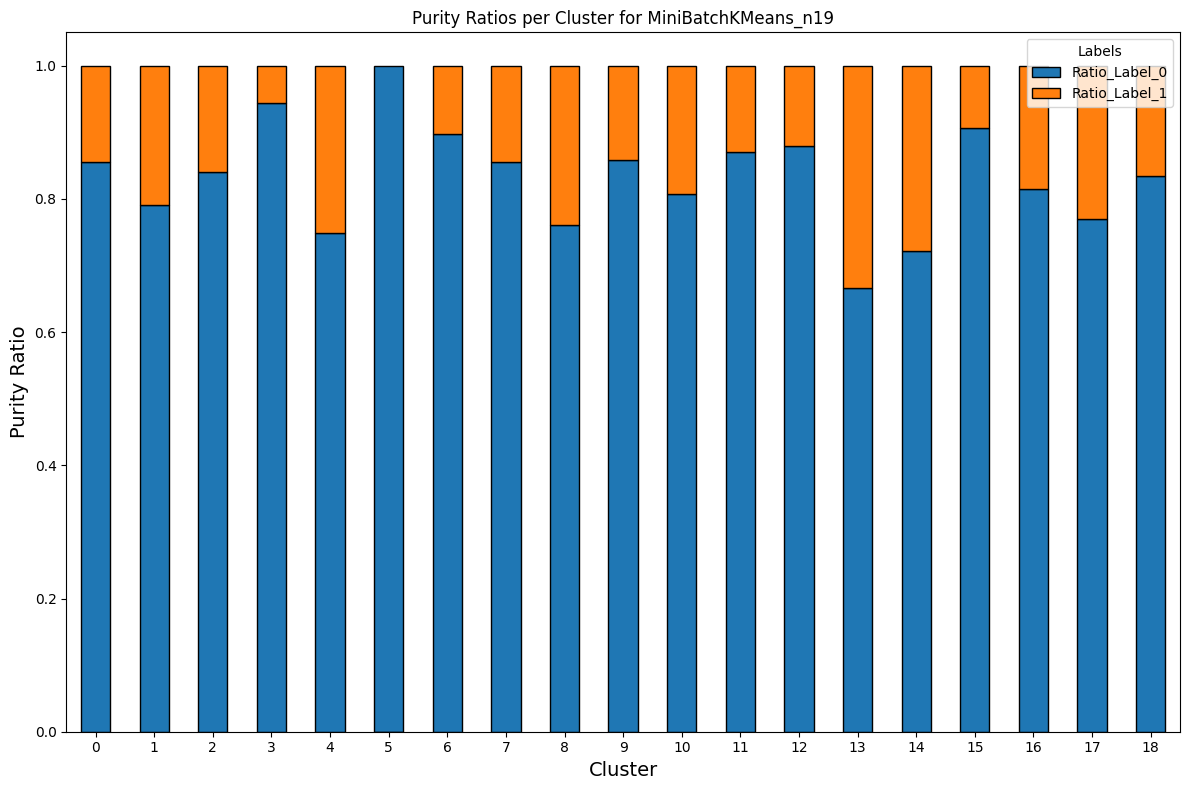

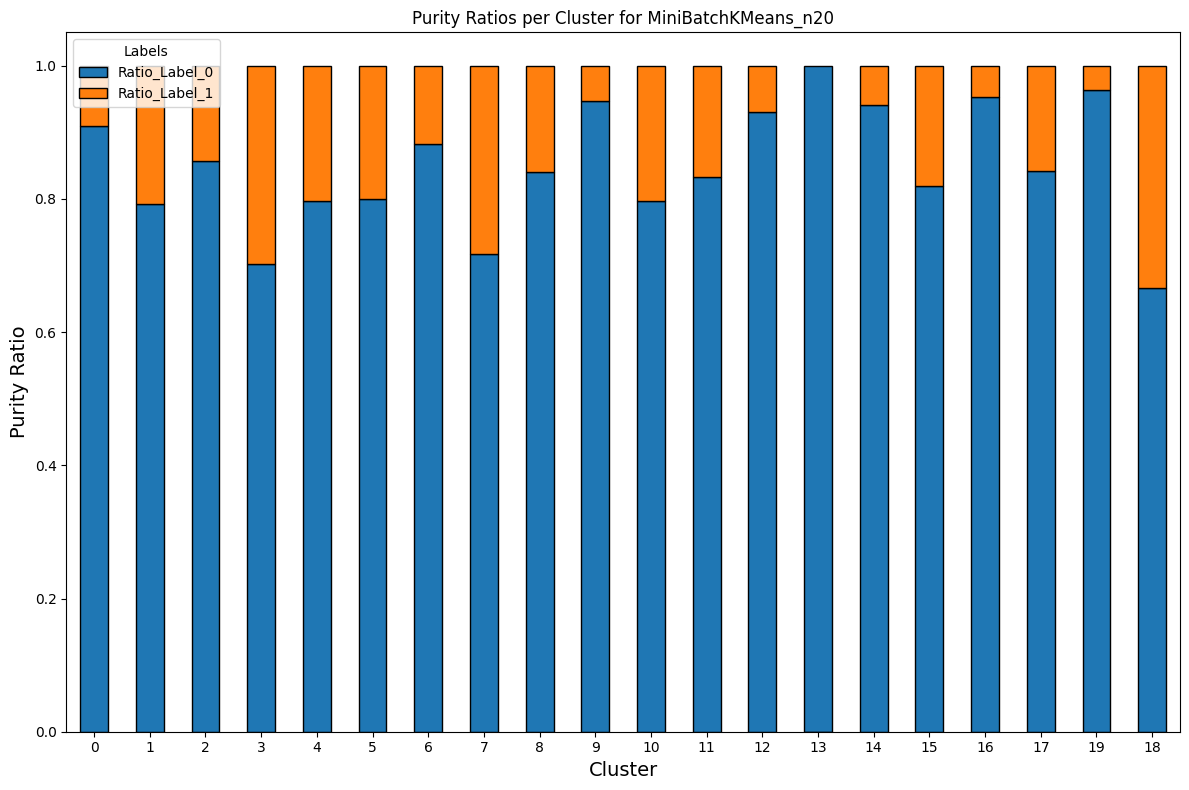

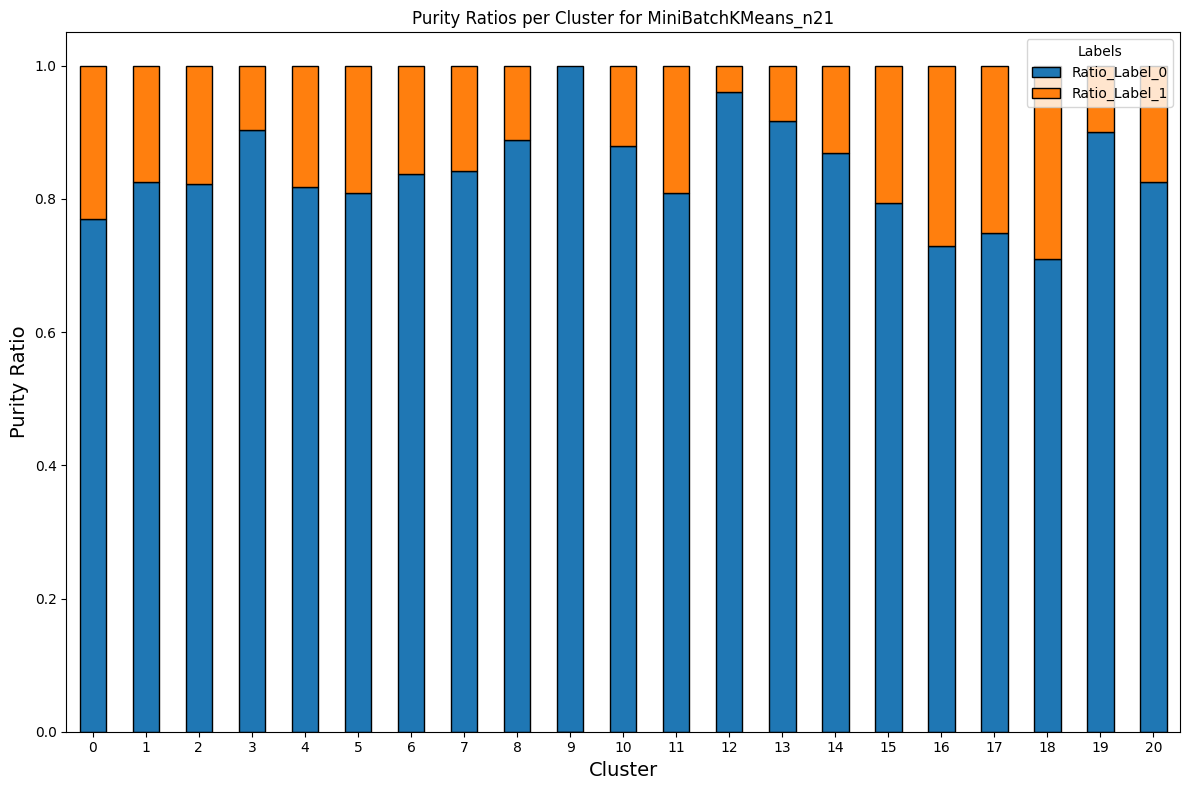

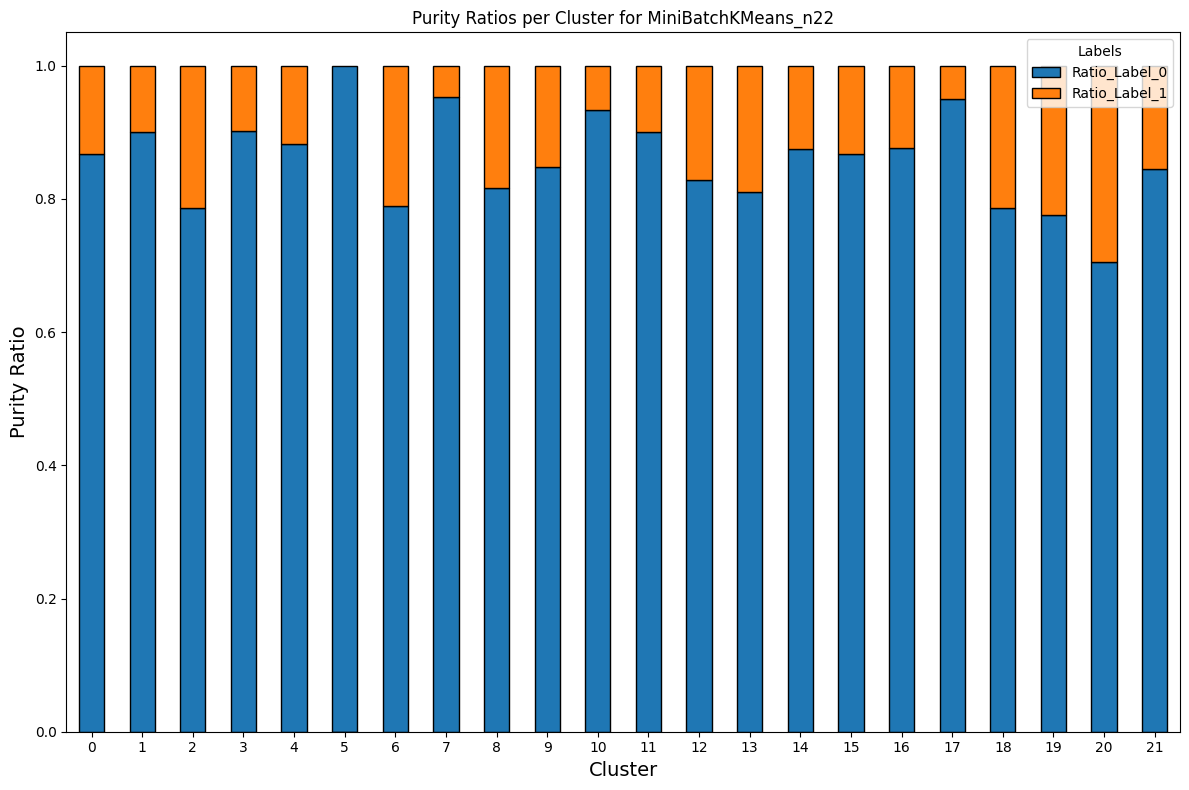

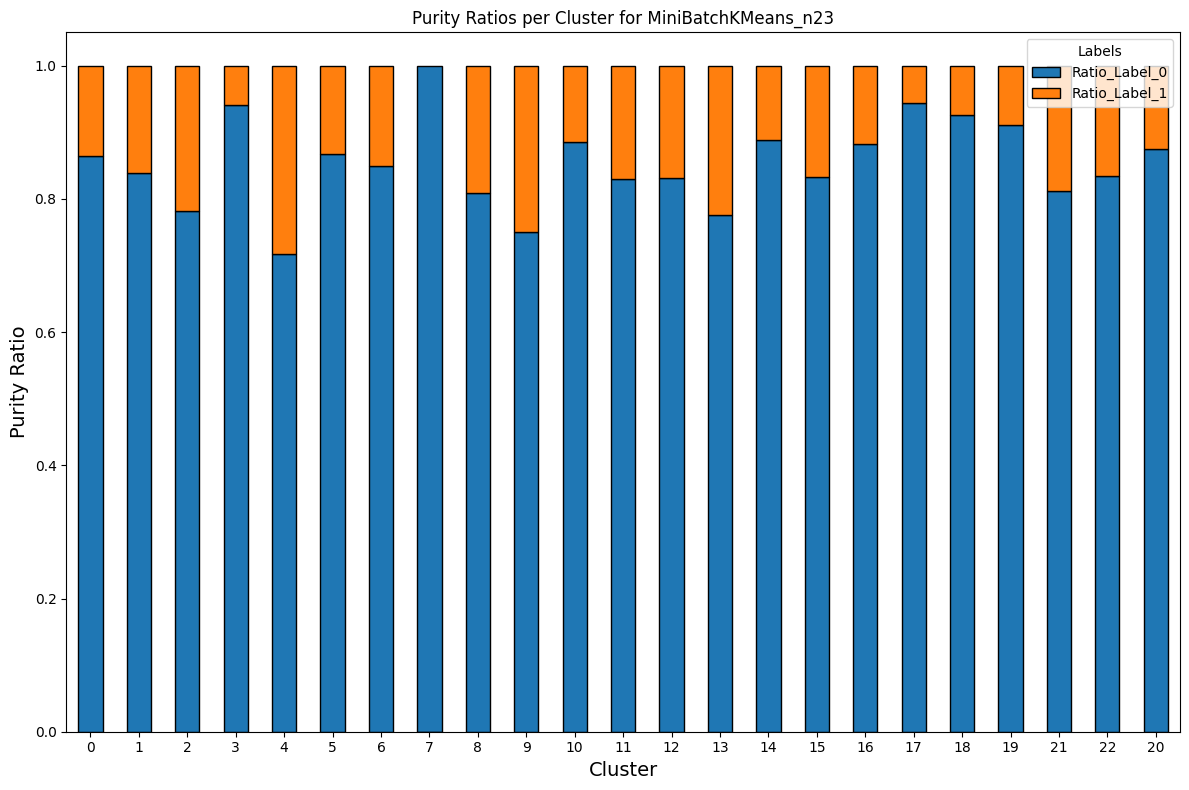

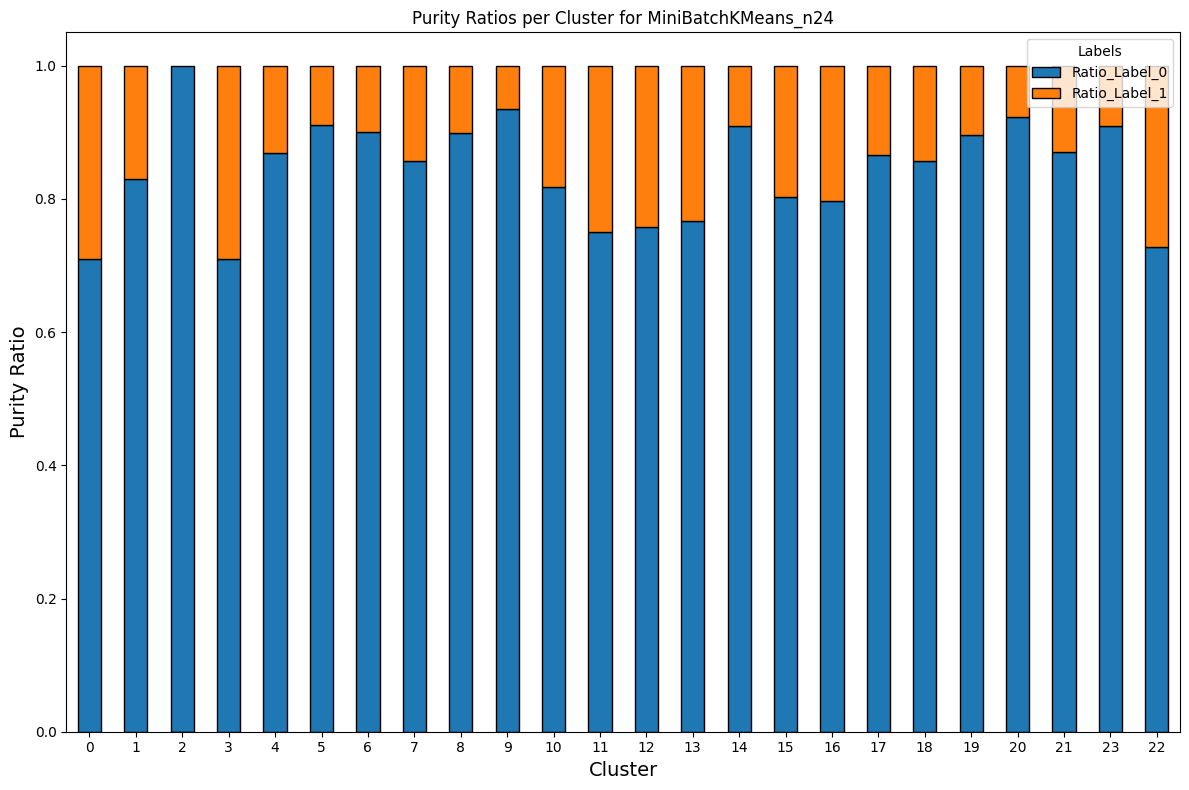

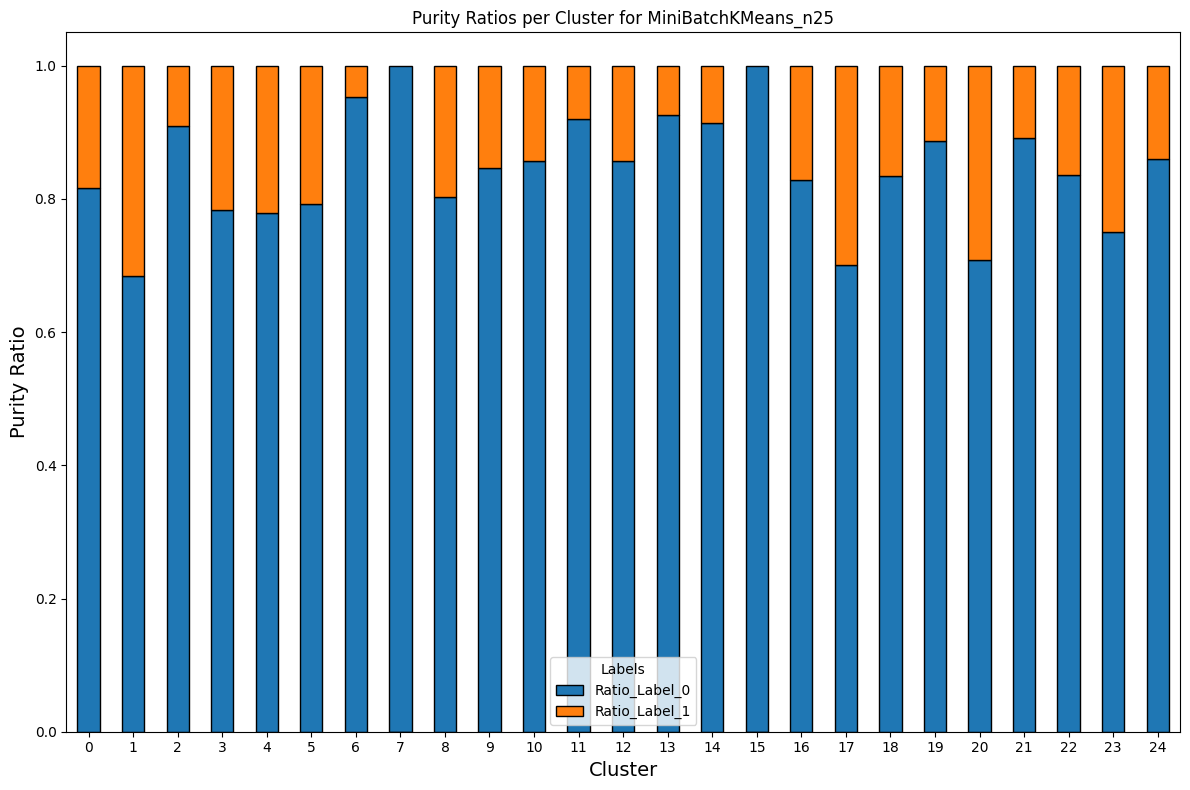

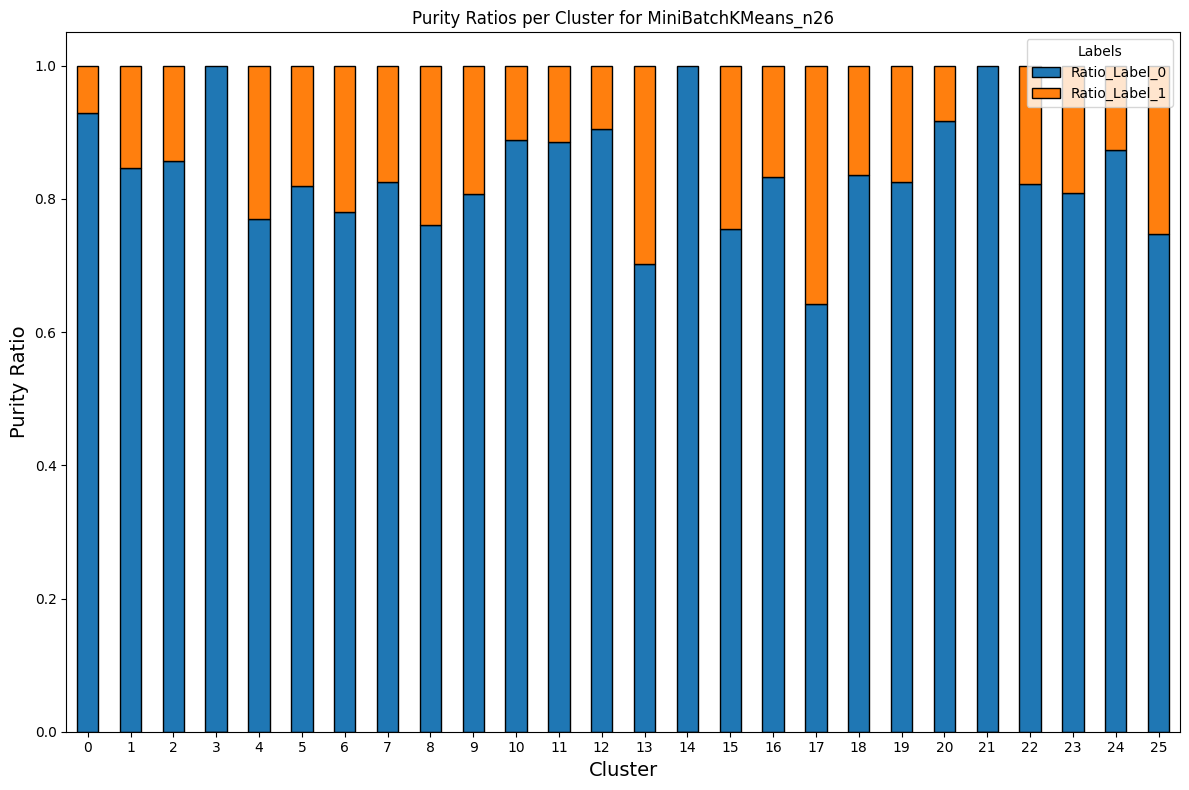

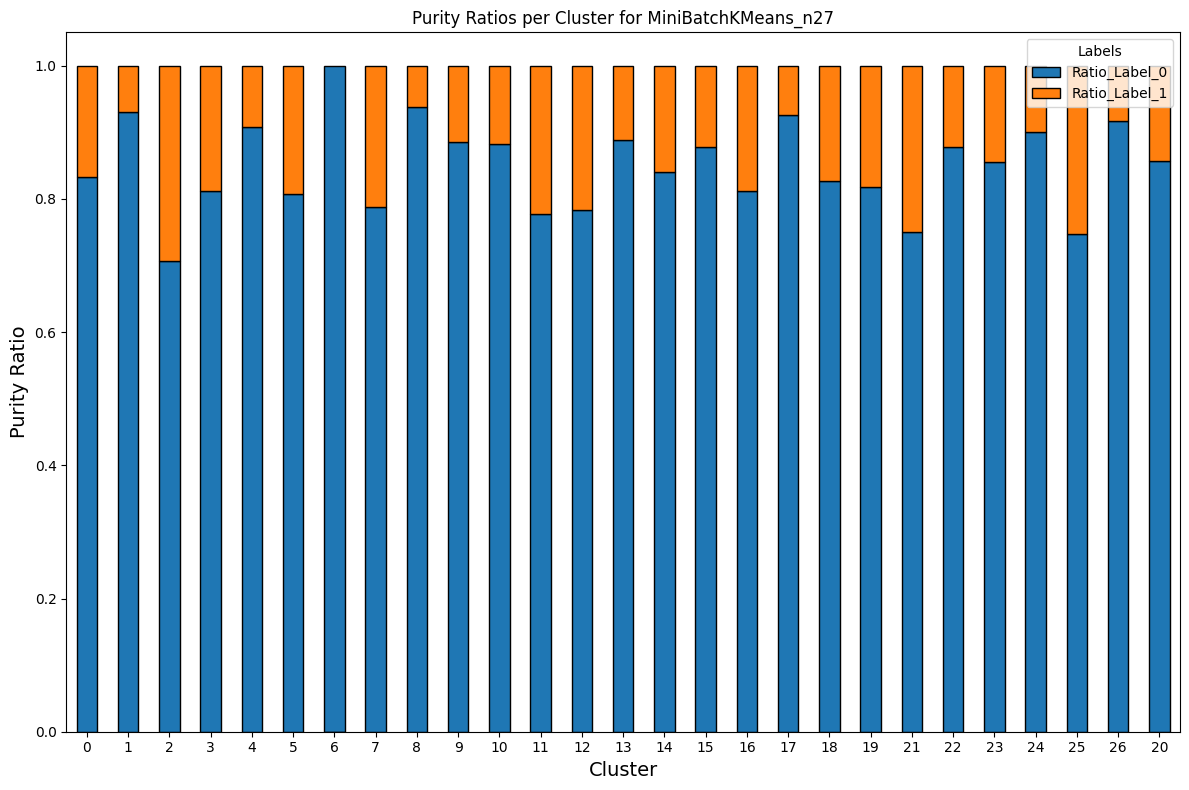

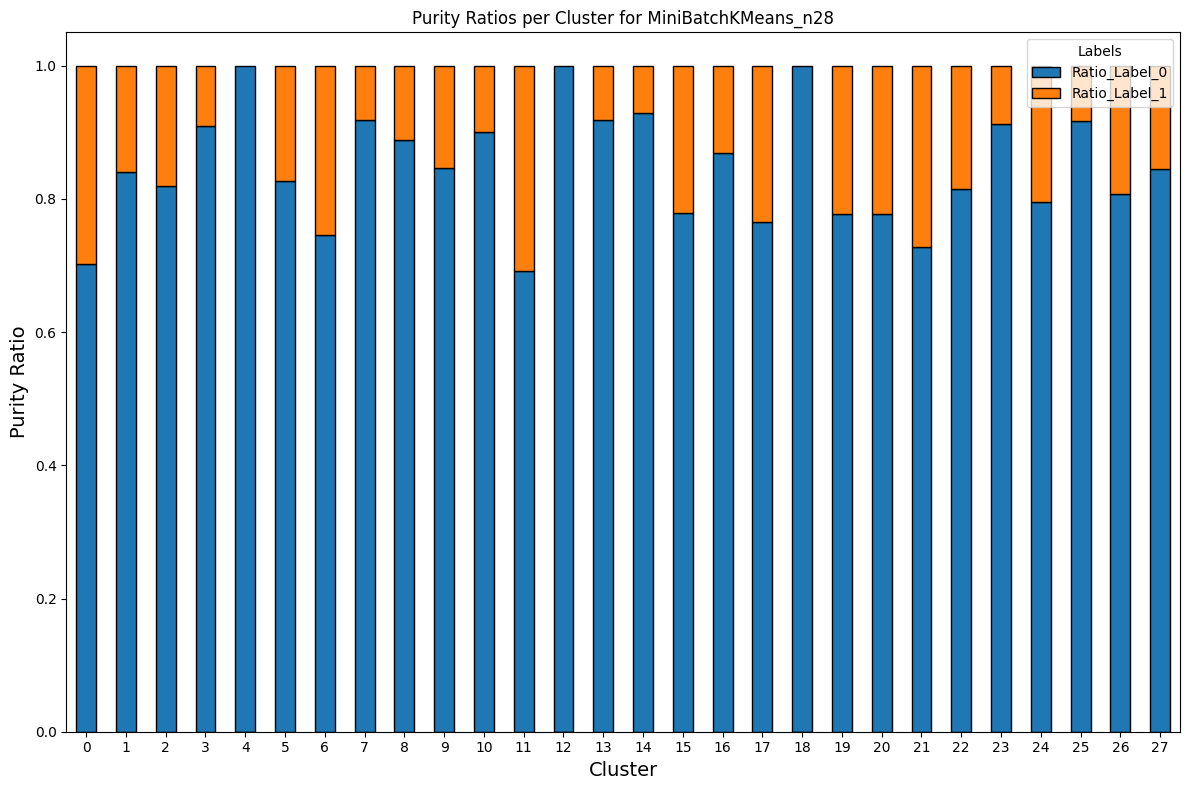

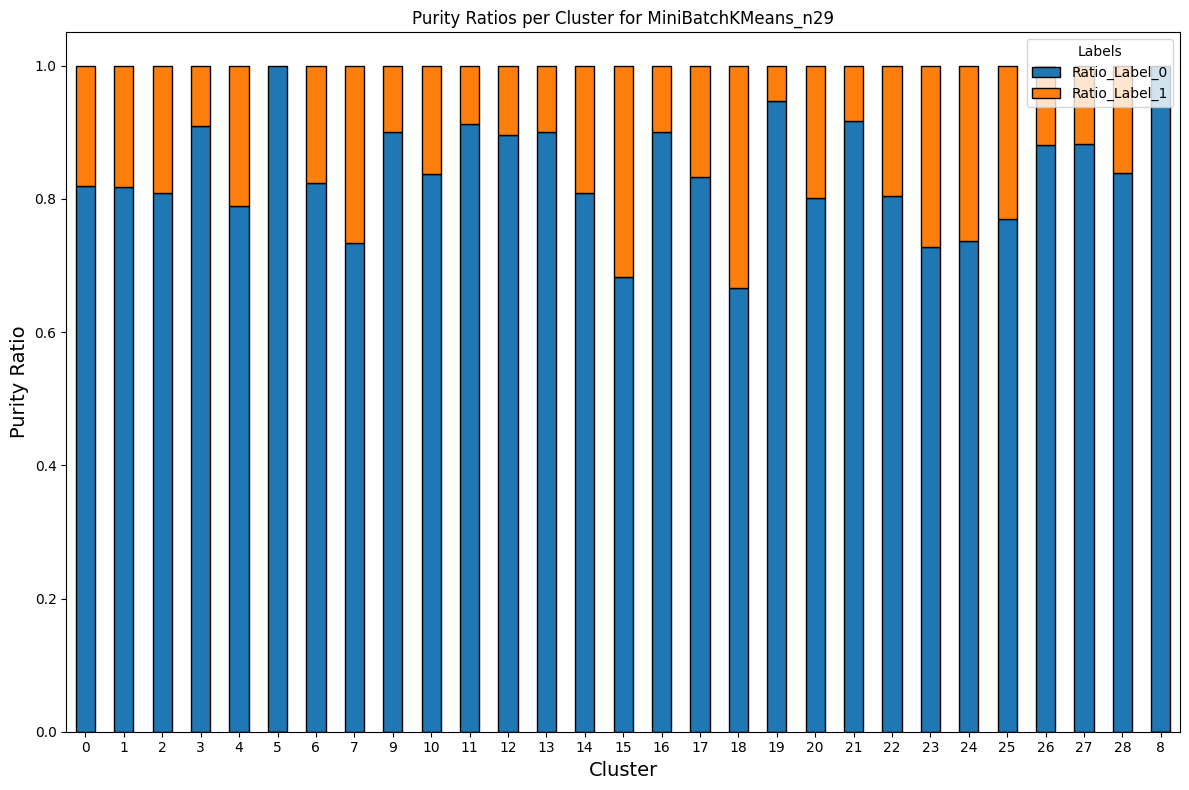

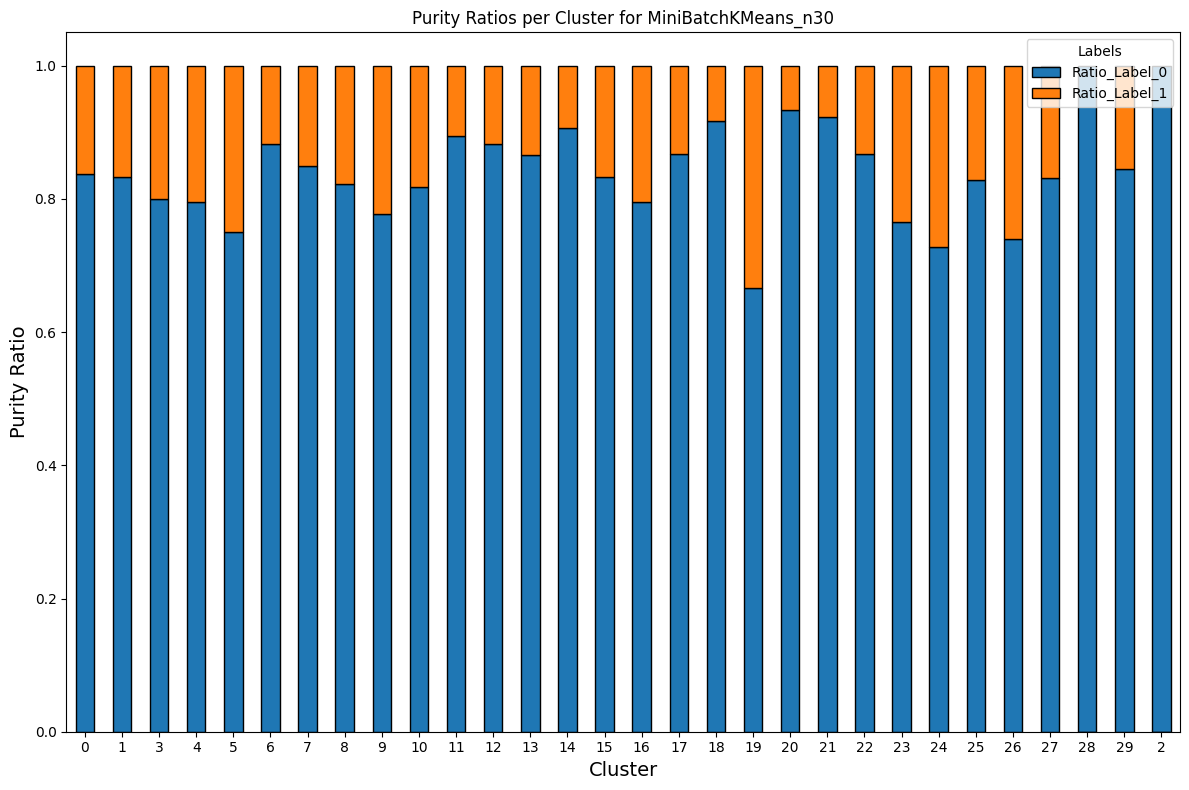

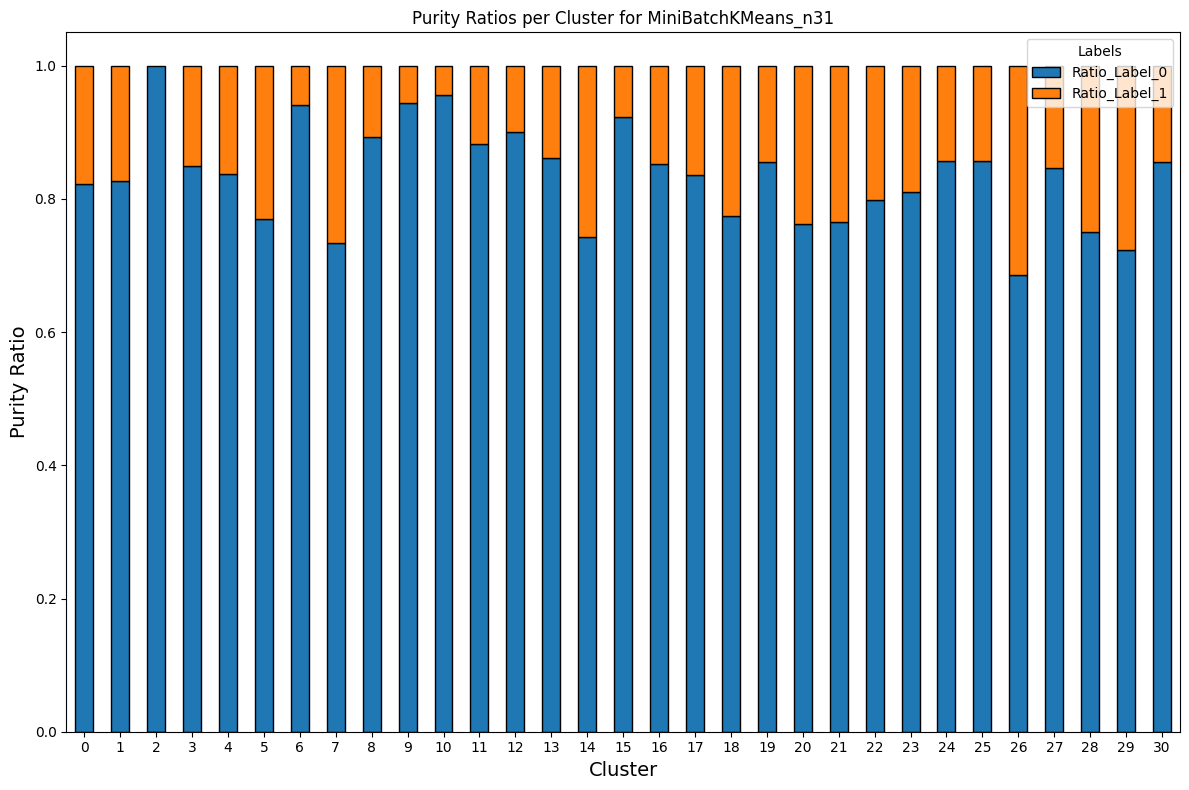

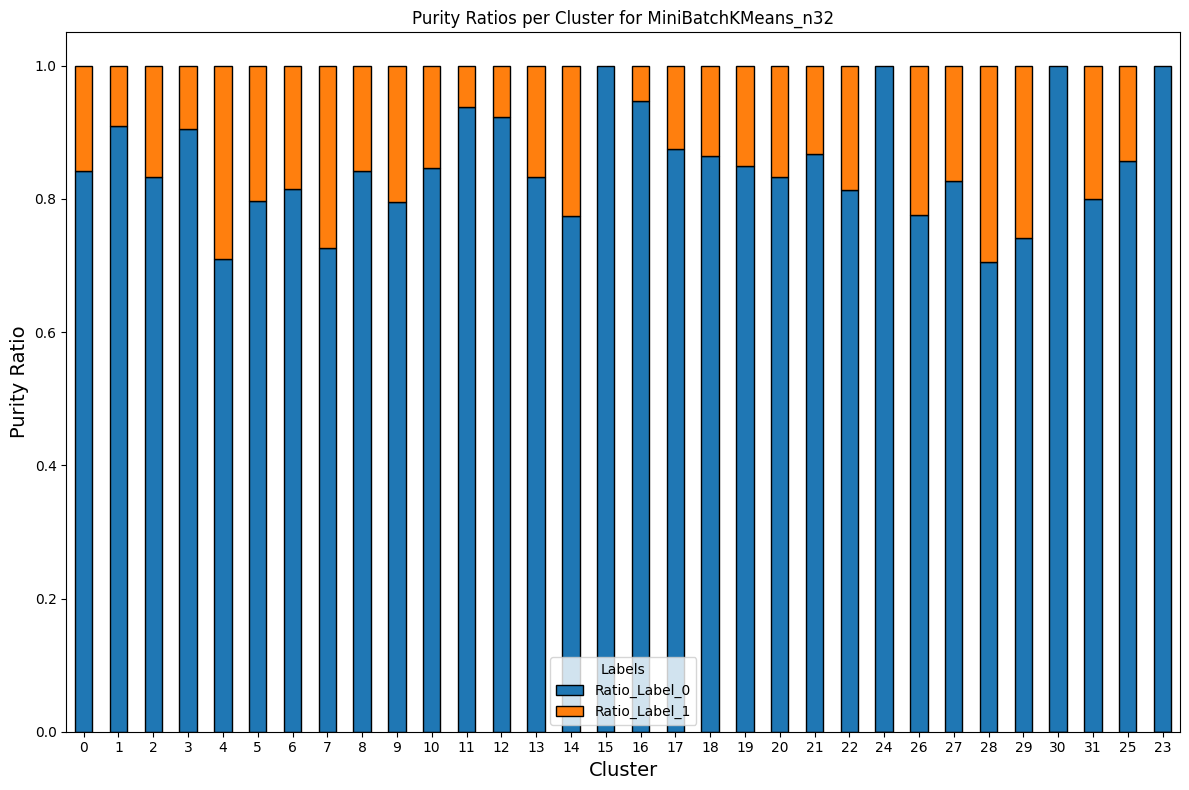

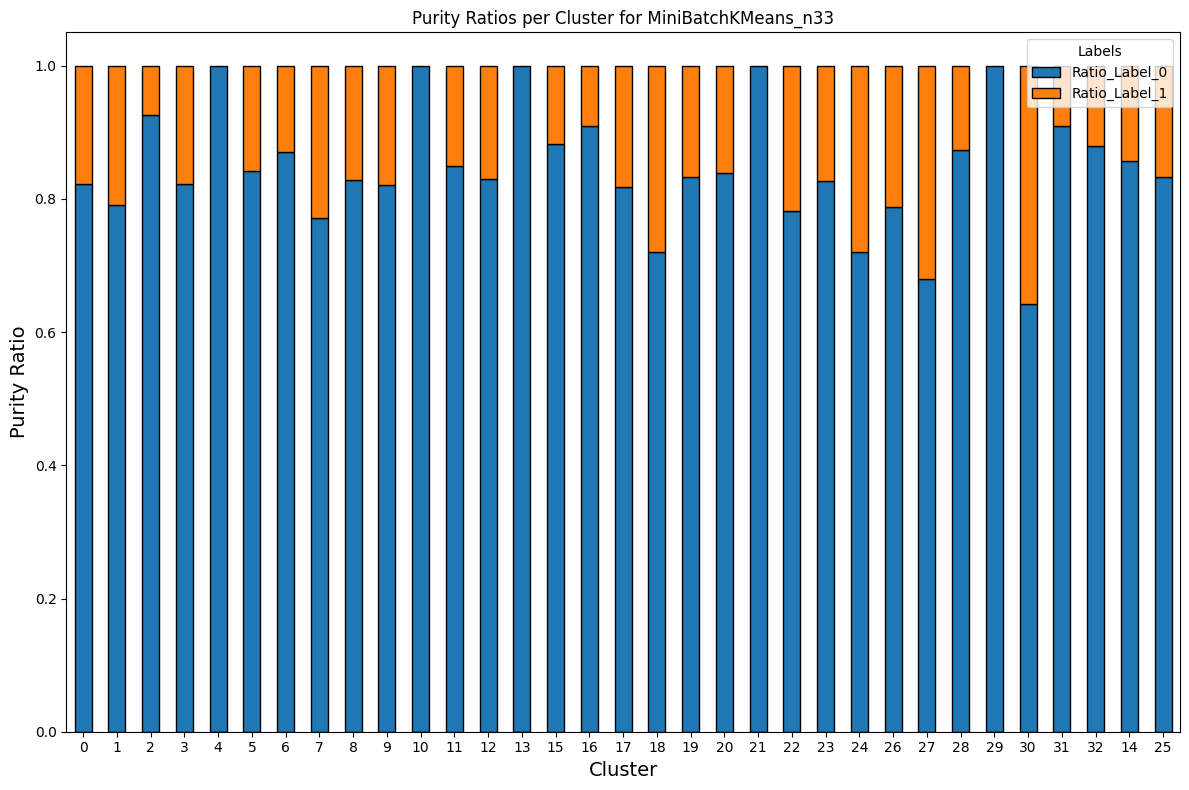

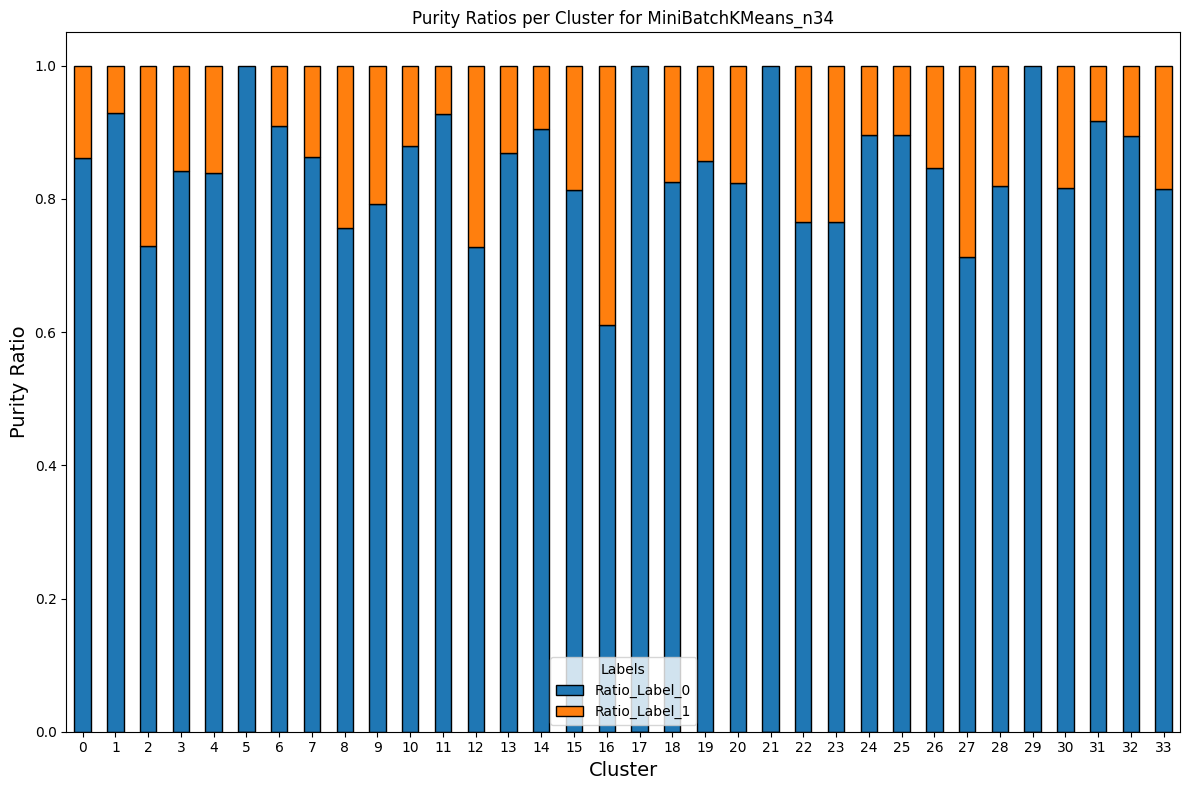

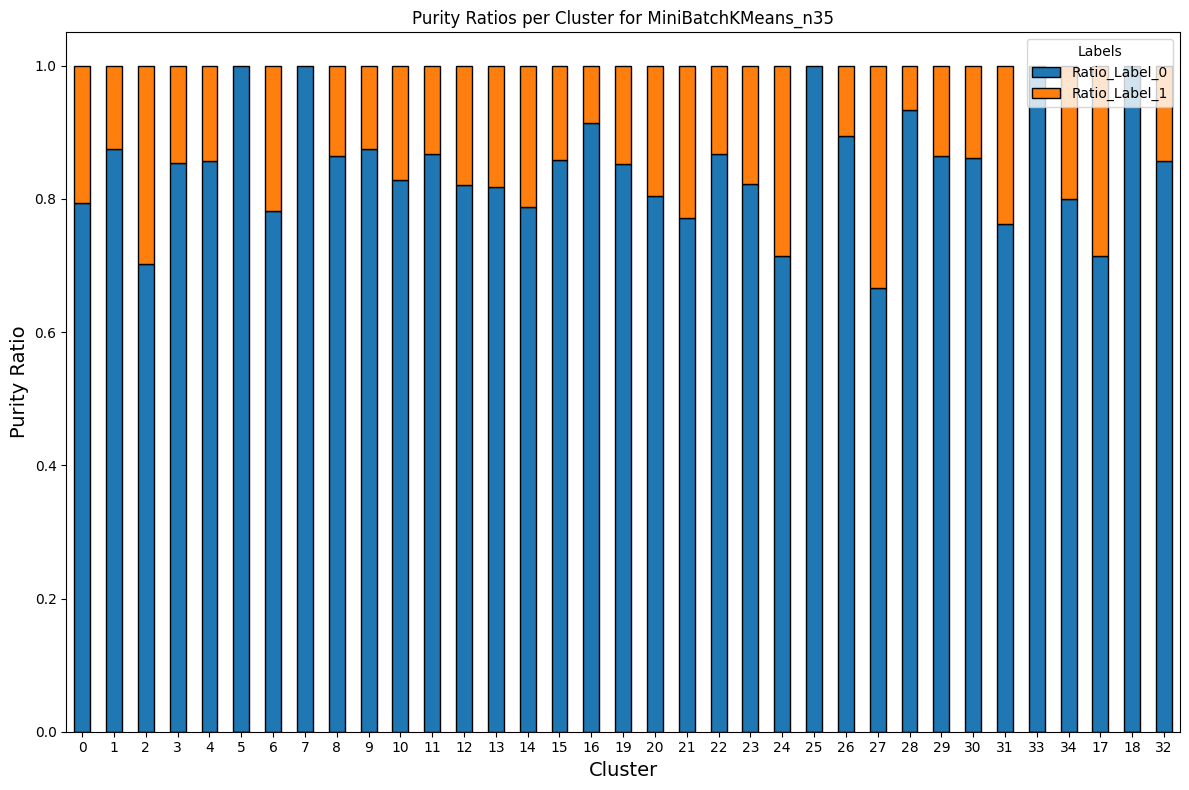

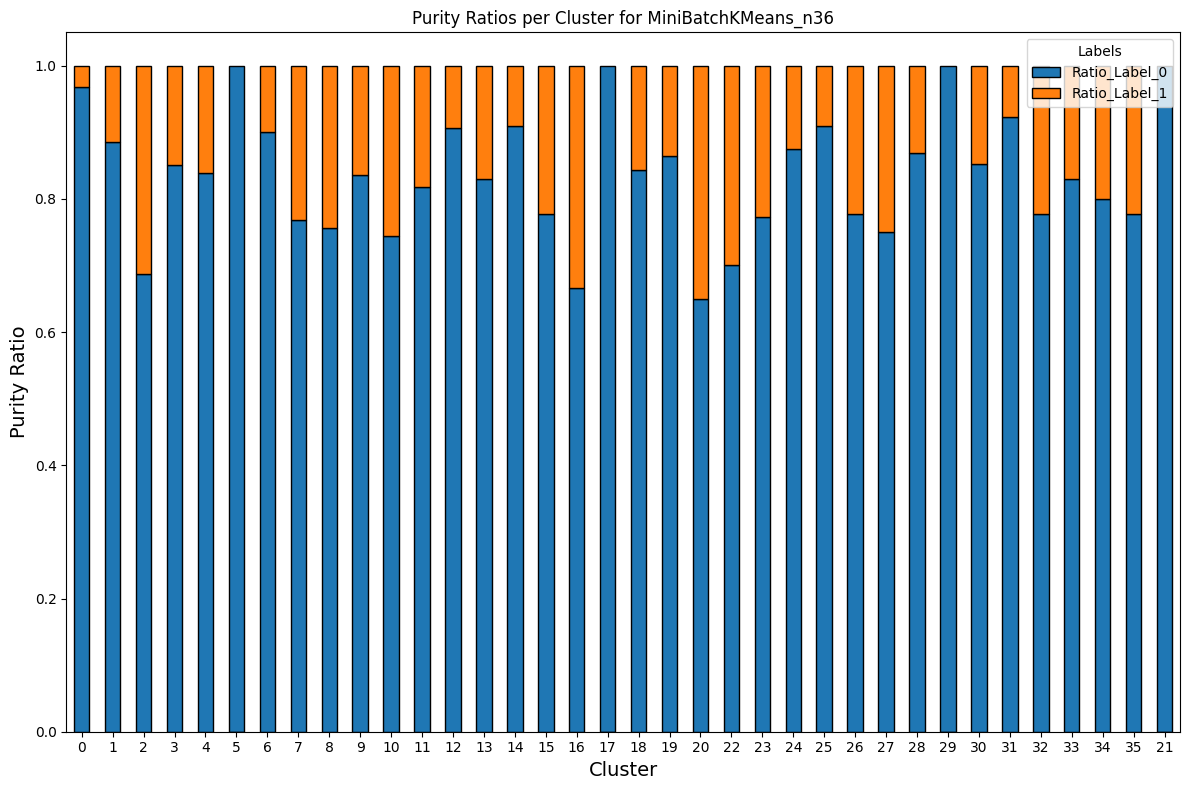

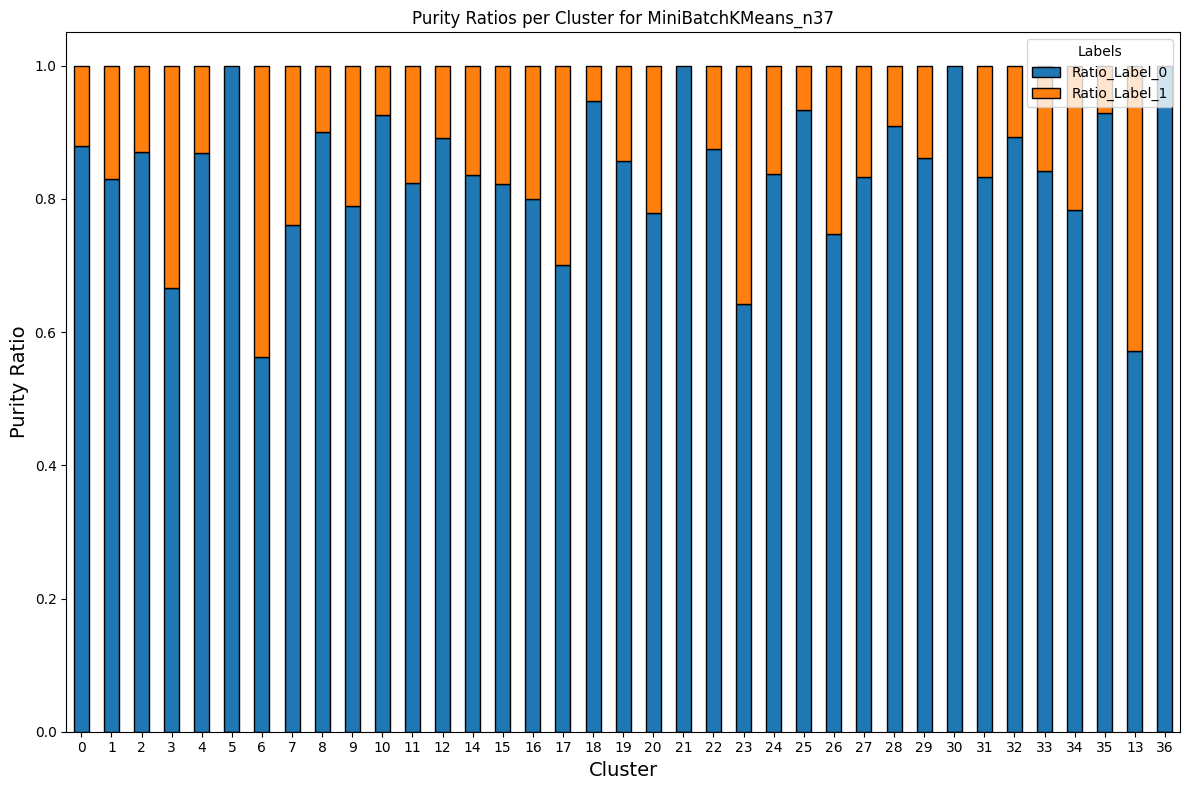

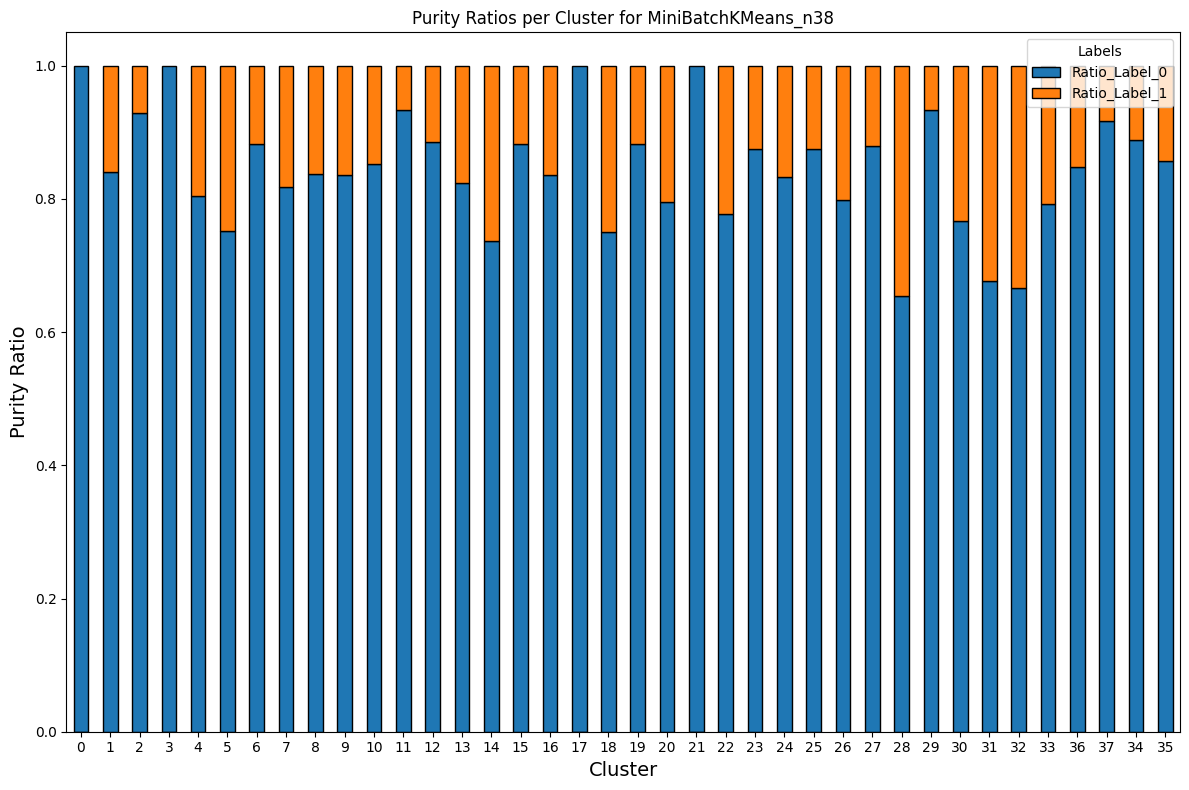

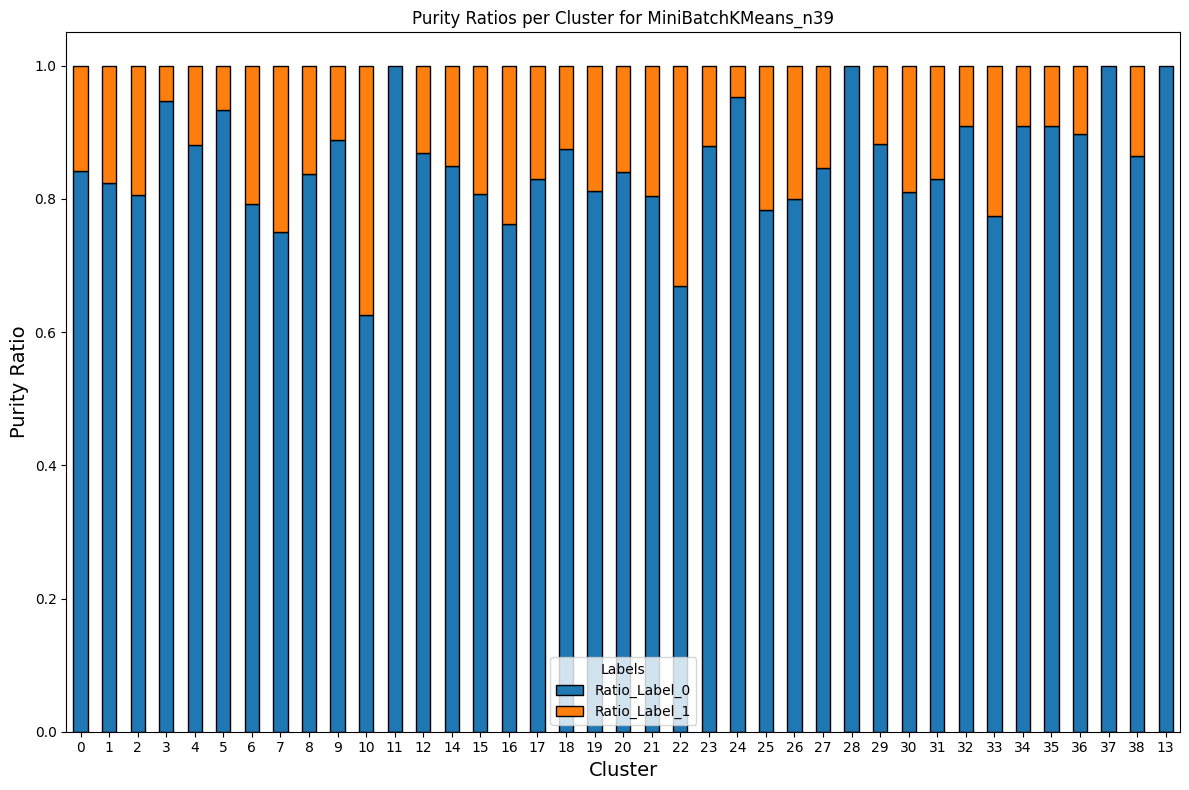

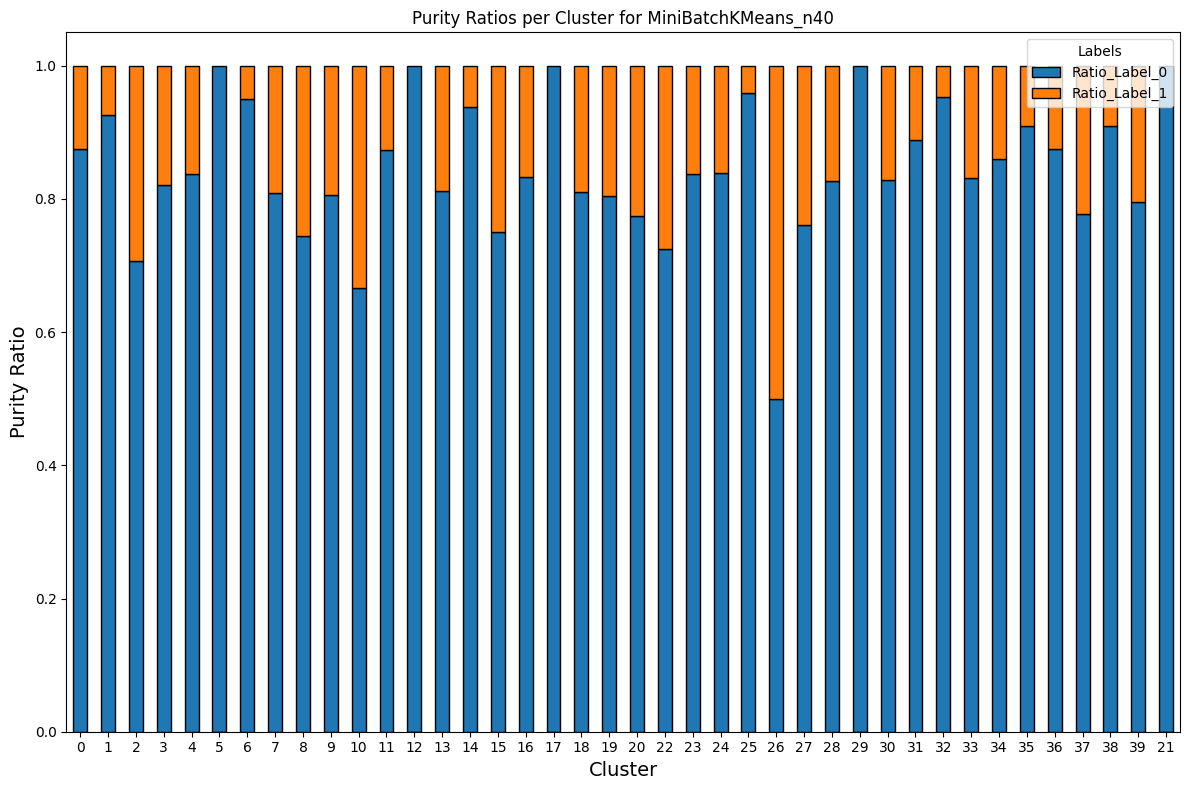

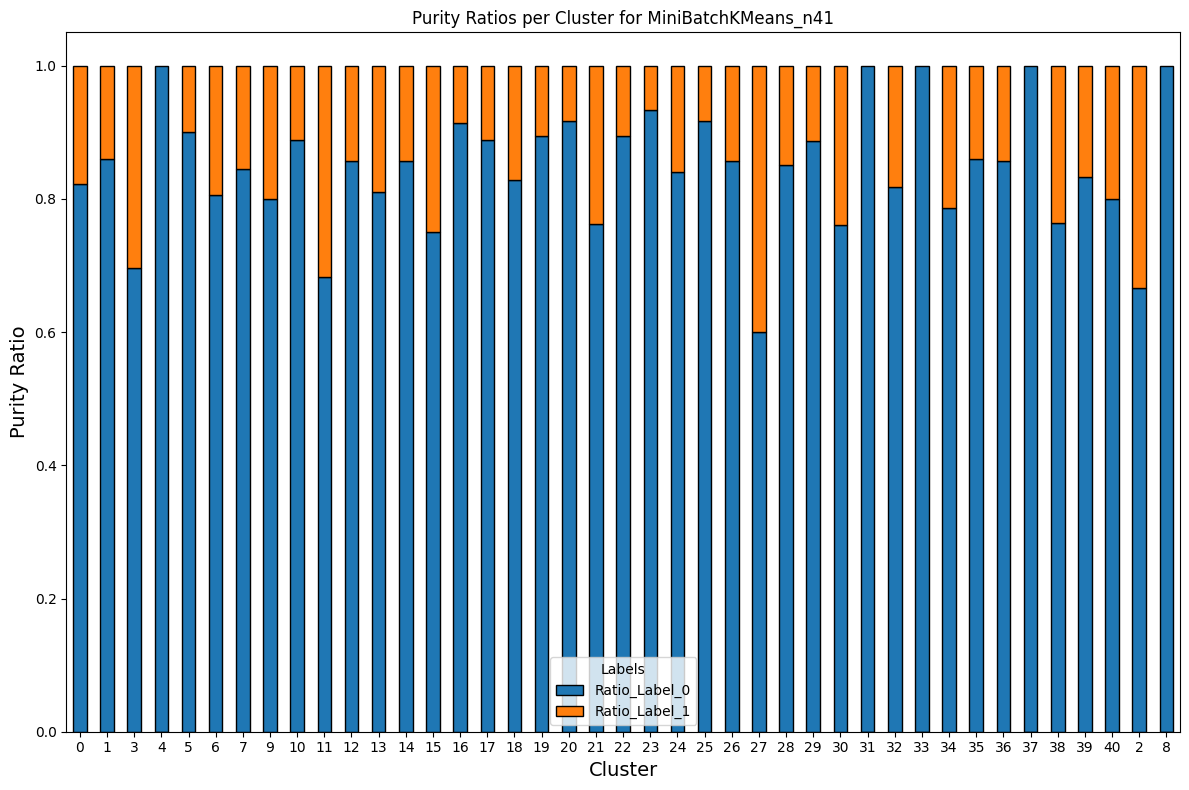

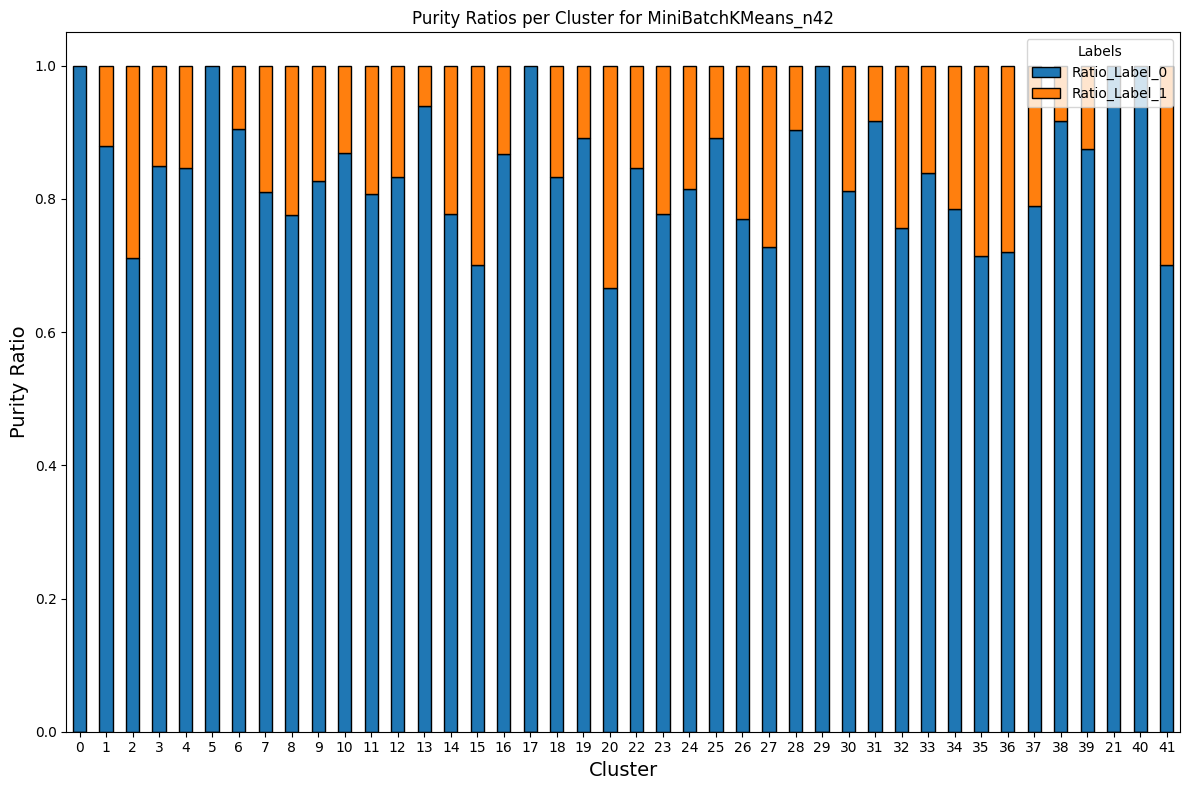

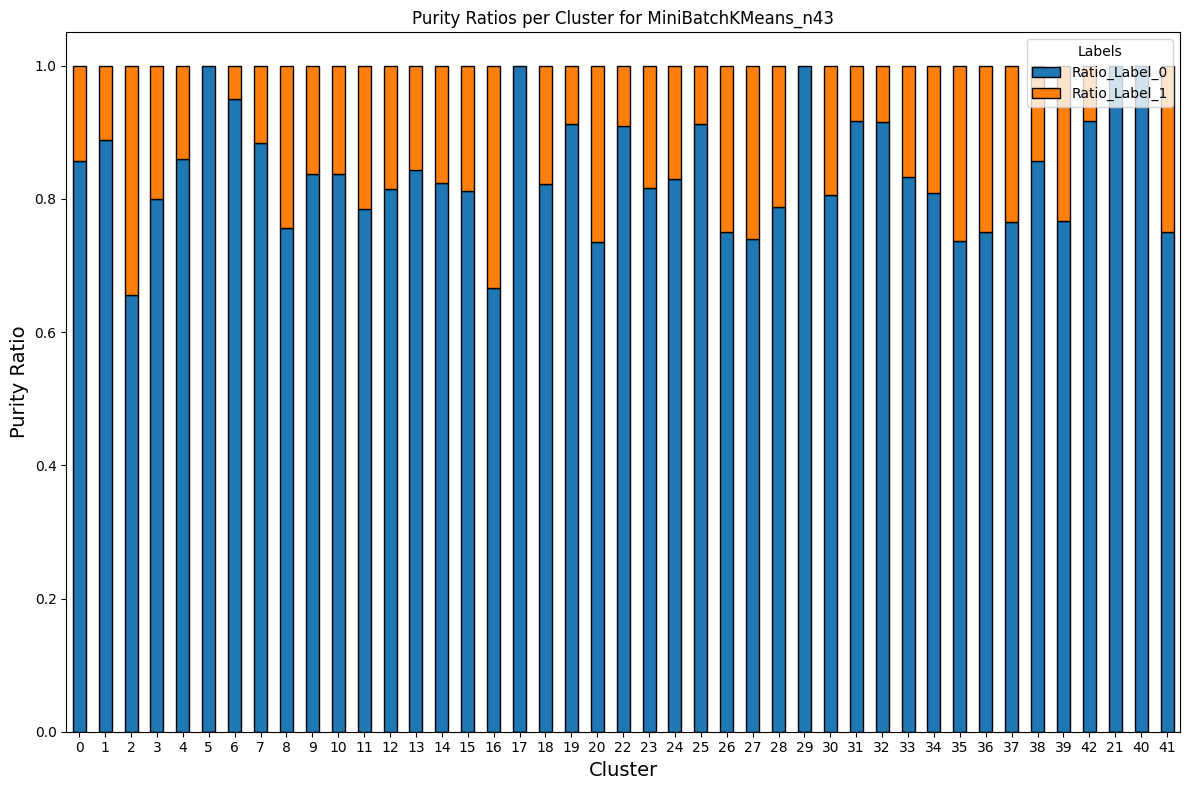

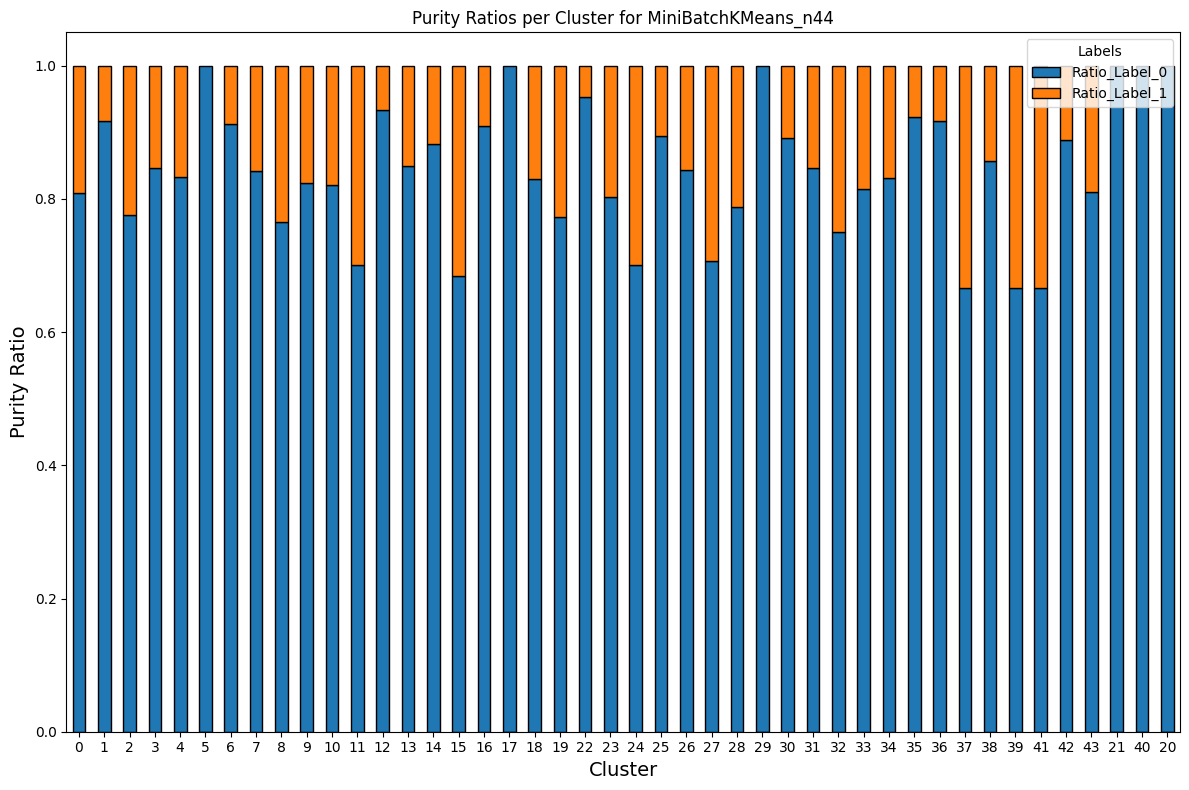

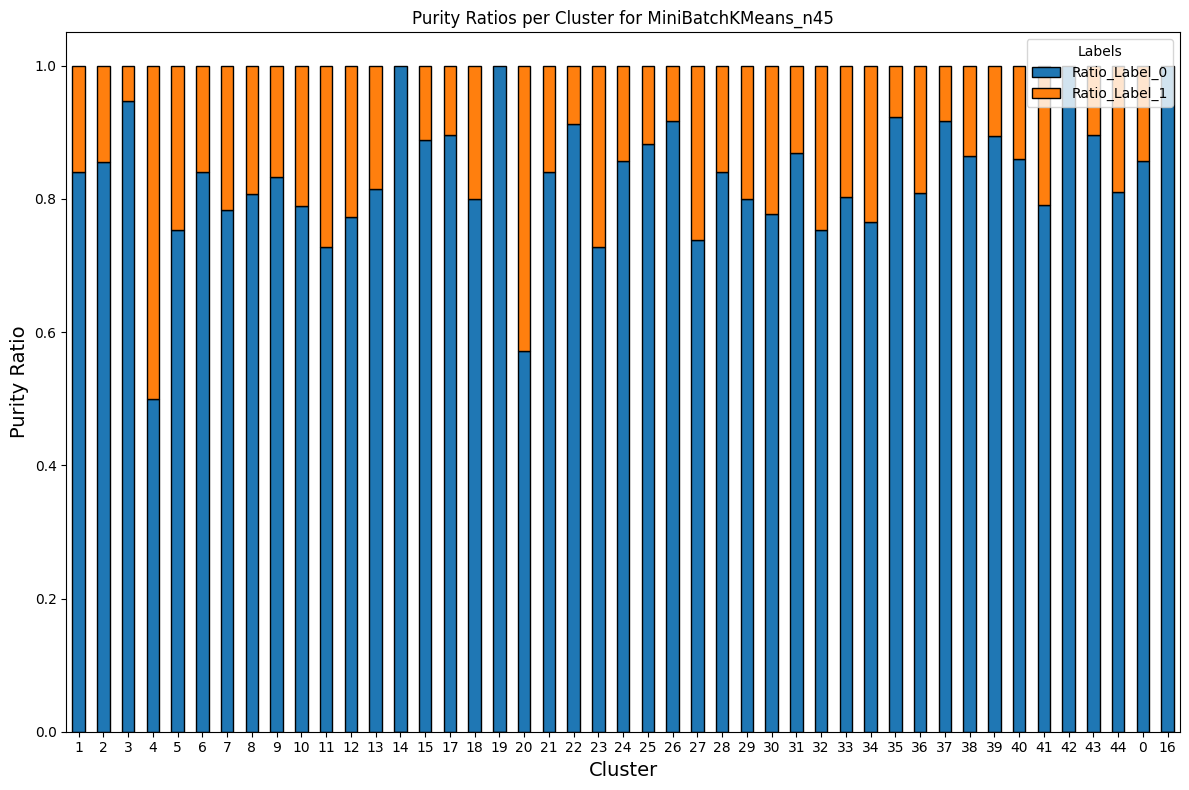

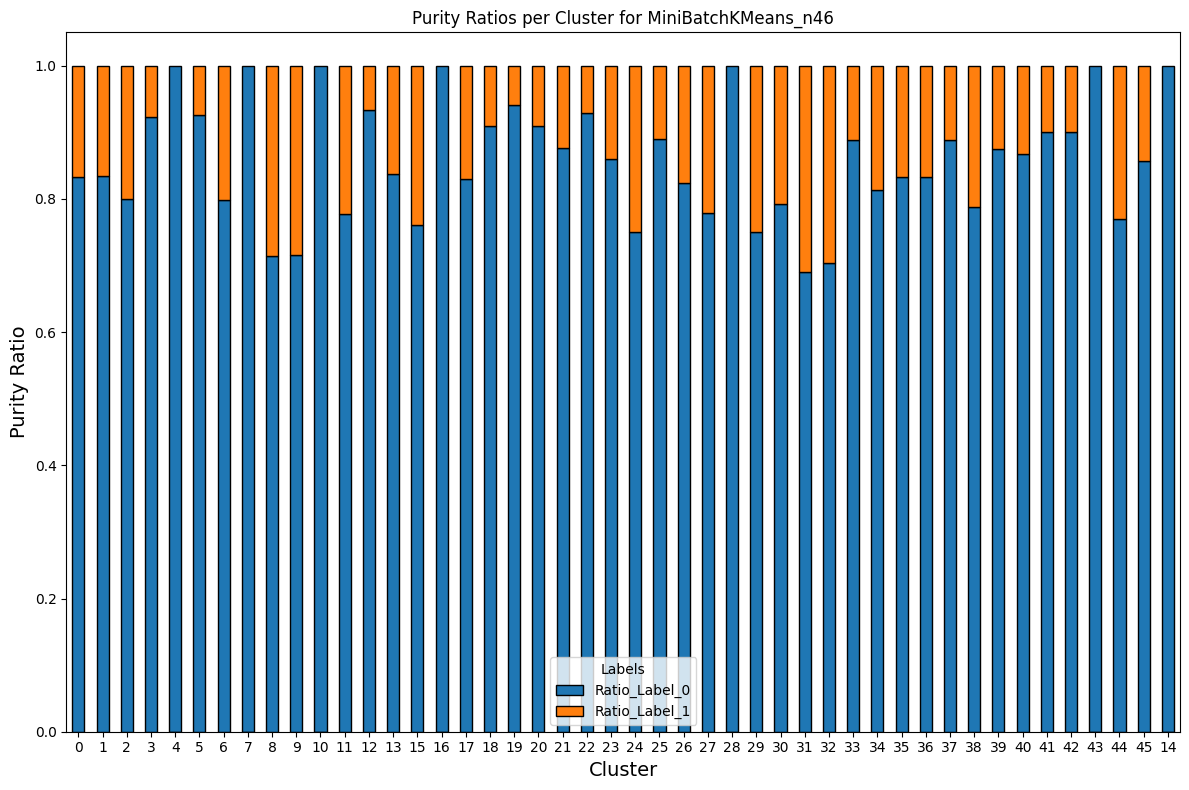

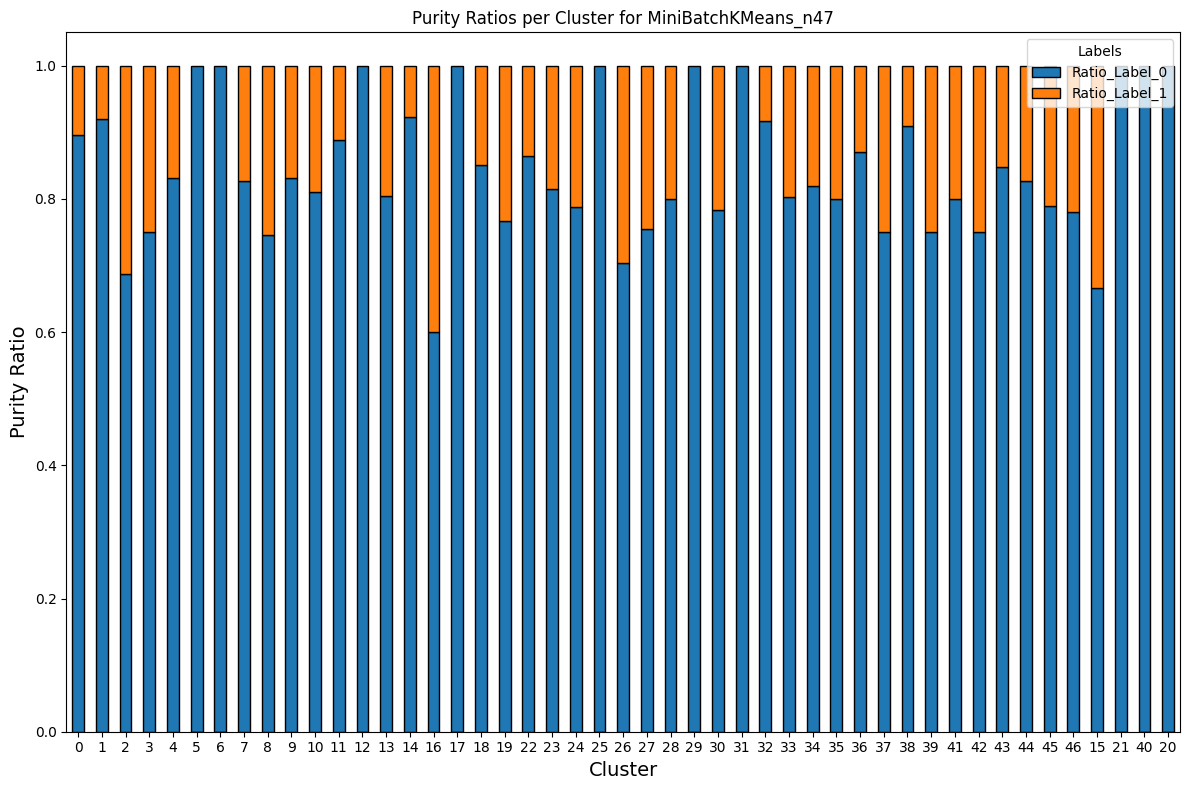

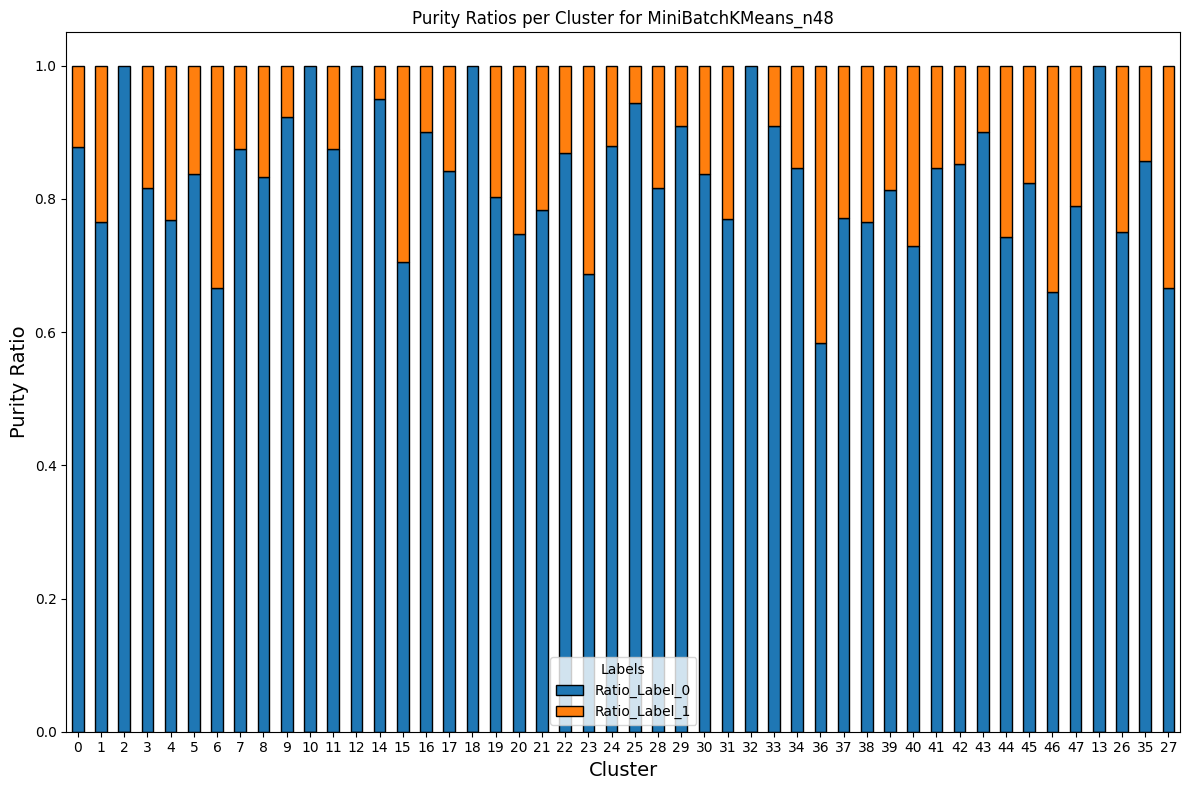

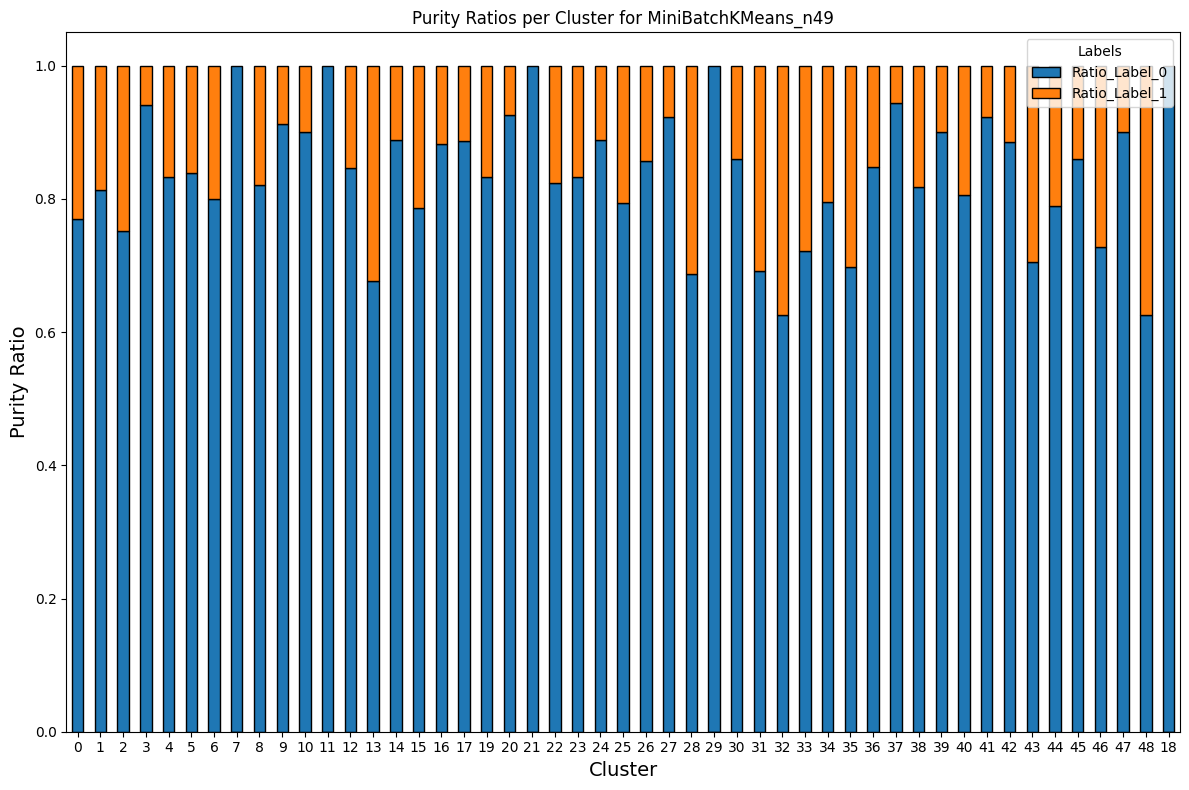

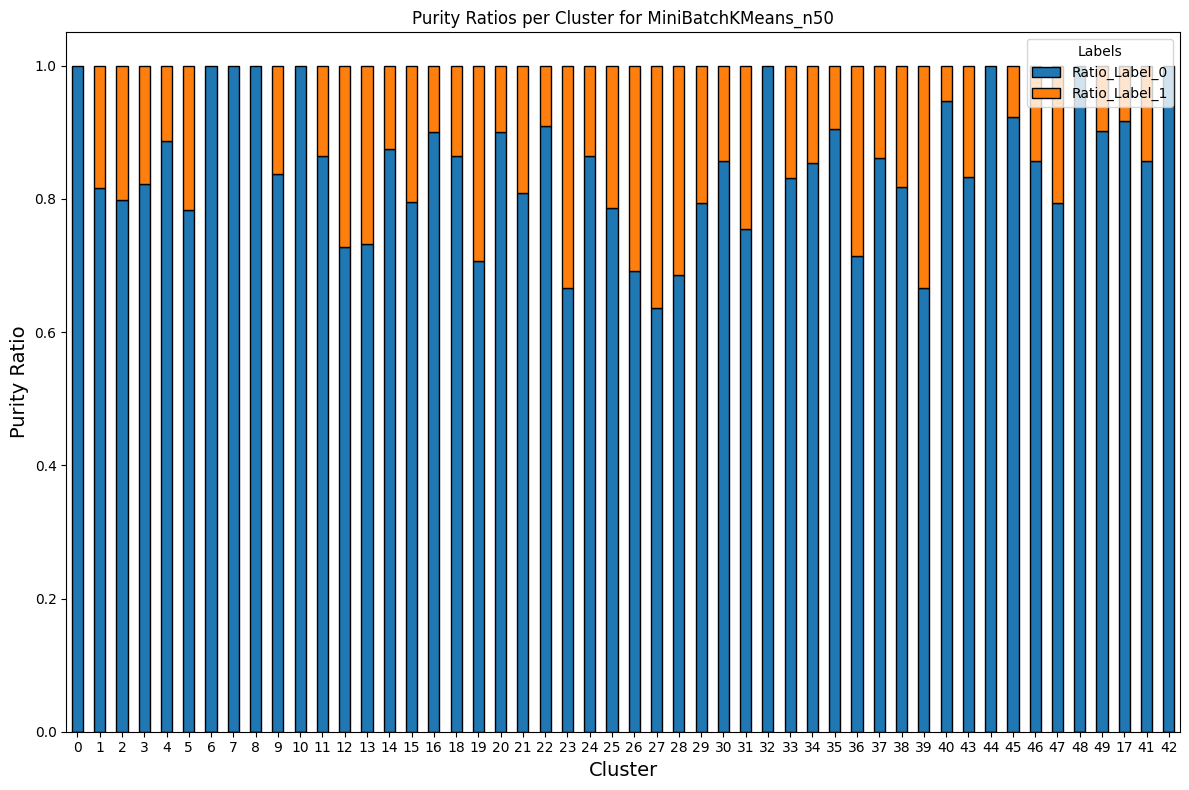

Cluster  Count_Label_0  Count_Label_1  Ratio_Label_0  Ratio_Label_1  \
0           0           1348            322       0.807186       0.192814   
1           1            632            118       0.842667       0.157333   
2           0           1335            279       0.827138       0.172862   
3           1            389            119       0.765748       0.234252   
4           2            256             42       0.859060       0.140940   
...       ...            ...            ...            ...            ...   
1269       48              4              0       1.000000       0.000000   
1270       49             37              4       0.902439       0.097561   
1271       17             11              1       0.916667       0.083333   
1272       41              6              1       0.857143       0.142857   
1273       42              6              0       1.000000       0.000000   

                Algorithm  n_clusters  
0      MiniBatchKMeans_n2           2  
1      MiniBatchKMeans_n2           2  
2      MiniBatchKMeans_n3           3  
3      MiniBatchKMeans_n3           3  
4      MiniBatchKMeans_n3           3  
...                   ...         ...  
1269  MiniBatchKMeans_n50          50  
1270  MiniBatchKMeans_n50          50  
1271  MiniBatchKMeans_n50          50  
1272  MiniBatchKMeans_n50          50  
1273  MiniBatchKMeans_n50          50  

[1274 rows x 7 columns]

In [54]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 51, 1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=data,
    labels=pancreas_vs_background_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Running on All Flattened Data

### KMeans for range(2, 100, 2) Clusters

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 102, 2)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=full_pca_data,
    labels=pancreas_vs_background_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

In [ ]:
count_zeros = (pancreas_vs_background_labels == 0).sum().item()
count_ones = (pancreas_vs_background_labels == 1).sum().item()

print(count_zeros, count_ones)

print(count_zeros / len(pancreas_vs_background_labels), count_ones / len(pancreas_vs_background_labels))

### OPTICS

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import OPTICS

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'OPTICS_{n_clusters}'
    mbk = OPTICS(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

### HDBSCAN

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from hdbscan import HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'hdbscan_{n_clusters}'
    mbk = HDBSCAN(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Pairwise Similarities

### Between Middle Vectors

In [72]:
import numpy as np


def compute_cosine_similarity(matrix):
    """
    Compute the pairwise cosine similarity matrix for a 2D NumPy array.

    Parameters:
    - matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_features).

    Returns:
    - cosine_sim_matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_samples) containing cosine similarities.
    """
    # Step 1: Normalize the matrix
    # Add a small epsilon to avoid division by zero
    norm = np.linalg.norm(matrix, axis=1, keepdims=True) + 1e-10
    normalized_matrix = matrix / norm

    # Step 2: Compute cosine similarity as dot product of normalized vectors
    cosine_sim_matrix = np.dot(normalized_matrix, normalized_matrix.T)

    return cosine_sim_matrix

In [73]:
middle_vector_dot_products = torch.mm(middle_vectors_full_pca, middle_vectors_full_pca.T)

In [76]:
middle_vector_cosines = compute_cosine_similarity(middle_vectors_full_pca.numpy())

In [ ]:
middle_vector_dot_products

In [ ]:
pd.DataFrame(middle_vector_dot_products.numpy()).describe()

In [ ]:
pd.DataFrame(middle_vector_cosines).describe()

In [ ]:
plt.imshow(middle_vector_cosines, cmap='hot')#, interpolation='nearest')

### Between Vectors within same CT

In [ ]:
flat_cts = all_encoded_cubes[0]

flat_cts.shape

In [ ]:
first_ct_flattened = flatten_features(flat_cts.unsqueeze(0))

first_ct_flattened.shape

## Check for Repeat/High Similarity Vectors

Do this for within a CT scan

- [] TODO

In [38]:
import numpy as np

res, counts = np.unique(full_pca_data, axis=0, return_counts=True)

In [ ]:
counts

In [ ]:
pd.DataFrame(counts).value_counts()

In [ ]:
full_data_df.value_counts()

# Saving Clusters as ITK-SNAP Annotations Code

In [31]:
import xml.etree.ElementTree as ET
import os

def save_clusters_as_itk_snap_annotations(points, clusters, base_dir="results/itk-snap-annotations", filename='annotations.annot', slice_range=10, image_size=512):
    """
    Saves 3D points as annotations on multiple slices in an .annot file for ITK-SNAP.

    Parameters:
    - points (np.ndarray): Array of shape (n_points, 3) containing x, y, z coordinates.
    - clusters (np.ndarray): Array of shape (n_points,) containing cluster labels (integers).
    - filename (str): Output filename for the .annot file.
    - slice_range (int): Number of slices above and below the point to create annotations.
    - image_size (int or tuple): Size of the image (assumed cubic if int, or specify (x_size, y_size, z_size)).
    """
    if points.shape[0] != clusters.shape[0]:
        raise ValueError("Number of points and clusters must be the same.")

    n_points = points.shape[0]

    # Define fixed red color for all annotations
    color = "1 0 0"  # Fully red

    # Initialize XML structure
    registry = ET.Element('registry')

    # Add header entries
    ET.SubElement(registry, 'entry', key="Format", value="ITK-SNAP Annotation File")
    ET.SubElement(registry, 'entry', key="FormatDate", value="20241014")  # FormatDate as YYYYMMDD

    # Annotations folder
    annotations_folder = ET.SubElement(registry, 'folder', key="Annotations")
    element_counter = 0  # To keep track of Element[n] keys

    # Determine image dimensions
    if isinstance(image_size, int):
        x_max = y_max = z_max = image_size
    elif isinstance(image_size, tuple) and len(image_size) == 3:
        x_max, y_max, z_max = image_size
    else:
        raise ValueError("image_size must be an int or a tuple of three ints.")

    for i in range(n_points):
        x, y, z = points[i]
        cluster = clusters[i]

        # For each plane
        for plane in range(3):
            if plane == 0:  # Sagittal plane (X axis)
                coord = int(round(x))
                coord_min = max(0, coord - slice_range)
                coord_max = min(x_max - 1, coord + slice_range)
            elif plane == 1:  # Coronal plane (Y axis)
                coord = int(round(y))
                coord_min = max(0, coord - slice_range)
                coord_max = min(y_max - 1, coord + slice_range)
            elif plane == 2:  # Axial plane (Z axis)
                coord = int(round(z))
                coord_min = max(0, coord - slice_range)
                coord_max = min(z_max - 1, coord + slice_range)

            # Loop over the coordinate range
            for c in range(coord_min, coord_max + 1):
                element_key = f"Element[{element_counter}]"
                element_folder = ET.SubElement(annotations_folder, 'folder', key=element_key)

                # Position adjusted for the current slice
                if plane == 0:
                    pos = f"{float(c)} {float(y)} {float(z)}"
                elif plane == 1:
                    pos = f"{float(x)} {float(c)} {float(z)}"
                elif plane == 2:
                    pos = f"{float(x)} {float(y)} {float(c)}"

                # Define entries for LandmarkAnnotation
                ET.SubElement(element_folder, 'entry', key="Color", value=color)
                ET.SubElement(element_folder, 'entry', key="Offset", value="0 0")  # No offset
                ET.SubElement(element_folder, 'entry', key="Plane", value=str(plane))
                ET.SubElement(element_folder, 'entry', key="Pos", value=pos)
                ET.SubElement(element_folder, 'entry', key="Selected", value="0")
                ET.SubElement(element_folder, 'entry', key="Tags", value="")
                ET.SubElement(element_folder, 'entry', key="Text", value=str(cluster))  # Removed "Cluster"
                ET.SubElement(element_folder, 'entry', key="Type", value="LandmarkAnnotation")
                ET.SubElement(element_folder, 'entry', key="VisibleInAllPlanes", value="1")  # Visible in all planes
                ET.SubElement(element_folder, 'entry', key="VisibleInAllSlices", value="0")  # Visible only on this slice

                element_counter += 1

    # Update ArraySize to reflect the actual number of elements
    ET.SubElement(annotations_folder, 'entry', key="ArraySize", value=str(element_counter))

    # Create the DOCTYPE declaration
    doctype = '''<!DOCTYPE registry [
<!ELEMENT registry (entry*,folder*)>
<!ELEMENT folder (entry*,folder*)>
<!ELEMENT entry EMPTY>
<!ATTLIST folder key CDATA #REQUIRED>
<!ATTLIST entry key CDATA #REQUIRED>
<!ATTLIST entry value CDATA #REQUIRED>
]>'''

    # Generate the XML tree
    tree = ET.ElementTree(registry)

    # Write to file with XML declaration and DOCTYPE
    with open(os.path.join(base_dir, filename), 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
        f.write(doctype + '\n')
        tree.write(f, encoding='unicode')

    total_annotations = element_counter
    print(f"Successfully saved {total_annotations} LandmarkAnnotations to '{filename}'.")

# Plotting 🗾

### Function Definitions (Long) 📚

Functions for:

- Plotting 2D, with labels and cluster centroids
- Plotting 3D, with labels and cluster centroids
- 3D Interactive plot of the same
- Saving to ITK-SNAP landmarks

In [53]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

organs_dict = {
    'unlabeled/background': 0,
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

reverse_organs_dict = {v: k for k, v in organs_dict.items()}

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap for up to 10 colors

    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create a reverse mapping for hover information
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=point_colors, s=50, alpha=0.7)

    # Add hover information (using mplcursors for interactivity)
    try:
        import mplcursors
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(label_names[sel.index]))
    except ImportError:
        print("mplcursors is not installed. Hover functionality is disabled.")

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')

    used_colors = {}
    centroid_labels = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so multiply by 2
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid as 'X'
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label='Centroid')
        used_colors['Centroid'] = cmap(i)
        centroid_labels.append('Centroid')

    # Create legend for ground truth labels
    label_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                   markerfacecolor=color, markersize=10) 
        for label, color in label_colors.items()
    ]

    # Create legend for centroids
    centroid_handles = [
        plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                   markerfacecolor=used_colors['Centroid'], markersize=10)
    ]

    # Combine both legends
    plt.legend(handles=label_handles + centroid_handles, loc='best')
    plt.grid(True)
    plt.show()        
# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for ground truth labels using organs_dict
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap
    
    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create label names for hover and legend
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=point_colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')
    
    centroids = []
    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label='Centroid')

    # Create legend for ground truth labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids (single entry)
    centroid_handle = plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                                 markerfacecolor='black', markersize=10)
    
    # Combine legends
    ax.legend(handles=handles + [centroid_handle], loc='best')
    plt.show()

import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from typing import Optional, Tuple

def plot_interactive_3d_scatter(
    coordinates: np.ndarray,
    cluster_labels: np.ndarray,
    ground_truth_labels: Optional[np.ndarray] = None,
    axis_min: Optional[Tuple[int, int, int]] = (-25, -25, -25),
    axis_max: Optional[Tuple[int, int, int]] = (50, 50, 50),
    title: str = "Interactive 3D Scatter Plot",
    show_legend: bool = True
):
    """
    Plots an interactive 3D scatter plot with detailed legends for each ground truth organ and cluster centroids.

    Parameters:
    - coordinates (np.ndarray): Array of shape (n, 3) representing 3D coordinates.
    - cluster_labels (np.ndarray): Array of shape (n,) containing cluster assignments for each point.
    - ground_truth_labels (Optional[np.ndarray]): Array of shape (n,) containing ground truth labels for each point.
    - axis_range (Optional[Tuple[int, int, int]]): Tuple specifying the max range for x, y, z axes. Defaults to (512, 512, 512).
    - title (str): Title of the plot.
    - show_legend (bool): Whether to display the legend.

    Returns:
    - A Plotly Figure object displaying the interactive 3D scatter plot.
    """

    # Validate input dimensions
    if coordinates.ndim != 2 or coordinates.shape[1] != 3:
        raise ValueError("Coordinates array must be of shape (n, 3).")

    n_points = coordinates.shape[0]

    if cluster_labels.ndim != 1 or cluster_labels.shape[0] != n_points:
        raise ValueError("cluster_labels must be a 1D array with the same length as coordinates.")

    if ground_truth_labels is not None:
        if ground_truth_labels.ndim != 1 or ground_truth_labels.shape[0] != n_points:
            raise ValueError("ground_truth_labels must be a 1D array with the same length as coordinates.")

    # Extract X, Y, Z coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]

    # Handle ground truth labels
    if ground_truth_labels is not None:
        unique_gt = np.unique(ground_truth_labels)
        num_gt = len(unique_gt)
        gt_color_palette = px.colors.qualitative.Light24
        if num_gt > len(gt_color_palette):
            extended_gt_palette = gt_color_palette * (num_gt // len(gt_color_palette) + 1)
        else:
            extended_gt_palette = gt_color_palette
        gt_colors = {gt: extended_gt_palette[i] for i, gt in enumerate(unique_gt)}
    else:
        gt_colors = {}

    # Create ground truth traces
    data = []
    if ground_truth_labels is not None:
        for gt in unique_gt:
            organ_name = reverse_organs_dict.get(int(gt), f'Label {gt}')
            indices = np.where(ground_truth_labels == gt)[0]
            trace = go.Scatter3d(
                x=x[indices],
                y=y[indices],
                z=z[indices],
                mode='markers',
                marker=dict(
                    size=5,
                    color=gt_colors[gt],
                    opacity=0.8
                ),
                name=organ_name,
                hovertemplate=
                    "<b>Organ:</b> %{text}<br>" +
                    "<b>X:</b> %{x:.2f}<br>" +
                    "<b>Y:</b> %{y:.2f}<br>" +
                    "<b>Z:</b> %{z:.2f}<br>" +
                    "<extra></extra>",
                text=[organ_name] * len(indices)
            )
            data.append(trace)
    else:
        # If no ground truth labels, plot all points with a single color
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color='blue',
                opacity=0.8
            ),
            name='Data Points',
            hovertemplate=
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
        )
        data.append(trace)

    # Calculate and plot centroids as 'X'
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    color_palette = px.colors.qualitative.Plotly
    if num_clusters > len(color_palette):
        extended_palette = color_palette * (num_clusters // len(color_palette) + 1)
    else:
        extended_palette = color_palette
    cluster_colors = {cluster: extended_palette[i] for i, cluster in enumerate(unique_clusters)}

    centroids = []
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if len(indices) == 0:
            continue
        centroid = coordinates[indices].mean(axis=0)
        centroids.append({
            'cluster': cluster,
            'x': centroid[0],
            'y': centroid[1],
            'z': centroid[2],
            'color': cluster_colors[cluster]
        })

    if centroids:
        centroid_trace = go.Scatter3d(
            x=[c['x'] for c in centroids],
            y=[c['y'] for c in centroids],
            z=[c['z'] for c in centroids],
            mode='markers',
            marker=dict(
                size=8,
                color=[c['color'] for c in centroids],
                symbol='x',
                line=dict(width=2),
                opacity=1.0
            ),
            name='Centroids',
            hovertemplate=
                "<b>Centroid of Cluster:</b> %{text}<br>" +
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
            text=[f'Cluster {c["cluster"]}' for c in centroids]
        )
        data.append(centroid_trace)

    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X'),#, range=[axis_min[0], axis_max[0]]),
            yaxis=dict(title='Y'),#, range=[axis_min[1], axis_max[1]]),
            zaxis=dict(title='Z')#, range=[axis_min[2], axis_max[2]]),
        ),
        legend=dict(
            itemsizing='constant',
            title="Organ Labels",
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        showlegend=show_legend
    )

    # # Define layout with customizable axis ranges
    # layout = go.Layout(
    #     title=title,
    #     scene=dict(
    #         xaxis=dict(title='X', range=[axis_min[0], axis_max[0]]),
    #         yaxis=dict(title='Y', range=[axis_min[1], axis_max[1]]),
    #         zaxis=dict(title='Z', range=[axis_min[2], axis_max[2]]),
    #     ),
    #     legend=dict(
    #         itemsizing='constant',
    #         title="Organ Labels",
    #     ),
    #     margin=dict(l=0, r=0, b=0, t=50),
    #     showlegend=show_legend
    # )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [32]:
base_cluster_results_dir = "data/generated-data/clustering-results"

## Unlabeled

A.k.a. the plotting function that performs best on Unlabeled metrics: Davies Bouldin Score, Calinski Harabasz Score

That is MiniBatchKmeans for DB and CH scores, but OPTICS for Silhouette Score. OPTICS can only be run on small datasets

<font color='red'>Truth is, from the hyperparameter_search.ipynb, there is no clear winner. All models perform terrible on the metrics. So use MiniBatchKMeans</font>

In [34]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

In [35]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

In [36]:
middle_unscaled, _ = extract_middle_vectors(flattened_encoded_cts)

## On Raw, Unscaled Data

In [37]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(middle_unscaled)

In [38]:
tsne_3d = TSNE(n_components=3, random_state=42).fit_transform(middle_unscaled)

In [41]:
minibatchkmeans_10.fit(middle_unscaled)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [42]:
minibatchkmeans_10.labels_

array([7, 8, 3, ..., 7, 7, 3], dtype=int32)

### On a Single CT (Cleaner)

mplcursors is not installed. Hover functionality is disabled.


/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



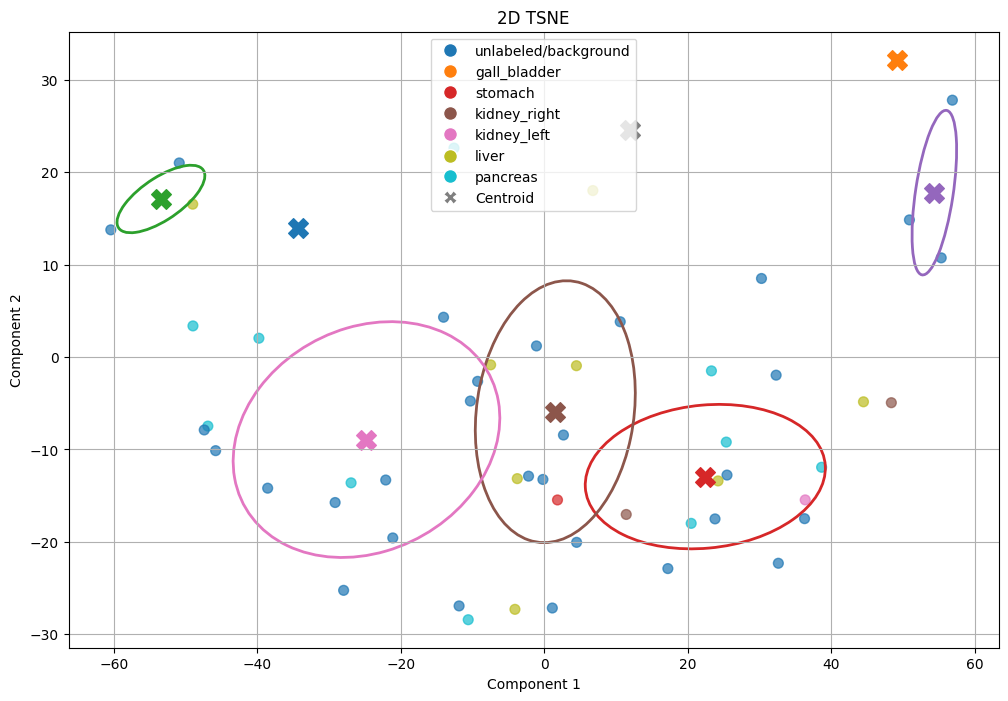

In [87]:
plot_2d(tsne_2d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "2D TSNE")

### On all 45 CTs

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/899656148.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



mplcursors is not installed. Hover functionality is disabled.


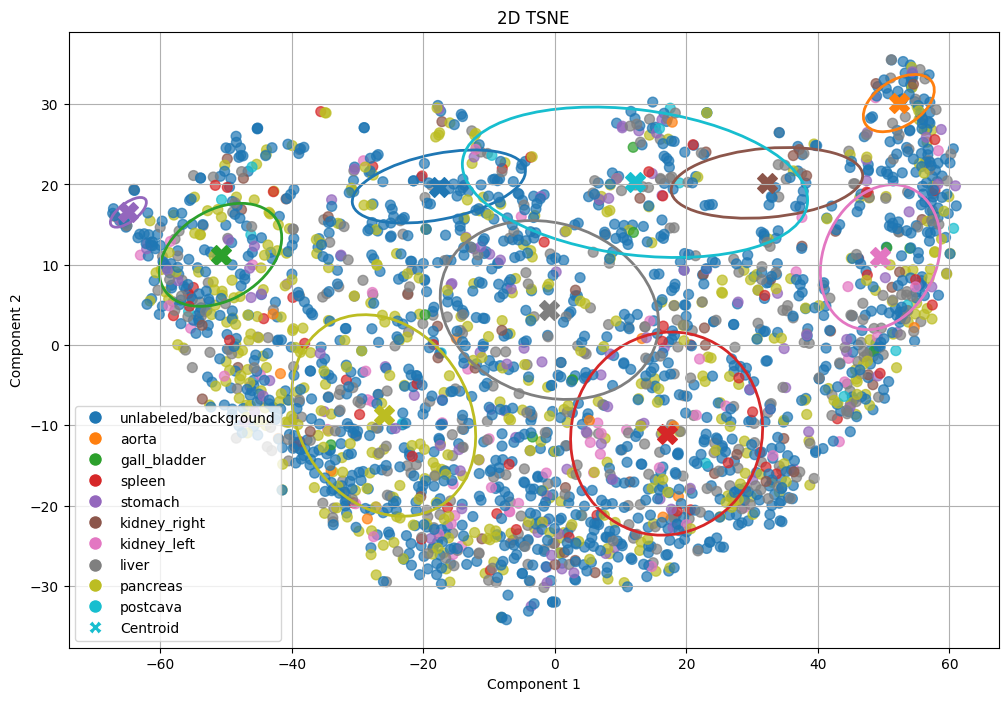

In [76]:
plot_2d(tsne_2d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "2D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_5259/1200743870.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap


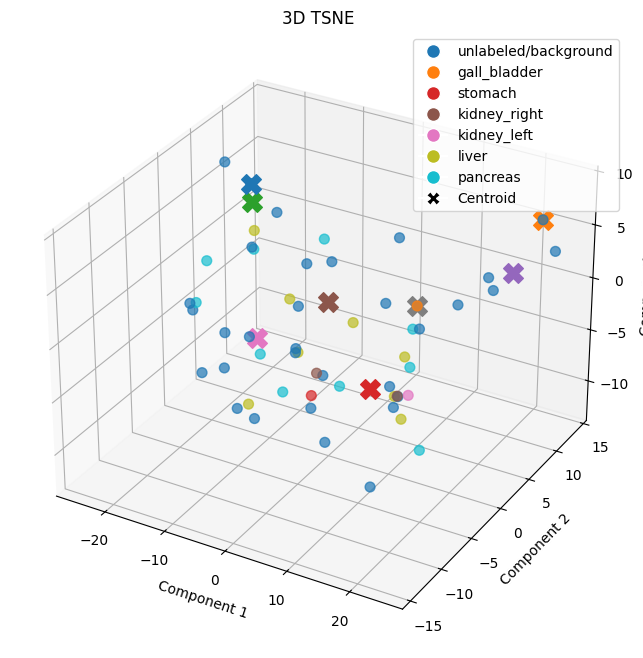

In [43]:
plot_3d(tsne_3d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "3D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:144: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



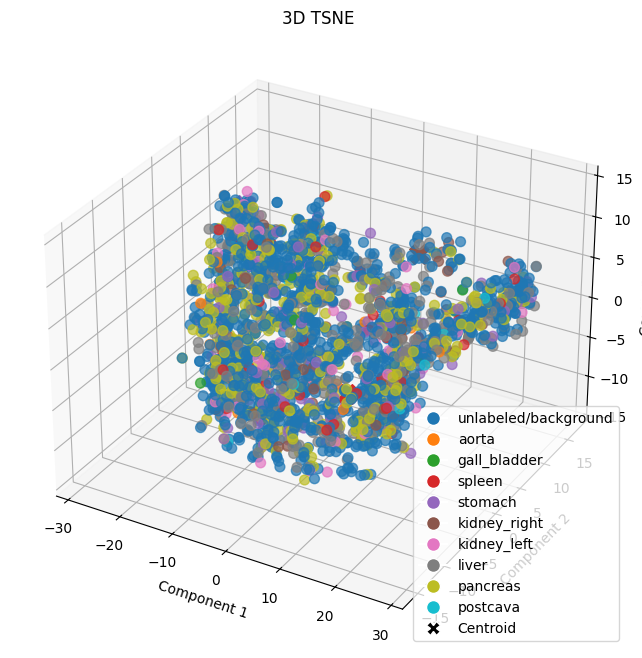

In [85]:
plot_3d(tsne_3d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "3D TSNE")

In [46]:
pd.DataFrame(tsne_3d[:55]).describe()

0          1          2
count  55.000000  55.000000  55.000000
mean    0.982329  -0.719148  -1.420108
std    12.985308   6.147784   5.081944
min   -24.688032 -14.226270 -12.386585
25%    -7.553623  -4.977463  -5.208958
50%     1.964806  -0.256702  -1.317239
75%    11.248823   2.363584   1.889115
max    24.667101  13.544825   8.897179

In [54]:
plot_interactive_3d_scatter(tsne_3d[:55], minibatchkmeans_10.labels_[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55])#, axis_range=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

In [55]:
plot_interactive_3d_scatter(tsne_3d, minibatchkmeans_10.labels_, sampled_points_multi_organ_labels.numpy().flatten(), axis_max=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

## On PCA, keeping all 8 components

In [63]:
from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

### Only Using middle vectors

I.e. vectors with coordinates $(12,12,12)$ within the encoded $24^3$

In [64]:
middle_vecs, indices = extract_middle_vectors(pca_8_features, n_samples=all_encoded_cubes.shape[0])

middle_vecs.shape

(2530, 8)

In [65]:
features = middle_vecs

In [72]:
minibatchkmeans_10.fit(features)
minibatchkmeans_6.fit(features)
minibatchkmeans_2.fit(features)
minibatchkmeans_4.fit(features)
minibatchkmeans_8.fit(features)
minibatchkmeans_12.fit(features)
minibatchkmeans_14.fit(features)

optics.fit(features)
dbscan.fit(features)

DBSCAN()

In [70]:
pd.DataFrame(optics.labels_[:55]).value_counts()

0  
-1     53
 8      1
 10     1
Name: count, dtype: int64

In [73]:
pd.DataFrame(dbscan.labels_[:55]).value_counts()

0 
 0    32
-1    23
Name: count, dtype: int64

In [56]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_clusters_mini10 = minibatchkmeans_10.labels_[:55]

In [57]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


### On Full $24^3$

In [26]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans

minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

In [27]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

minibatchkmeans_10.fit(pca_8_features)
minibatchkmeans_6.fit(pca_8_features)
minibatchkmeans_2.fit(pca_8_features)
minibatchkmeans_4.fit(pca_8_features)
minibatchkmeans_8.fit(pca_8_features)
minibatchkmeans_12.fit(pca_8_features)
minibatchkmeans_14.fit(pca_8_features)

MiniBatchKMeans(n_clusters=14, random_state=42)

In [28]:
pca_8_features.shape

(34974720, 8)

In [31]:
cluster_labels_mini10 = minibatchkmeans_10.labels_[indices]
cluster_labels_mini6 = minibatchkmeans_6.labels_[indices]
cluster_labels_mini2 = minibatchkmeans_2.labels_[indices]
cluster_labels_mini4 = minibatchkmeans_4.labels_[indices]
cluster_labels_mini8 = minibatchkmeans_8.labels_[indices]
cluster_labels_mini12 = minibatchkmeans_12.labels_[indices]
cluster_labels_mini14 = minibatchkmeans_14.labels_[indices]

cluster_labels_mini10.shape

(2530,)

In [32]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_sampled_points_coordinates.shape

torch.Size([55, 3])

In [33]:
first_ct_id = all_filtered_ids[0]

#### Save Clusters as Landmarks for ITK-SNAP

In [36]:
first_ct_clusters_mini10 = cluster_labels_mini10[:55]

In [37]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


In [41]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini6, filename='minibatchKmeans_6clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini2, filename='minibatchKmeans_2clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini4, filename='minibatchKmeans_4clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_6clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_2clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_4clusters.annot'.


In [45]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini8, filename='minibatchKmeans_8clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini12, filename='minibatchKmeans_12clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini14, filename='minibatchKmeans_14clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_8clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_12clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_14clusters.annot'.


#### Simply plot Sampled Coordinates and their Clusters in Interactive 3D

In [ ]:
import nibabel as nib
import os

first_ct_raw = nib.load(os.path.join('data/healthy-pancreas', first_ct_id, 'ct.nii.gz')).get_fdata()

In [143]:
first_ct_raw.shape

(403, 313, 201)

In [47]:
cluster_labels_mini10

array([5, 1, 8, 8, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 5, 1, 8, 1, 1, 8, 3, 5,
       6, 7, 3, 3, 3, 6, 3, 3, 3, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 5, 3,
       8, 5, 8, 4, 8, 5, 8, 1, 8, 1, 8], dtype=int32)

In [46]:
plot_interactive_3d_scatter(first_ct_sampled_points_coordinates.numpy(), cluster_labels=cluster_labels_mini10, axis_max=first_ct_raw.shape)

In [48]:
pd.DataFrame(cluster_labels_mini10).value_counts()

0
1    22
8    11
3    10
5     7
6     2
2     1
4     1
7     1
Name: count, dtype: int64

##### 3D CT plot looks horrific. Never do it again

## Labels: Pancreatic vs. Non-Pancreatic sampled point

The $96^3$ cube is labeled as "pancreatic" vs. not based on the location of its center point. If it's within the pancreas segmentation mask, it's labeled as "pancreatic".

### First 2 and 3 Components

### Only Middle Vectors

I.e. out of the $24^3$, plotting only point with coordinates $(12, 12, 12)$

In [ ]:
import numpy as np
from sklearn.cluster import OPTICS


# Initialize OPTICS
optics = OPTICS()#min_samples=50, xi=0.05, min_cluster_size=0.1)

# Fit the model
optics.fit(middle_vectors_full_pca)

# Retrieve cluster labels
cluster_labels = optics.labels_

# Add cluster labels to a DataFrame for easier handling
middle_vectors_df['OPTICS_Clusters'] = cluster_labels

# Display cluster assignments
print(middle_vectors_df.head())

In [ ]:
np.all(cluster_labels == -1)

In [ ]:
pd.DataFrame(cluster_labels_mini10).value_counts()

In [ ]:
pd.DataFrame(cluster_labels).value_counts()

In [ ]:
plot_3d(middle_vectors_df)

### Datashader Plotting 10 clusters on the PCA-ed features

In [ ]:
import holoviews as hv
from holoviews.operation.datashader import datashade
import datashader as ds
from bokeh.palettes import Category10, Category20, viridis
hv.extension('bokeh')

# Define color palette based on the number of unique clusters
unique_clusters = sorted(df_pca['Cluster'].unique())
num_clusters = len(unique_clusters)

if num_clusters <= 10:
    palette = Category10[10]
elif num_clusters <= 20:
    palette = Category20[20]
else:
    palette = viridis(num_clusters)

# Create a categorical color map
color_key = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

# Create HoloViews Points element with 'Cluster' as a categorical dimension
points = hv.Points(df_pca, ['PC1', 'PC2'], 'Cluster')

# Apply Datashader with the defined color map and appropriate aggregator
shaded = datashade(
    points, 
    cmap=palette, 
    aggregator=ds.count_cat('Cluster'),  # Aggregate counts per cluster
).opts(
    width=800,
    height=600,
    title='KMeans Clusters on First Two Principal Components'
)

# Display the plot
shaded

##### <font color='orange'> 3D non-datashader: This is gonna take forever</font>

Datashader doesn't support 3D plots. This means very slow projection

## Labels: Healthy vs. Unhealthy CT

In [ ]:
patient_ids = healthy_patient_ids + panc_patient_ids
pancreas_vs_background_labels = pancreas_vs_background_labels.tolist()

### Plotting all (38M, 8) vectors

Using 2D PCA features

In [ ]:
# Results for PCA on (50, 55, 8, 24, 24, 24), 8

from matplotlib import pyplot as plt

plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pancreas_vs_background_labels, cmap='viridis', s=1)

#### Same Plot but Much Faster - holoview, bokeh

In [ ]:
pca_solver_2d = PCA(n_components=2, random_state=42)

pca_results = pca_solver_2d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
hv.extension('bokeh')  # Initialize HoloViews with the Bokeh backend
import datashader as ds
from holoviews.operation.datashader import datashade
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.palettes import Category10, Category20


# Create a DataFrame
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

df['Label'] = pancreas_vs_background_labels.numpy().astype(str)  # Convert labels to string for categorical coloring

# Define color palette
unique_labels = df['Label'].unique()
num_labels = len(unique_labels)
palette = Category10[10] if num_labels <= 10 else Category20[20]

# Create a color key mapping each label to a color
color_key = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Create HoloViews Points with 'Label' as a categorical dimension
points = hv.Points(df, ['PC1', 'PC2'], ['Label'])

# Apply Datashader with the color_key
shaded = datashade(points, cmap=color_key, how='log', aggregator=ds.count_cat('Label')).opts(
    width=800,  # Set the width
    height=600  # Set the height
)

# Display the shaded plot
shaded

In [35]:
from sklearn.decomposition import PCA

pca_solver_3d = PCA(n_components=3, random_state=42)

pca_results_3d = pca_solver_3d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
import pandas as pd
import numpy as np
import plotly.io as pio

# Initialize HoloViews with the Plotly backend
hv.extension('plotly')

# Assuming you have 3 PCA components and labels
# Generate some random PCA data for illustration
pca_results = np.random.rand(1000, 3)  # Replace with your actual PCA results
pancreas_vs_background_labels = np.random.randint(0, 5, size=1000)  # Replace with your actual labels

# Create a DataFrame with PCA results and labels
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df['Label'] = pancreas_vs_background_labels.astype(str)  # Convert labels to string for categorical coloring

# Create a 3D scatter plot using HoloViews and Plotly
scatter = hv.Scatter3D(df, kdims=['PC1', 'PC2', 'PC3'], vdims='Label').opts(
    color='Label',  # Color based on Label
    cmap='Category10',  # Choose a colormap for the labels
    size=5,  # Set marker size
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
    marker='circle',  # Set marker type
    title="3D PCA Scatter Plot"  # Add a title
)

# Display the 3D plot
scatter

### Hyperparameter Search Plots

#### Best PCA

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [19]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [20]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [ ]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

In [ ]:
best_pca_features.shape

In [ ]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

#### Best T-SNE

In [24]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [ ]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

In [ ]:
plot_2d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

#### T-SNE w/ only 2,3 components (Worse)

In [28]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [ ]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

In [ ]:
plot_2d(best_2d_tsne_features, pancreas_vs_background_labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [ ]:
best_3d_tsne_features.shape

In [ ]:
plot_3d(best_3d_tsne_features, pancreas_vs_background_labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    

# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, pancreas_vs_background_labels)

In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org

# Code for Saving for projector.tensorflow.org

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

cluster_assignments = best_pca_clusters

def save_to_projector_tensorflow_tsv(embedding, cluster_assignments, labels, save_name=""):
    # Prepare data for TSV files
    # Create a DataFrame for the embedding
    embedding_df = pd.DataFrame(embedding)

    # Add cluster assignments and true labels
    embedding_df['Cluster'] = cluster_assignments
    embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

    feature_save_name = os.path.join("tsv_projections", f'features_{save_name}.tsv')
    metadata_save_name = os.path.join("tsv_projections", f'metadata_{save_name}.tsv')

    # Save the embedding vectors (without Cluster and Label columns)
    embedding_df.drop(columns=['Cluster', 'Label']).to_csv(feature_save_name, sep='\t', index=False, header=False)
    print(f"Embedding vectors saved to {feature_save_name}")

    # Save the metadata (Cluster assignments and Labels)
    metadata_df = embedding_df[['Cluster', 'Label']]
    metadata_df.to_csv(metadata_save_name, sep='\t', index=False)
    print(f"Metadata saved to {metadata_save_name}")

In [ ]:
save_to_projector_tensorflow_tsv(best_pca_features, best_pca_clusters, pancreas_vs_background_labels, save_name="best_pca")

In [ ]:
save_to_projector_tensorflow_tsv(best_tsne_features, best_tsne_clusters, pancreas_vs_background_labels, save_name="best_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_2d_tsne_features, best_2d_tsne_clusters, pancreas_vs_background_labels, save_name="best_2d_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_3d_tsne_features, best_3d_tsne_clusters, pancreas_vs_background_labels, save_name="best_3d_tsne")